In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

## systematic test 

In [2]:
import numpy as np
import healpy as hp

In [57]:
from systematics import sys_iteration, fitting_SP, sys_ngal
from systematics_module.contCorrection import doVisualization_ngal

In [169]:
def weightmultiply( weightDic ):
    
    length = weightDic['noweight'].size
    w0 = np.ones(length)
    names = weightDic.keys()
    print names
    n = len(names)
    for i in range(n):
        print names[i]
        w0 *= weightDic[names[i]]
        
    return w0
    

In [149]:
# calling catalog
#from systematics import GalaxyDensity_Systematics,loadSystematicMaps, chisquare_dof, MatchHPArea, SysMapBadRegionMask, callingEliGoldMask

def calling_sysMap( properties=None, kind='SPT', nside=4096, path = None ):
    # Calling maps
    from systematics import callingEliGoldMask,callingY1GoldMask
    GoldMask = callingEliGoldMask()
    #GoldMask = callingY1GoldMask(nside)
    
    MaskDic = {}
    for i,p in enumerate(properties):
        if p == 'NSTARS_allband':
            filename =  'y1a1_gold_1.0.2_stars_nside1024.fits'
            sysMap = loadSystematicMaps( filename = filename, property = p, filter = 'g', nside = 1024 , kind = kind)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
          
        elif p in ['SKYBRITEpca0', 'SKYBRITEpca1','SKYBRITEpca2', 'SKYBRITEpca3']:
            pcapath = '/n/des/lee.5922/data/systematic_maps/pca/'
            #for ind in range(2):
            if p == 'SKYBRITEpca0' : ind = 0
            elif p == 'SKYBRITEpca1' : ind = 1
            elif p == 'SKYBRITEpca2' : ind = 2
            elif p == 'SKYBRITEpca3' : ind = 3
            filename =  'pca'+str(ind)+'_Y1LSSmask_Y1A1NEW_COADD_SPT_band_gri_nside4096_oversamp4_SKYBRITE_coaddweights3_mean.fits'
            sysMap = loadSystematicMaps( filename = filename, property = p, \
                                        filter = 'g', nside = 4096 , kind = kind, path = pcapath)
            mapname = 'sys_'+'SKYBRITEpca'+str(ind)+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
        elif p == 'GE':
            sysMap = loadSystematicMaps( property = p, filter = 'g', nside = 512 , kind = kind, path = path)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
         
        else :
            filter = ['g', 'r', 'i', 'z']
            
            if p =='EXPTIME':
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_EXPTIME__total.fits.gz'\
                             for f in filter ]
            elif p =='DEPTH' :
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_maglimit3__.fits.gz'\
                             for f in filter ]
            elif p == 'NSTARS' : 
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_NSTARS_ACCEPTED_MEAN_coaddweights3_mean.fits.gz'\
                             for f in filter ]
            else : filename = [None for f in filter]

            for j,f in enumerate(filter):
                sysMap = loadSystematicMaps( filename = filename[j], property = p, filter = f, nside = nside , kind = kind, path = path)
                mapname = 'sys_'+p+'_'+f+'_'+kind
                keep = np.in1d(sysMap['PIXEL'], GoldMask['PIXEL'])
                MaskDic[mapname] = sysMap[keep]
                
    return MaskDic

In [136]:
def maskingCatalogSP(catalog=None, sysMap=None):
    
    
    exp_i_hpind = sysMap['sys_EXPTIME_i_SPT']['PIXEL'][(sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 500)]
    fwhm_r_hpind = sysMap['sys_FWHM_r_SPT']['PIXEL'][(sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5)]
    #ge_hpind = sysMap['sys_GE_g_SPT']['PIXEL'][(sysMap['sys_GE_g_SPT']['SIGNAL'] < 0.09)]
    ge_hpind = sysMap['sys_GE_g_SPT']['PIXEL'][(sysMap['sys_GE_g_SPT']['SIGNAL'] < 100000)]
    #skybrite_g_hpind = sysMap['sys_SKYBRITE_g_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 170)]
    #skybrite_i_hpind = sysMap['sys_SKYBRITE_i_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 1400)]
    skybrite_g_hpind = sysMap['sys_SKYBRITE_g_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 1700000)]
    skybrite_i_hpind = sysMap['sys_SKYBRITE_i_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 14000000)]  
    
    all_mask1 = np.zeros( hp.nside2npix(4096), dtype=bool )
    all_mask2 = np.zeros( hp.nside2npix(4096),dtype=bool )
    all_mask3 = np.zeros( hp.nside2npix(4096),dtype=bool )
    all_mask4 = np.zeros( hp.nside2npix(4096),dtype=bool )
    
    all_mask512 = np.zeros( hp.nside2npix(512),dtype=bool )
    
    all_mask1[exp_i_hpind] = 1
    all_mask2[fwhm_r_hpind] = 1
    all_mask3[skybrite_g_hpind] = 1
    all_mask4[skybrite_i_hpind] = 1
    
    all_mask512[ge_hpind] = 1
    all_mask4096 = all_mask1 * all_mask2 * all_mask3* all_mask4


    all_ind4096 = np.arange( hp.nside2npix(4096) )
    all_ind512 = np.arange( hp.nside2npix(512) )
    goodindices4096 = all_ind4096[all_mask4096]
    goodindices512 = all_ind512[all_mask512]
  
    
    #goodindices = np.hstack([exp_i_hpind, fwhm_r_hpind, ge_hpind])
    
    #exp_mask =  (sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 500) &  (sysMap['sys_EXPTIME_r_SPT']['SIGNAL'] < 500)
    #fwhm_mask = ((sysMap['sys_FWHM_g_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 500) 
    #            & (sysMap['sys_FWHM_i_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_z_SPT']['SIGNAL'] < 500))

    fwhm_mask = (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5) 
    skybrite_mask = (sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 160) & (sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 1400) \
    &(sysMap['sys_SKYBRITE_z_SPT']['SIGNAL'] < 3000) 
    
    #ge_mask = (sysMap['sys_GE_g_SPT']['SIGNAL'] < 0.08)  
    #all_mask = fwhm_mask*exp_mask*skybrite_mask
    #print 'exp mask ', 1. - np.sum(exp_mask) *1./exp_mask.size
    #print 'fwhm mask', 1. - np.sum(fwhm_mask) *1./fwhm_mask.size
    #print 'skybrite mask', 1. - np.sum(skybrite_mask) *1./skybrite_mask.size
    #print 'all mask', 1. - np.sum(fwhm_mask*exp_mask*skybrite_mask) *1./fwhm_mask.size   

    catHpInd4096 = hpRaDecToHEALPixel(catalog['RA'], catalog['DEC'], nside=4096, nest=False)
    catHpInd512 = hpRaDecToHEALPixel(catalog['RA'], catalog['DEC'], nside=512, nest=False)
    HpIdxInsys_mask4096 = np.in1d(catHpInd4096, goodindices4096)
    HpIdxInsys_mask512 = np.in1d(catHpInd512, goodindices512)
    
    HpIdxInsys_mask = HpIdxInsys_mask4096 * HpIdxInsys_mask512
    
    print HpIdxInsys_mask.size, np.sum(HpIdxInsys_mask)
    print 'mask ', np.sum(HpIdxInsys_mask) * 1./catalog.size
    return catalog[HpIdxInsys_mask]
    

In [7]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [8]:
# import DMASS

dmass = fitsio.read('../output/n2_2/dmass_spt.fits')
#dmass = cutcat20(dmass)
cmass = fitsio.read('../output/n2/dmass_st82.fits')
print 'dmass sample size :', dmass.size
print 'cmass sample size :', cmass.size

dmass sample size : 112398
cmass sample size : 11593


In [9]:
#rand_bg = uniform_random_on_sphere(dmass_spt2, size = 100 * dmass_spt2.size)
#rand_bg = Cuts.keepGoodRegion(rand_bg)
#rand_bg_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
#rand_bg_train = Cuts.keepGoodRegion(rand_bg_train)

rand = uniform_random_on_sphere(dmass, size = 10 * dmass.size)
rand = Cuts.keepGoodRegion(rand)
#rand = Cuts.keepY1GoldRegion(rand)
rand = rand[ rand['DEC'] < -3.0 ]
#rand = cutcat20(rand)

rand2 = uniform_random_on_sphere(dmass, size = 50 * dmass.size)
rand2 = Cuts.keepGoodRegion(rand2)
#rand = Cuts.keepY1GoldRegion(rand)
rand2 = rand2[ rand2['DEC'] < -3.0 ]
#rand2 = cutcat20(rand2)

rand_cmass = uniform_random_on_sphere(cmass, size = 200 * cmass.size)
rand_cmass = Cuts.keepGoodRegion(rand_cmass)
rand_cmass = rand_cmass[ rand_cmass['DEC'] > -3.0 ]

rand2_cmass = uniform_random_on_sphere(cmass, size = 500 * cmass.size)
rand2_cmass = Cuts.keepGoodRegion(rand2_cmass)
rand2_cmass = rand2_cmass[ rand2_cmass['DEC'] > -3.0 ]

print rand.size, dmass.size
print rand_cmass.size, cmass.size
#rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
#rand_train = Cuts.keepGoodRegion(rand_train)

510370 112398
187680 11593


In [33]:
kind = 'SPT'
FullArea = SPTMaparea
#properties = ['DEPTH','EXPTIME']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS']
#properties = ['SKYBRITEpca']
properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'SKYBRITEpca0', 'SKYBRITEpca1', 'SKYBRITEpca2','NSTARS_allband', 'GE']
#properties = ['FWHM']
suffix='no_weight'
# calculating galaxy density and weights iterately

In [140]:
sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_EXPTIME__total.fits.gz

In [150]:
sysMap_pca = calling_sysMap( properties=['SKYBRITEpca0', 'SKYBRITEpca1', 'SKYBRITEpca2'], kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/pca/
pca0_Y1LSSmask_Y1A1NEW_COADD_SPT_band_gri_nside4096_oversamp4_SKYBRITE_coaddweights3_mean.fits
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/pca/
pca1_Y1LSSmask_Y1A1NEW_COADD_SPT_band_gri_nside4096_oversamp4_SKYBRITE_coaddweights3_mean.fits
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/pca/
pca2_Y1LSSmask_Y1A1NEW_COADD_SPT_band_gri_nside4096_oversamp4_SKYBRITE_coaddweights3_mean.fits
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [61]:
dmass_masked = maskingCatalogSP(catalog=dmass, sysMap=sysMap)
rand_masked = maskingCatalogSP(catalog=rand, sysMap=sysMap)
rand2_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap)

112398 108272
mask  0.9632911617644442
510370 494199
mask  0.9683151439151988
2550404 2469412
mask  0.968243462604356


In [148]:
sysMap_pca.keys()

['sys_SKYBRITEpca00_g_SPT',
 'sys_SKYBRITEpca11_g_SPT',
 'sys_SKYBRITEpca22_g_SPT']

In [47]:
inputdir = '../data_txt/systematics/5th/'
figoutdir = '../data_txt/systematics/5th/figure/'
os.system('mkdir '+inputdir)
os.system('mkdir '+figoutdir)
os.system('mkdir '+inputdir+'/weights/')
os.system('cp ../data_txt/systematics/4th/systematic*_no_weight.txt '+inputdir+'/.')

0

In [155]:
sys_ngal(cat1 = dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2 = rand2_masked, sysmap = sysMap_pca, 
         FullArea = SPTMaparea, properties = ['SKYBRITEpca0', 'SKYBRITEpca1', 'SKYBRITEpca2'], kind='SPT', nbins =15, 
         reweight= None, nside = 4096,
         suffix='no_weight', outdir=inputdir)

../systematics.py:455: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:455: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../data_txt/systematics/5th/systematic_SKYBRITEpca0_g_SPT_no_weight.txt


../systematics.py:451: RuntimeWarning: invalid value encountered in divide
  Ngal_avg = Ngal *1./Nrand


saving data to  ../data_txt/systematics/5th/systematic_SKYBRITEpca1_g_SPT_no_weight.txt
saving data to  ../data_txt/systematics/5th/systematic_SKYBRITEpca2_g_SPT_no_weight.txt


saving fig to  ../data_txt/systematics/5th/figure/systematic_DEPTH_SPT_no_weight.png
saving fig to  ../data_txt/systematics/5th/figure/systematic_EXPTIME_SPT_no_weight.png
saving fig to  ../data_txt/systematics/5th/figure/systematic_AIRMASS_SPT_no_weight.png
saving fig to  ../data_txt/systematics/5th/figure/systematic_SKYBRITE_SPT_no_weight.png
saving fig to  ../data_txt/systematics/5th/figure/systematic_FWHM_SPT_no_weight.png
saving fig to  ../data_txt/systematics/5th/figure/systematic_SKYBRITEpca0_SPT_no_weight.png
saving fig to  ../data_txt/systematics/5th/figure/systematic_SKYBRITEpca1_SPT_no_weight.png
saving fig to  ../data_txt/systematics/5th/figure/systematic_NSTARS_allband_SPT_no_weight.png
saving fig to  ../data_txt/systematics/5th/figure/systematic_GE_SPT_no_weight.png


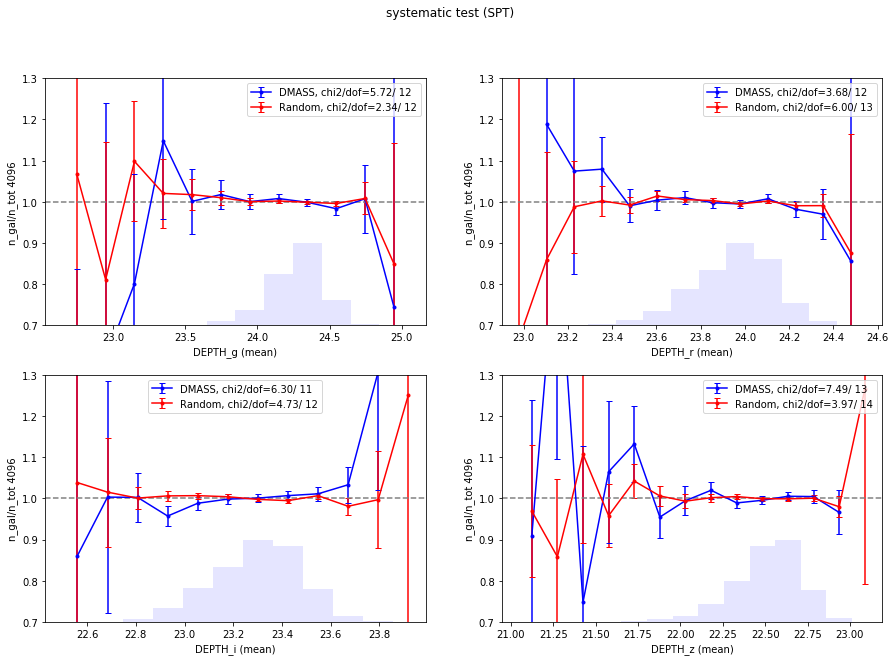

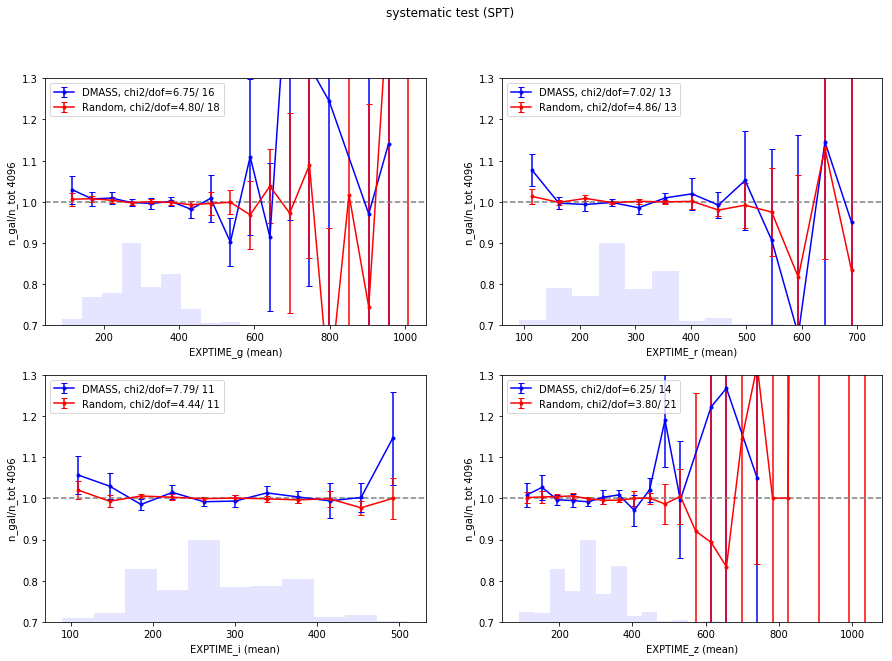

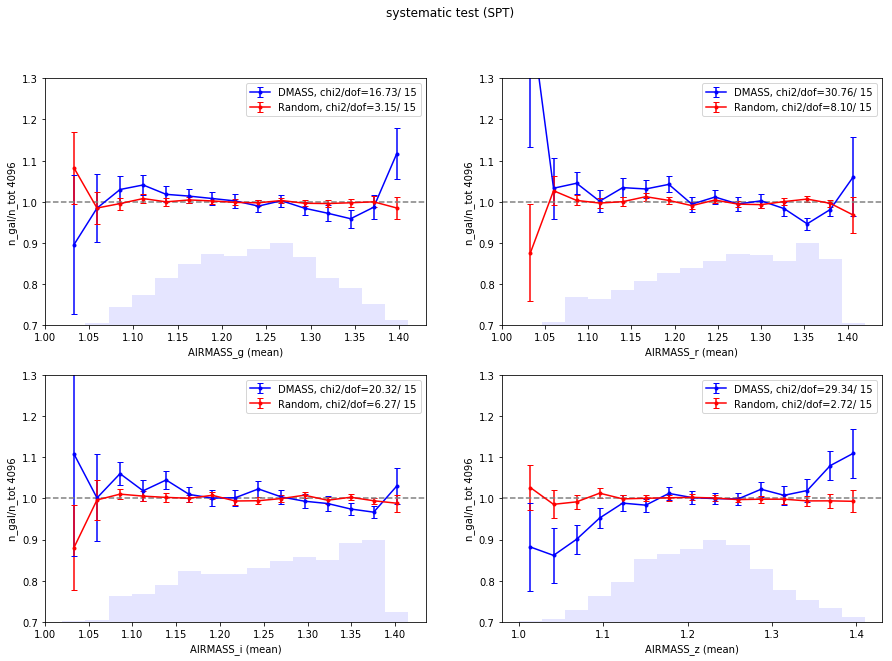

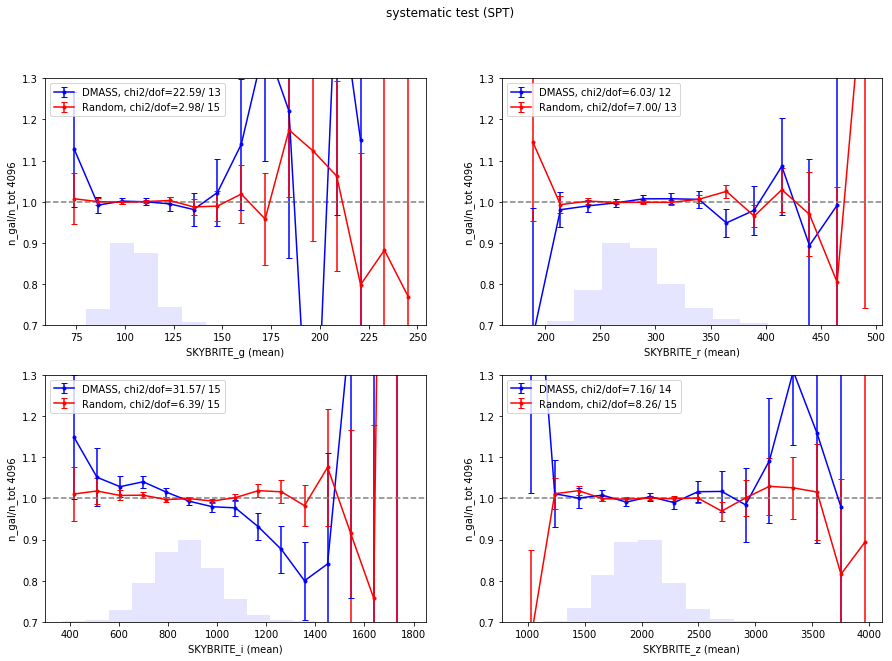

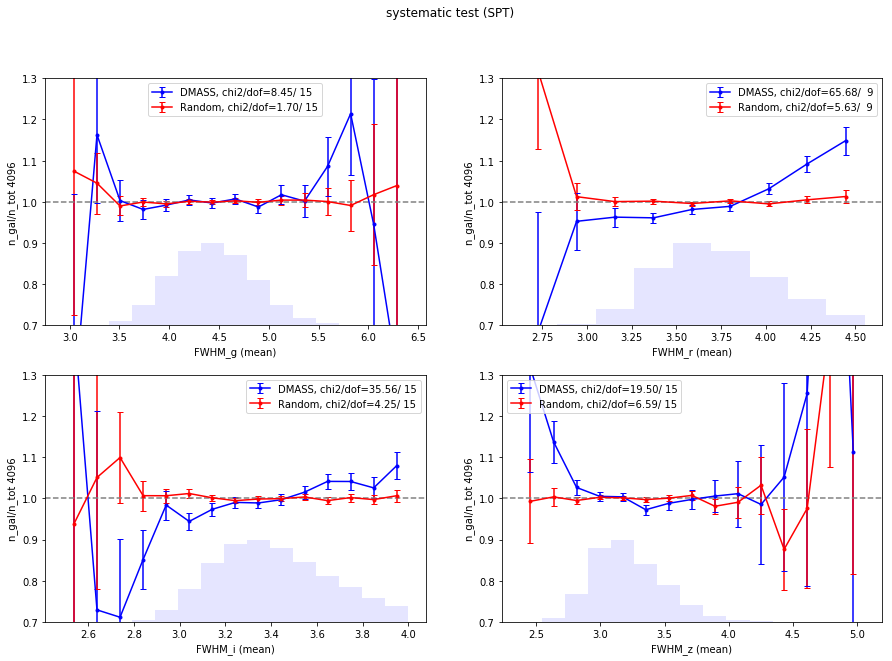

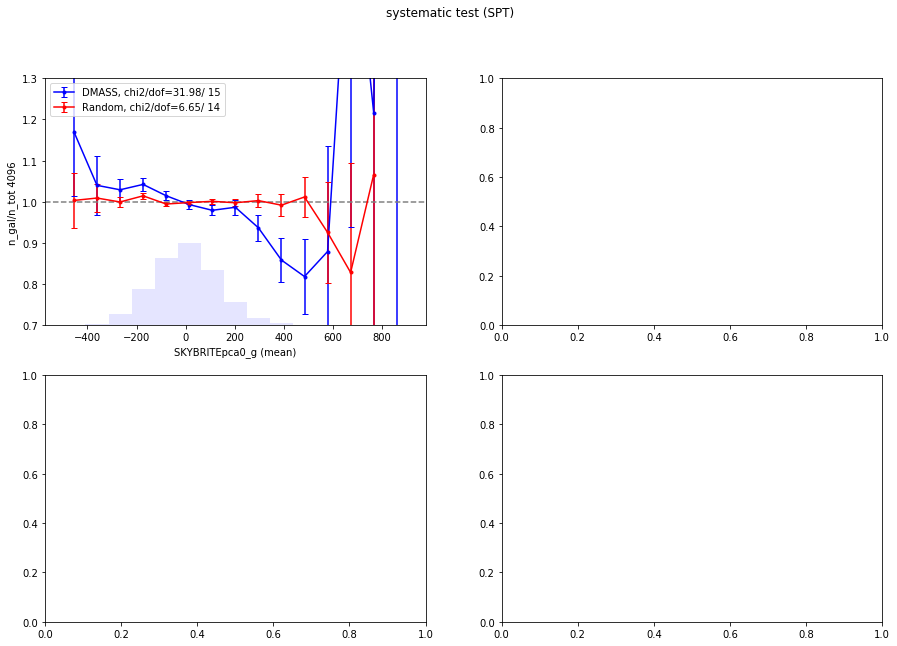

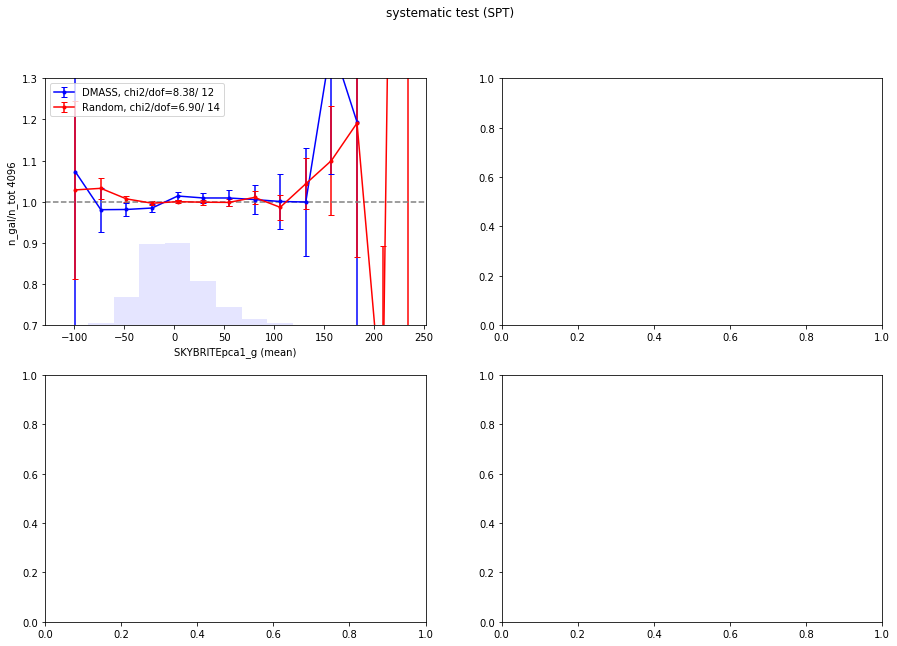

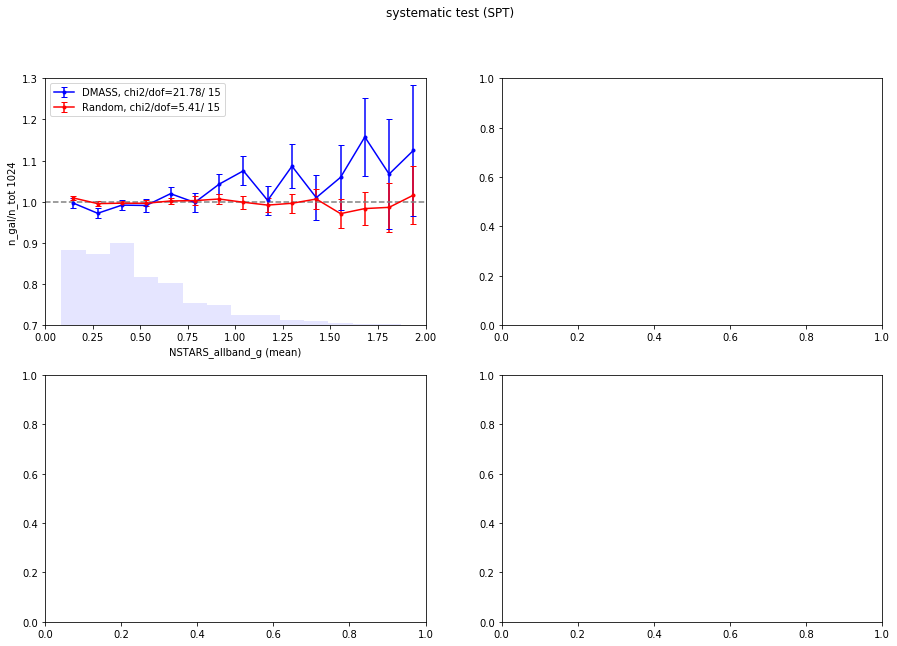

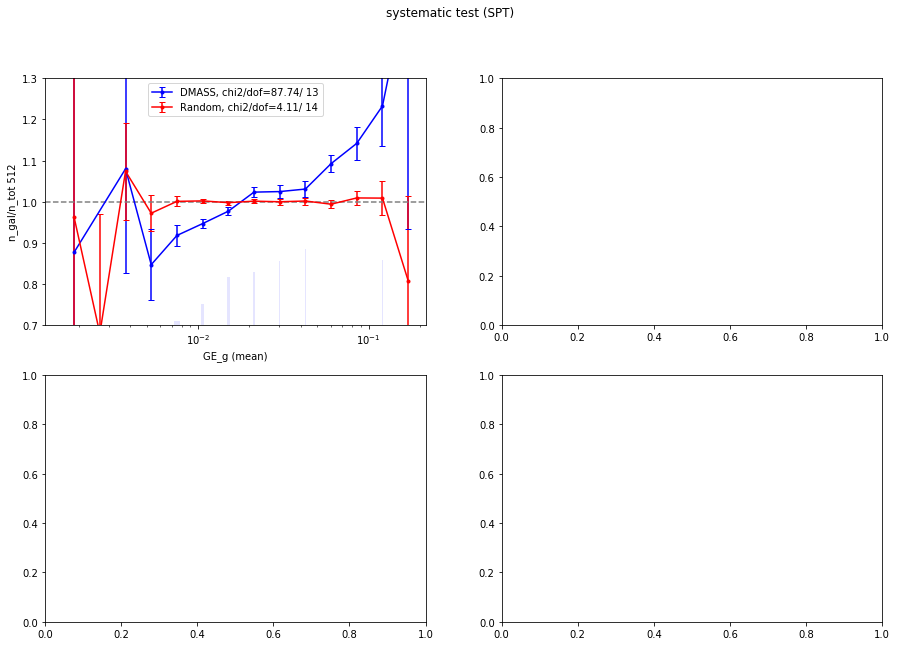

In [156]:
from systematics_module.contCorrection import doVisualization_ngal

for p in properties : 
    doVisualization_ngal(property = p, nside = 4096, kind = kind, suffix='no_weight', \
                         inputdir=inputdir, outdir=figoutdir)

chi2_null =  21.778518563677956
chi2_mod. =  10.188101728396207
Delta chi2 (sample) = 11.590416835281749
output save to  ../data_txt/systematics/5th/systematic_NSTARS_allband_g_SPT_no_weight.txt.model

chi2_null =  87.73554134200364
chi2_mod. =  7.898186213009346
Delta chi2 (sample) = 79.83735512899429
output save to  ../data_txt/systematics/5th/systematic_GE_g_SPT_no_weight.txt.model

chi2_null =  31.979444482793056
chi2_mod. =  7.498162422670926
Delta chi2 (sample) = 24.48128206012213
output save to  ../data_txt/systematics/5th/systematic_SKYBRITEpca0_g_SPT_no_weight.txt.model

chi2_null =  8.382116129342107
chi2_mod. =  4.600228677270777
Delta chi2 (sample) = 3.78188745207133
output save to  ../data_txt/systematics/5th/systematic_SKYBRITEpca1_g_SPT_no_weight.txt.model

chi2_null =  8.382116129342107
chi2_mod. =  4.600228677270777
Delta chi2 (sample) = 3.78188745207133
output save to  ../data_txt/systematics/5th/systematic_SKYBRITEpca2_g_SPT_no_weight.txt.model

chi2_null =  5.715908

(['GE_g',
  'FWHM_r',
  'FWHM_i',
  'SKYBRITE_i',
  'SKYBRITEpca0_g',
  'AIRMASS_r',
  'AIRMASS_z',
  'AIRMASS_i',
  'NSTARS_allband_g',
  'AIRMASS_g',
  'FWHM_z',
  'DEPTH_i',
  'SKYBRITEpca1_g',
  'EXPTIME_g',
  'DEPTH_g',
  'FWHM_g',
  'DEPTH_r',
  'SKYBRITE_g',
  'EXPTIME_z',
  'EXPTIME_i',
  'SKYBRITE_z',
  'SKYBRITE_r',
  'DEPTH_z',
  'EXPTIME_r'],
 [79.83735512899429,
  53.49617865476577,
  28.509744706065348,
  26.760437131711505,
  24.48128206012213,
  18.367289560103742,
  17.471874037287286,
  13.953920005412595,
  11.590416835281749,
  7.180282678905282,
  5.015956513125536,
  3.9620365550386714,
  3.78188745207133,
  1.8176606759773017,
  1.042187768236305,
  0.8288005497627875,
  0.6149681116305241,
  0.45263595633948484,
  0.2764250508388004,
  0.13316766113053813,
  0.12007363708290963,
  0.11243766010556655,
  0.010894676698766759,
  0.005140852971523557])

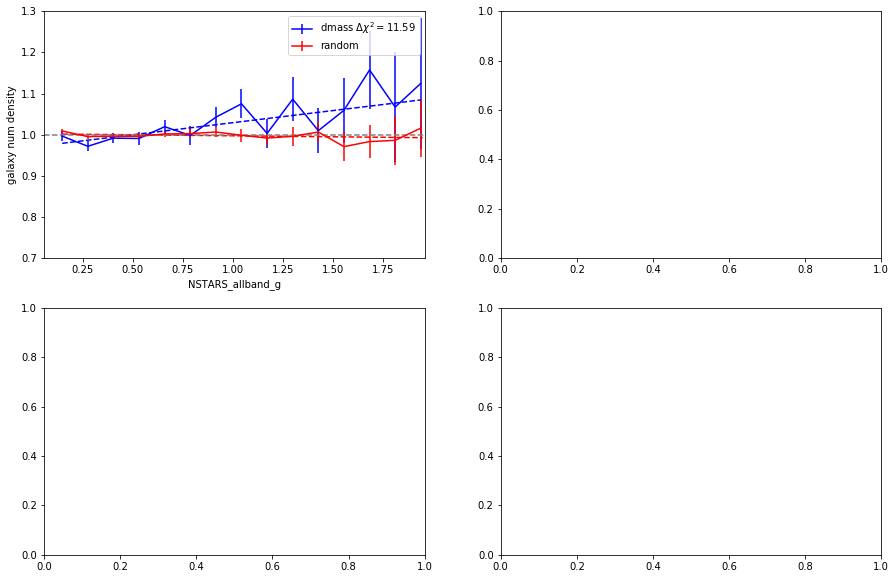

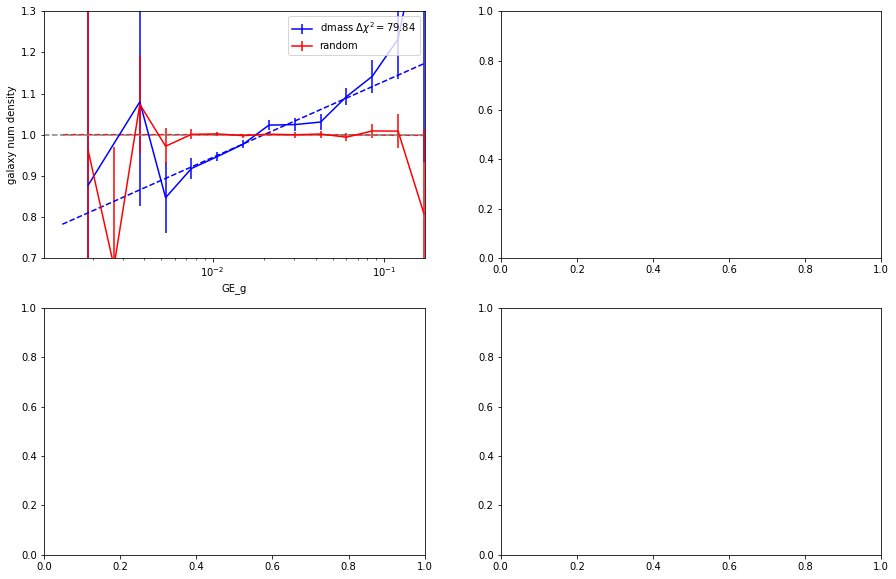

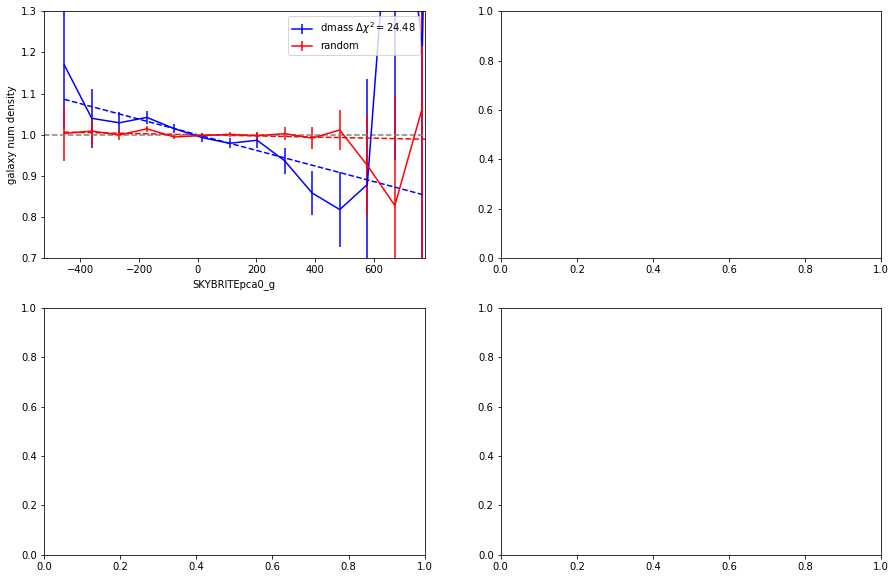

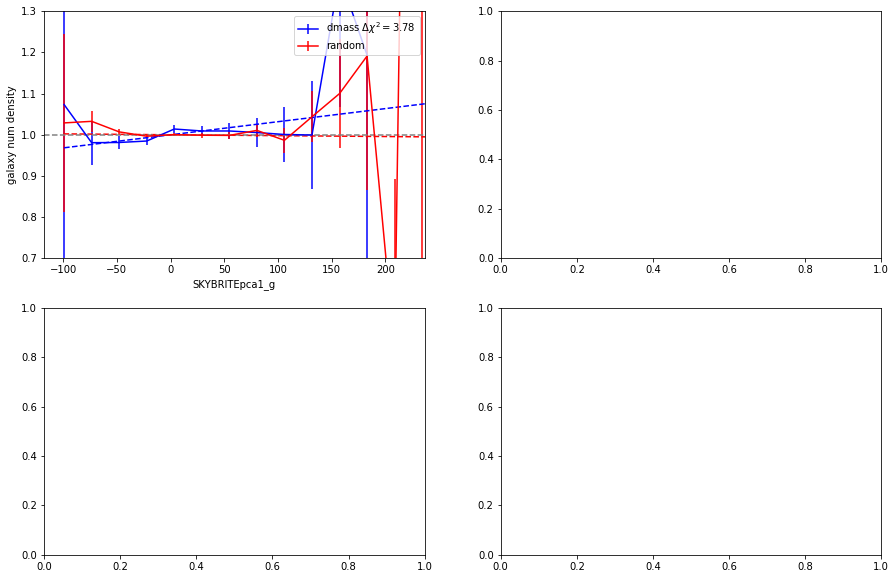

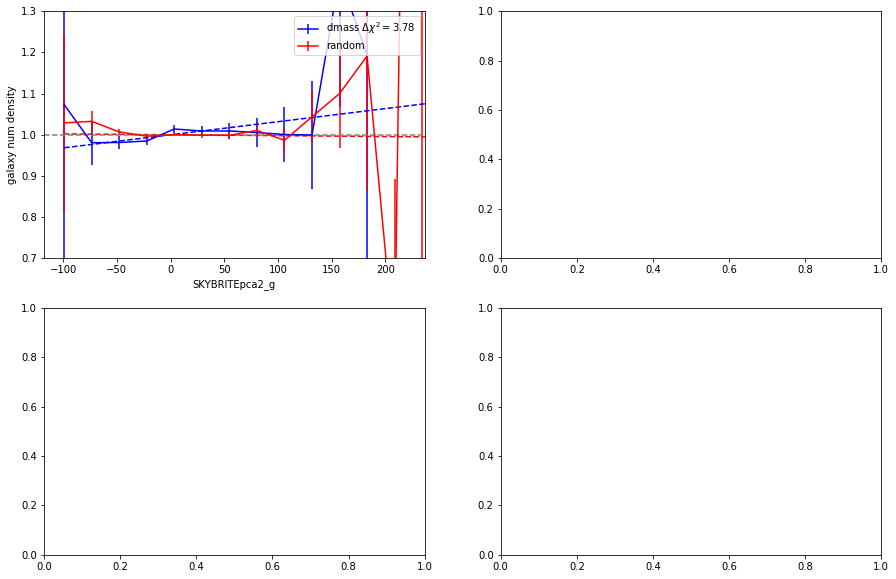

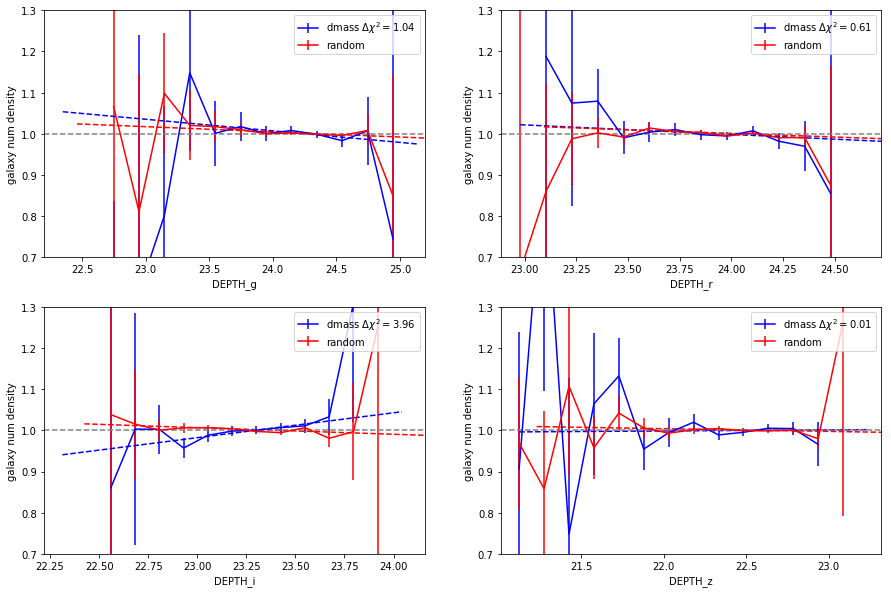

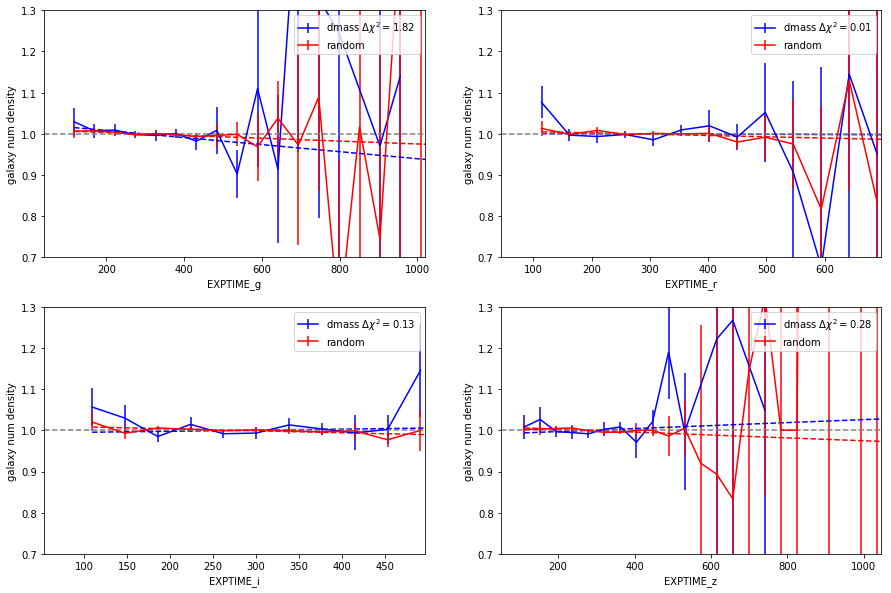

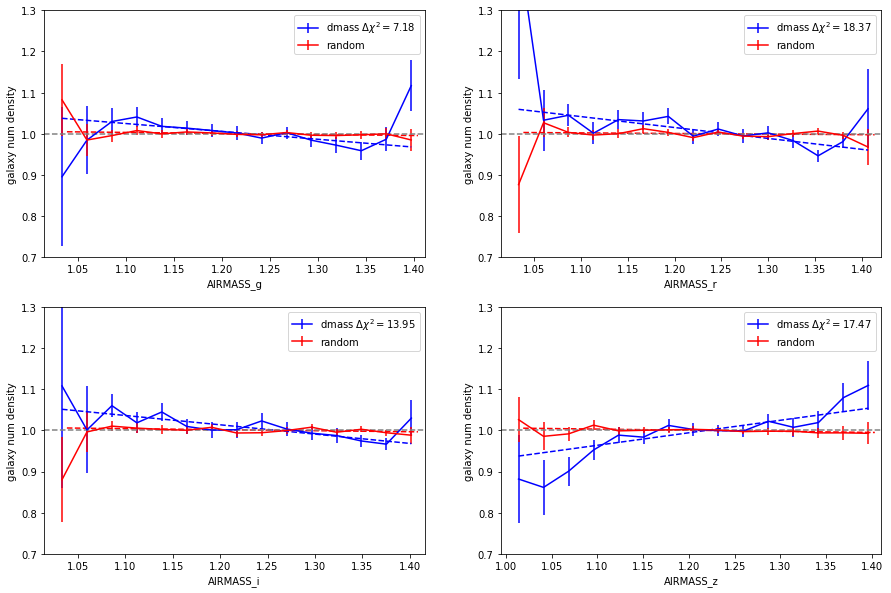

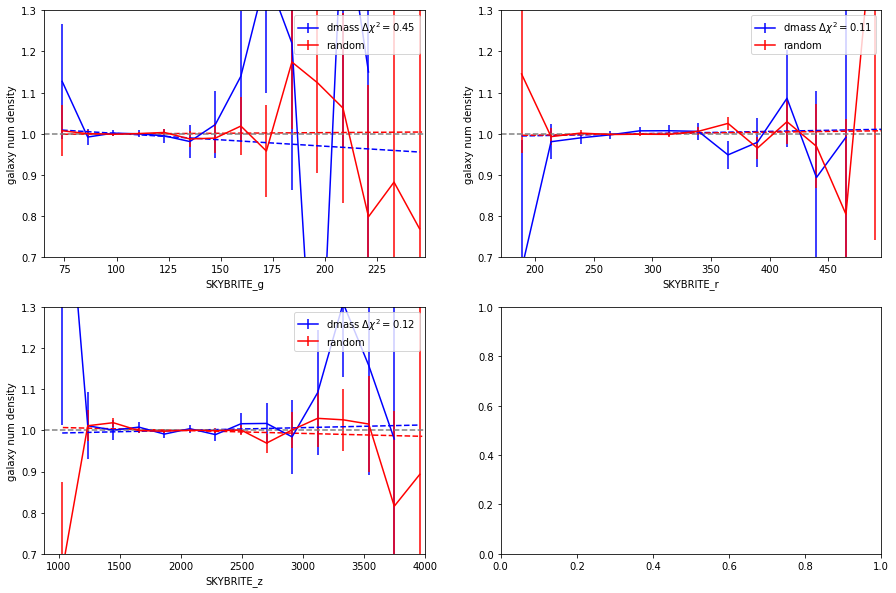

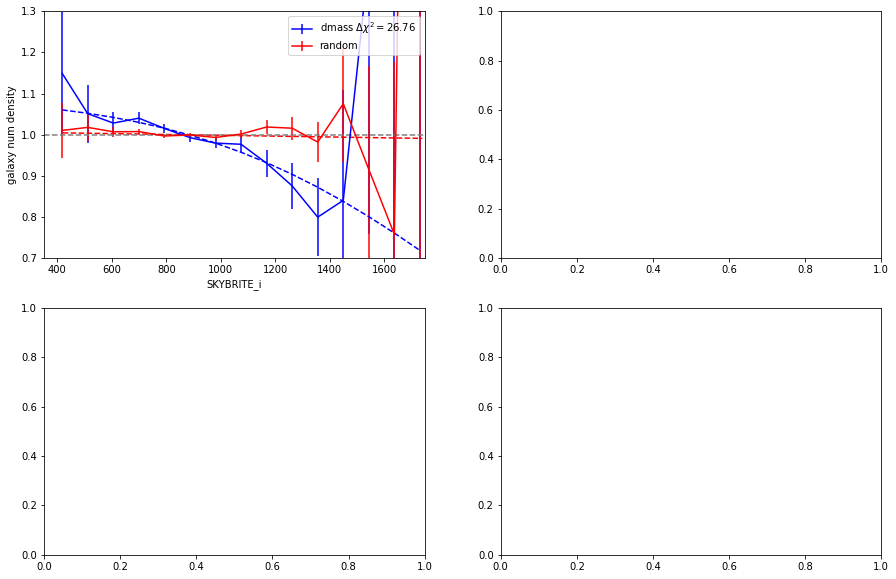

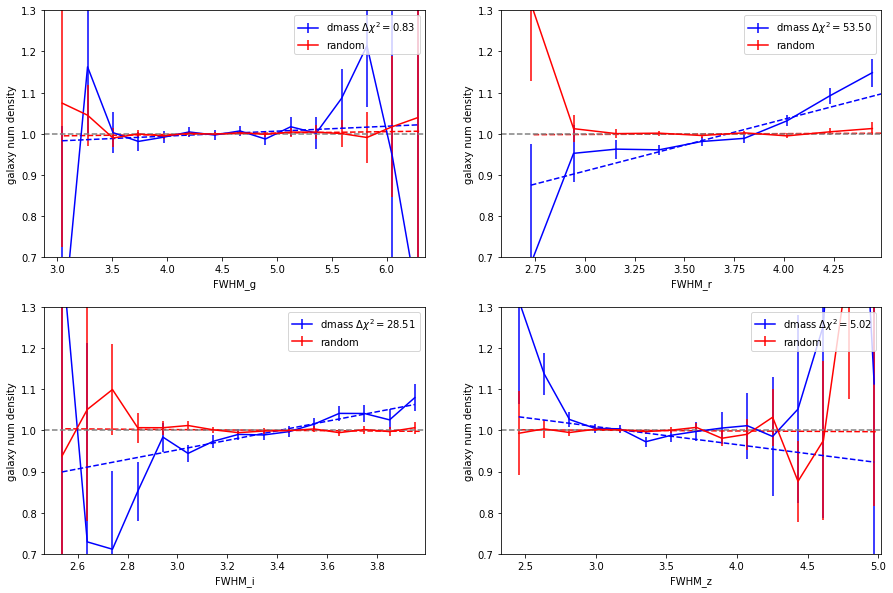

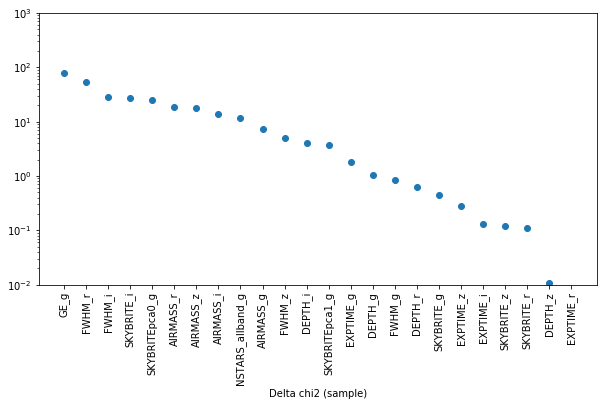

In [157]:
filters = ['g']
fitting_SP( property = ['NSTARS_allband'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'log',
                path = inputdir )

filters = ['g']
fitting_SP( property = ['SKYBRITEpca0'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

filters = ['g']
fitting_SP( property = ['SKYBRITEpca1', 'SKYBRITEpca2'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

filters = ['g', 'r', 'i', 'z']
fitting_SP( property = ['DEPTH'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

filters = ['g', 'r', 'i', 'z']
fitting_SP( property = ['EXPTIME'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

filters = ['g', 'r', 'i', 'z']
fitting_SP( property = ['AIRMASS'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )


filters = ['g', 'r', 'z']
fitting_SP( property = ['SKYBRITE'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )


filters = ['i']
fitting_SP( property = ['SKYBRITE'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'errftn',
                path = inputdir )




filters = ['g', 'r', 'i', 'z']
fitting_SP( property = ['FWHM'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, suffix='no_weight', 
                path = inputdir, deltachi2=True)


# Correction ! 

### Galactic Extinction

In [158]:
weightDic = {}
weightDic['noweight'] = np.ones(dmass_masked.size)
all_weight = weightDic['noweight']
suffix = 'no_weight'
nextweight = 'FWHM_r'

In [159]:
properties_pca= ['SKYBRITEpca0', 'SKYBRITEpca1', 'SKYBRITEpca2']

----------------------------------
initialize function  FWHM_r
linear
store weight  FWHM_r
save weight to fits ../data_txt/systematics/5th//weights/wg_fwhm_r_SPT.fits
suffix =  wg_fwhm_r
saving data to  ../data_txt/systematics/5th/systematic_SKYBRITEpca0_g_SPT_wg_fwhm_r.txt
saving data to  ../data_txt/systematics/5th/systematic_SKYBRITEpca1_g_SPT_wg_fwhm_r.txt
saving data to  ../data_txt/systematics/5th/systematic_SKYBRITEpca2_g_SPT_wg_fwhm_r.txt


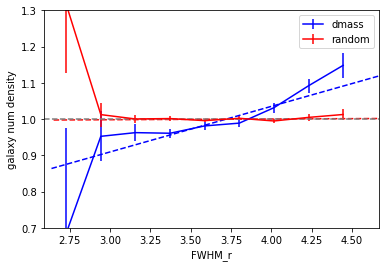

In [160]:
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties_pca, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  6.227668022479731
chi2_mod. =  3.554440454999772
Delta chi2 (sample) = 2.6732275674799593
output save to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r.txt.model

chi2_null =  5.750512618006349
chi2_mod. =  3.4926787480968735
Delta chi2 (sample) = 2.2578338699094753
output save to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r.txt.model

chi2_null =  5.120799574930578
chi2_mod. =  3.0225073437187486
Delta chi2 (sample) = 2.098292231211829
output save to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r.txt.model

chi2_null =  7.833609846855952
chi2_mod. =  7.62899458896945
Delta chi2 (sample) = 0.20461525788650192
output save to  ../data_txt/systematics/5th/systematic_DEPTH_z_SPT_wg_fwhm_r.txt.model

chi2_null =  7.322654829138187
chi2_mod. =  4.6853625985799585
Delta chi2 (sample) = 2.637292230558229
output save to  ../data_txt/systematics/5th/systematic_EXPTIME_g_SPT_wg_fwhm_r.txt.model

chi2_null =  9.974240803237272
chi2_mod. =

(['GE_g',
  'AIRMASS_z',
  'SKYBRITE_i',
  'SKYBRITEpca0_g',
  'NSTARS_allband_g',
  'AIRMASS_r',
  'AIRMASS_i',
  'SKYBRITEpca2_g',
  'SKYBRITEpca1_g',
  'FWHM_i',
  'FWHM_z',
  'AIRMASS_g',
  'DEPTH_g',
  'EXPTIME_g',
  'SKYBRITE_r',
  'DEPTH_r',
  'DEPTH_i',
  'SKYBRITE_z',
  'FWHM_g',
  'EXPTIME_r',
  'DEPTH_z',
  'EXPTIME_i',
  'FWHM_r',
  'SKYBRITE_g',
  'EXPTIME_z'],
 [90.68011815727198,
  21.303123931305976,
  17.750912076201327,
  15.93514279807341,
  13.163828457958653,
  10.486936891145595,
  9.86366246003227,
  7.9643630044707905,
  7.9643630044707905,
  7.858882243580525,
  6.516261982222744,
  3.8678509013567126,
  2.6732275674799593,
  2.637292230558229,
  2.2931924350320996,
  2.2578338699094753,
  2.098292231211829,
  0.8304088489574459,
  0.7074968904495247,
  0.3835157995259113,
  0.20461525788650192,
  0.10818883279955216,
  0.08434273336291653,
  0.037396355545158855,
  0.010575836906593139])

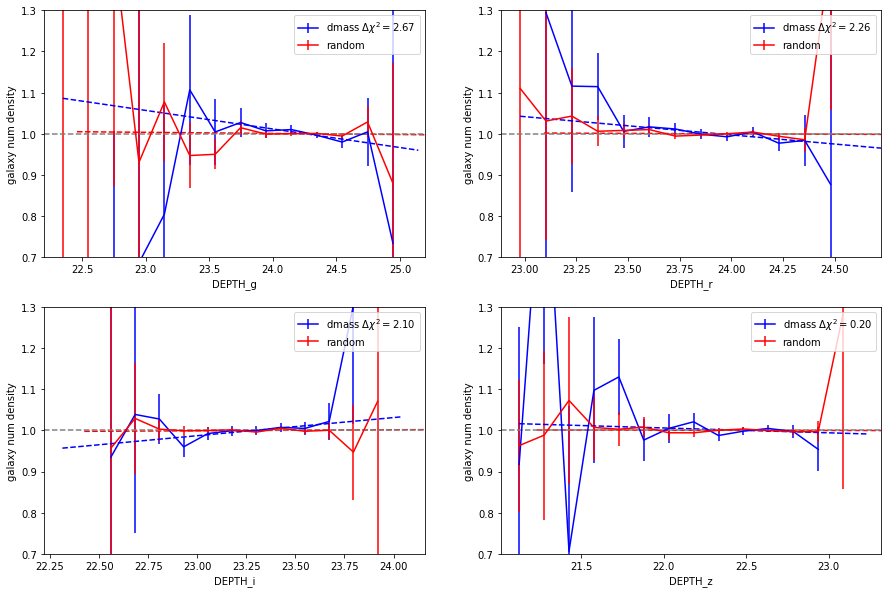

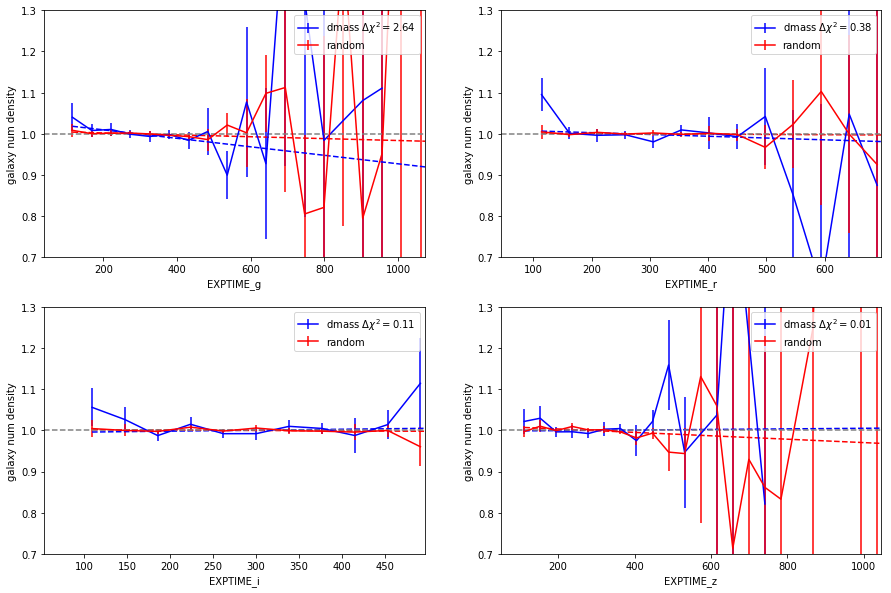

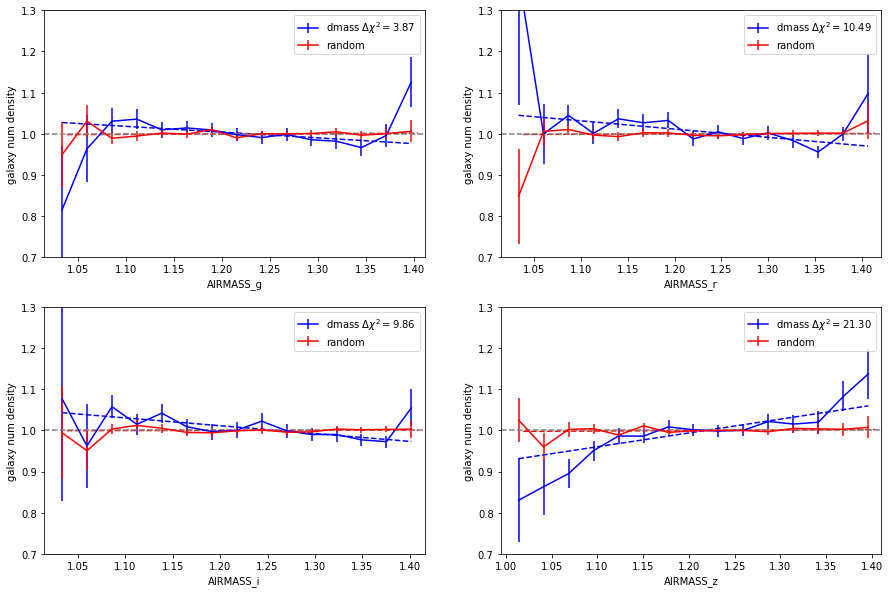

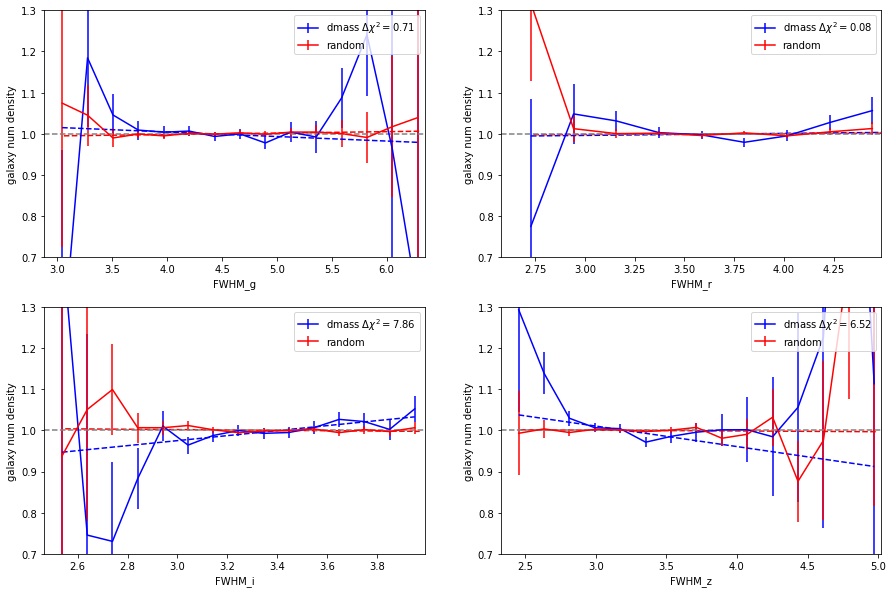

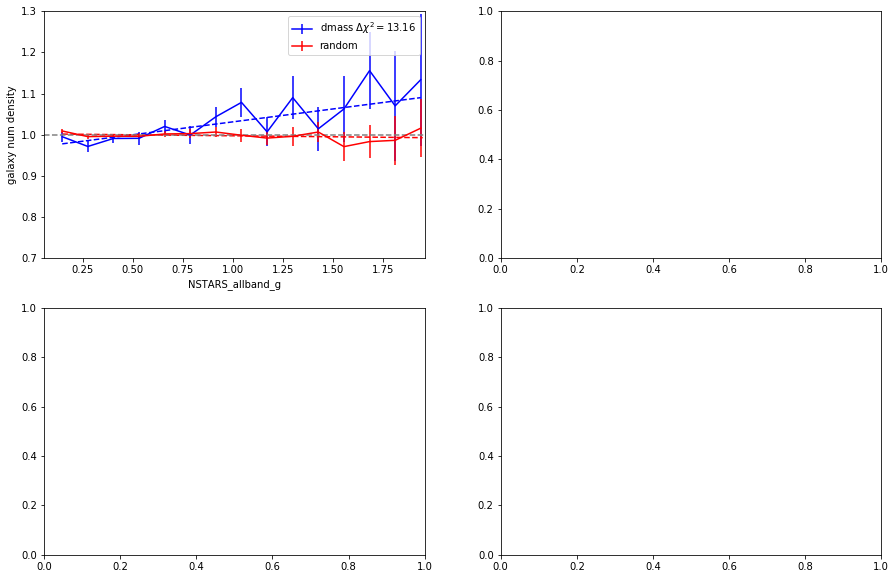

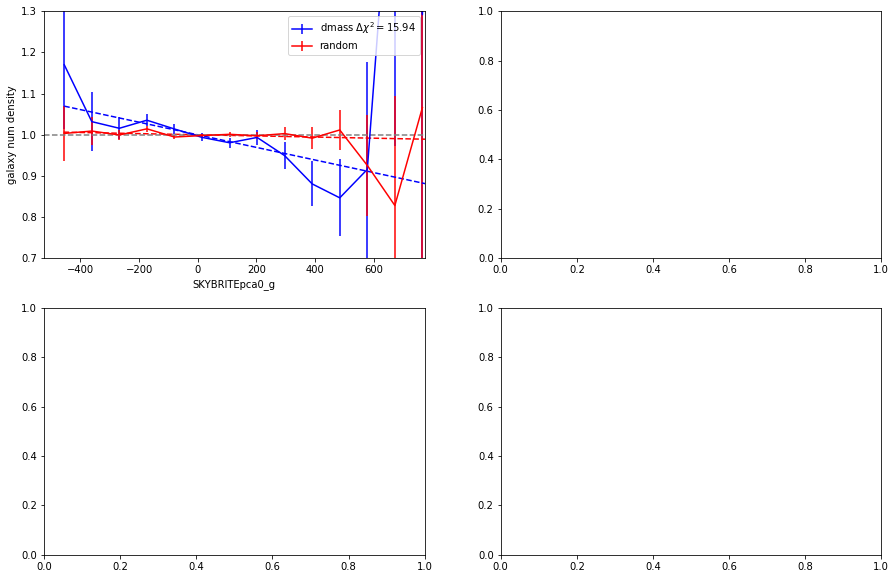

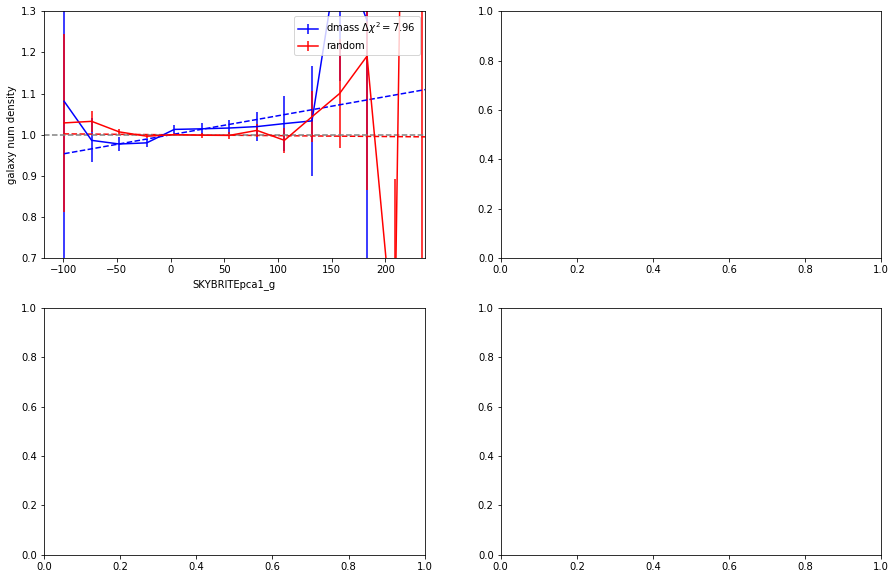

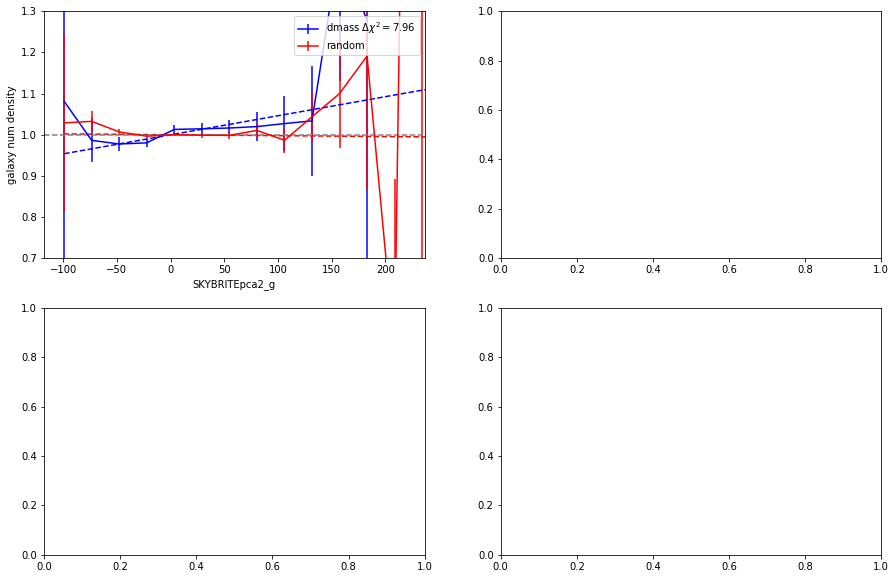

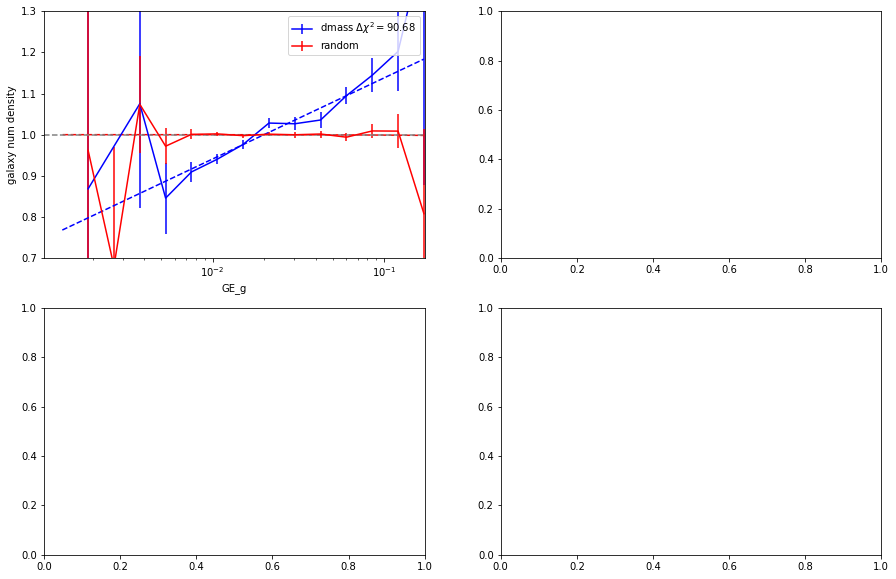

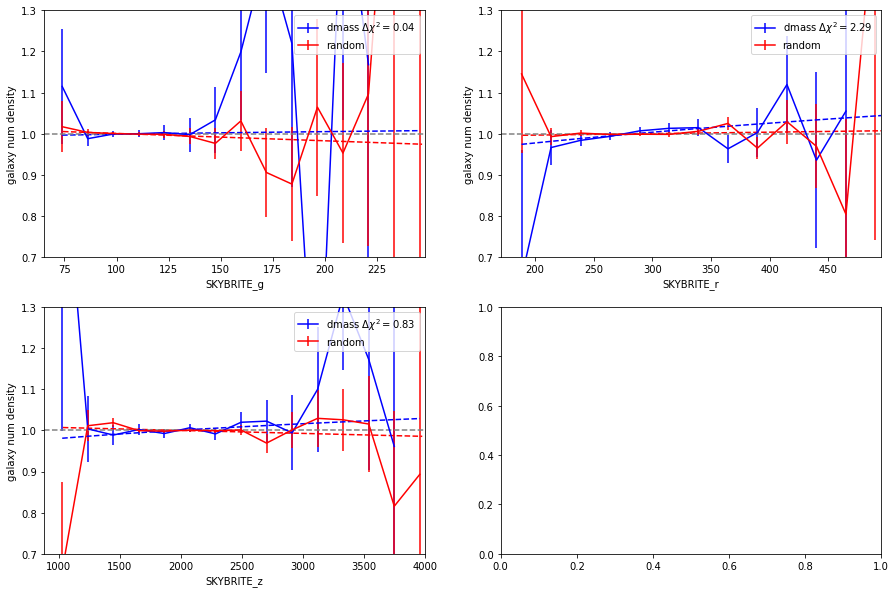

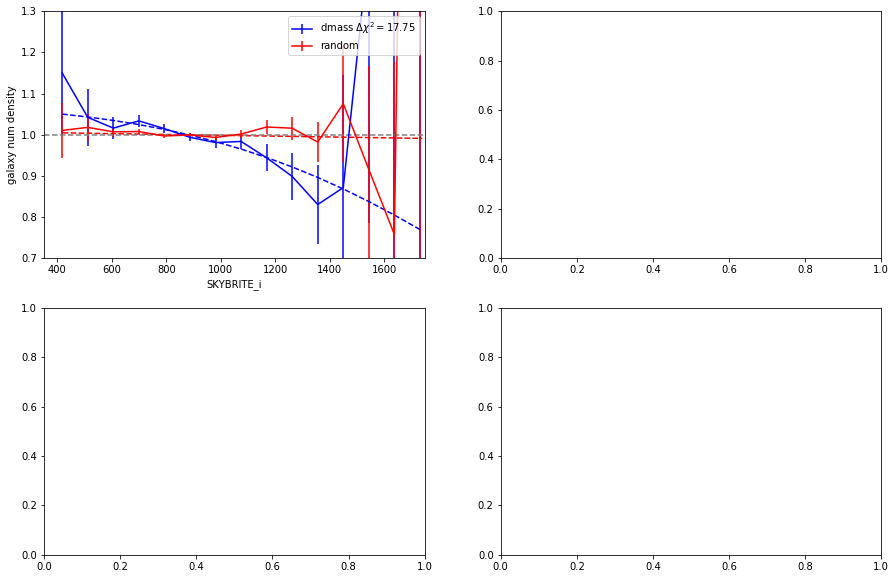

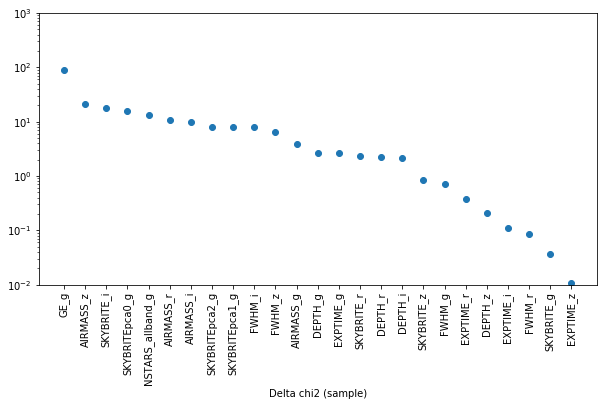

In [166]:
suffix = 'wg_fwhm_r'

filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITEpca0','SKYBRITEpca1','SKYBRITEpca2'], filter= ['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)


In [167]:
all_weight = weightDic['noweight'] * weightDic['FWHM_r']
suffix = 'wg_fwhm_r'
nextweight = 'AIRMASS_z'

In [84]:
#os.system('cp ../data_txt/systematics/4th/systematic*_wg_fwhm_r_airmass_z.txt '+inputdir+'/.')

0

----------------------------------
initialize function  AIRMASS_z
linear
store weight  AIRMASS_z
save weight to fits ../data_txt/systematics/5th//weights/wg_airmass_z_SPT.fits
suffix =  wg_fwhm_r_airmass_z
saving data to  ../data_txt/systematics/5th/systematic_SKYBRITEpca0_g_SPT_wg_fwhm_r_airmass_z.txt
saving data to  ../data_txt/systematics/5th/systematic_SKYBRITEpca1_g_SPT_wg_fwhm_r_airmass_z.txt
saving data to  ../data_txt/systematics/5th/systematic_SKYBRITEpca2_g_SPT_wg_fwhm_r_airmass_z.txt


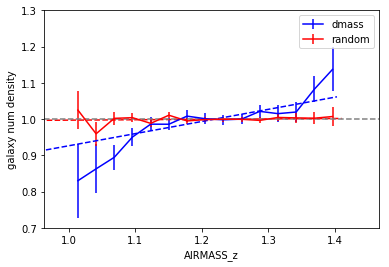

In [168]:
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties_pca, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  7.467749086625962
chi2_mod. =  4.998430540634316
Delta chi2 (sample) = 2.469318545991646
output save to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z.txt.model

chi2_null =  6.375981047629544
chi2_mod. =  2.7186743855950053
Delta chi2 (sample) = 3.657306662034539
output save to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z.txt.model

chi2_null =  4.444543782289693
chi2_mod. =  2.532159840448956
Delta chi2 (sample) = 1.9123839418407371
output save to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z.txt.model

chi2_null =  7.062997597765654
chi2_mod. =  6.584770665915236
Delta chi2 (sample) = 0.4782269318504184
output save to  ../data_txt/systematics/5th/systematic_DEPTH_z_SPT_wg_fwhm_r_airmass_z.txt.model

chi2_null =  7.742171483488454
chi2_mod. =  4.886267878559274
Delta chi2 (sample) = 2.8559036049291793
output save to  ../data_txt/systematics/5th/systematic_EXPTIME_g_SPT_wg_fwhm_r_airmass_z.txt.m

(['GE_g',
  'AIRMASS_i',
  'AIRMASS_r',
  'NSTARS_allband_g',
  'SKYBRITE_i',
  'SKYBRITEpca0_g',
  'AIRMASS_g',
  'SKYBRITEpca2_g',
  'SKYBRITEpca1_g',
  'FWHM_i',
  'FWHM_z',
  'DEPTH_r',
  'SKYBRITE_r',
  'EXPTIME_g',
  'DEPTH_g',
  'DEPTH_i',
  'SKYBRITE_z',
  'EXPTIME_r',
  'DEPTH_z',
  'AIRMASS_z',
  'FWHM_r',
  'FWHM_g',
  'SKYBRITE_g',
  'EXPTIME_z',
  'EXPTIME_i'],
 [100.5322252383604,
  29.736433781384395,
  28.304465983792475,
  24.995774469837833,
  24.874906867067974,
  23.19834073578256,
  13.613743417057542,
  12.17805938194796,
  12.17805938194796,
  9.952466455502194,
  4.554406208408695,
  3.657306662034539,
  3.651744413927612,
  2.8559036049291793,
  2.469318545991646,
  1.9123839418407371,
  1.1520579737377323,
  0.6654014109965019,
  0.4782269318504184,
  0.3841983704109708,
  0.2691192621408991,
  0.2649650796732015,
  0.19966221013810426,
  0.037021803717969703,
  0.0013381114397645888])

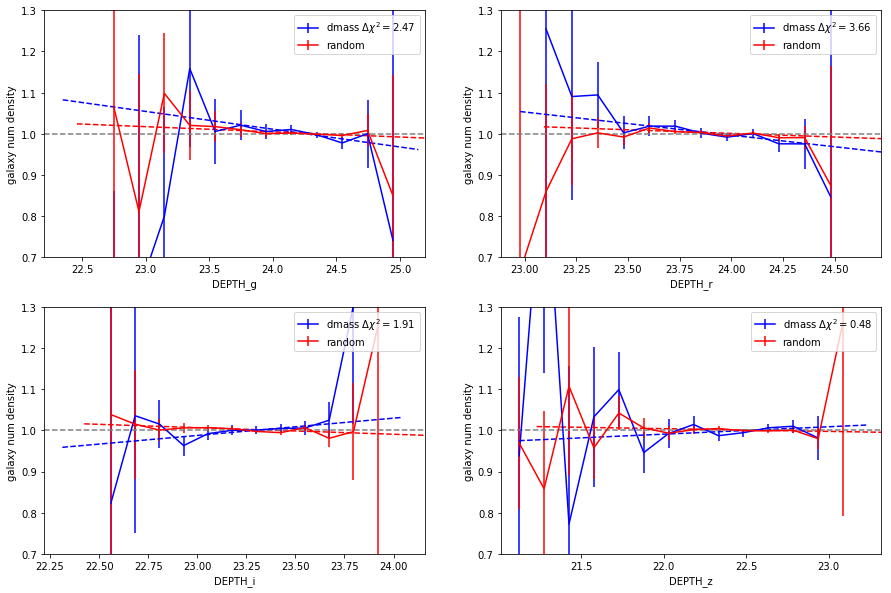

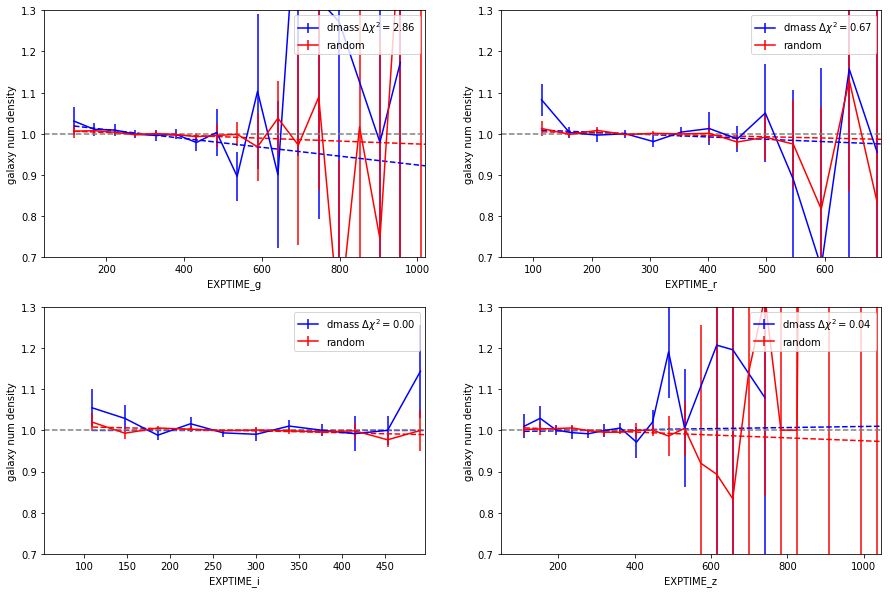

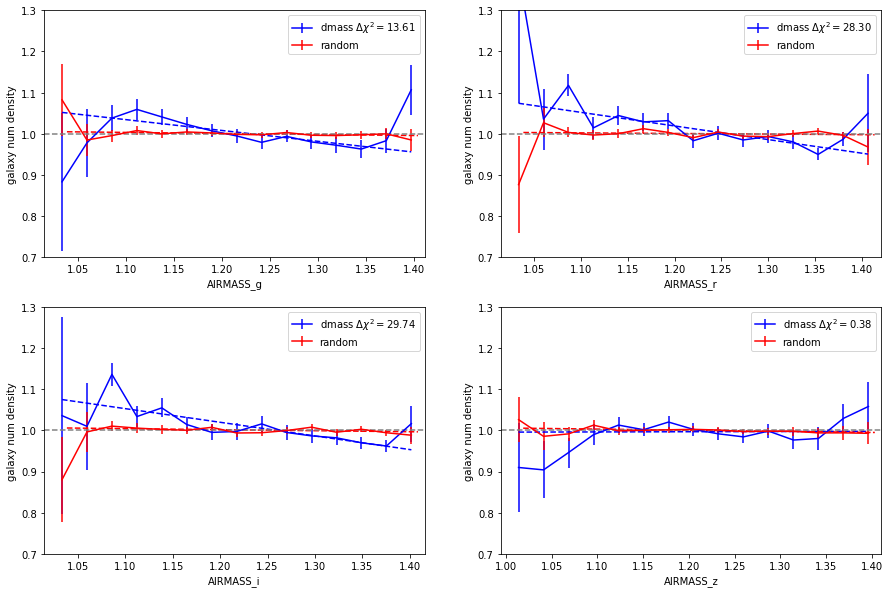

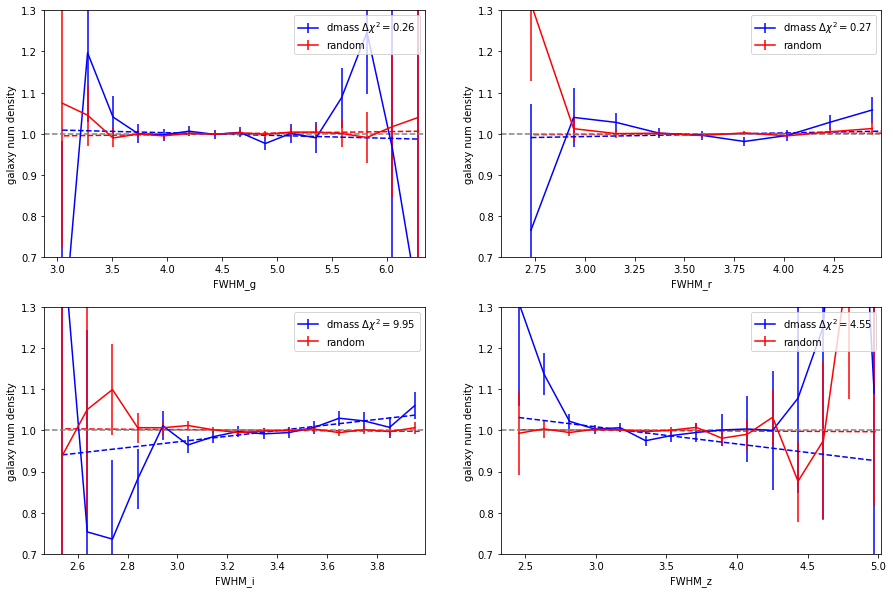

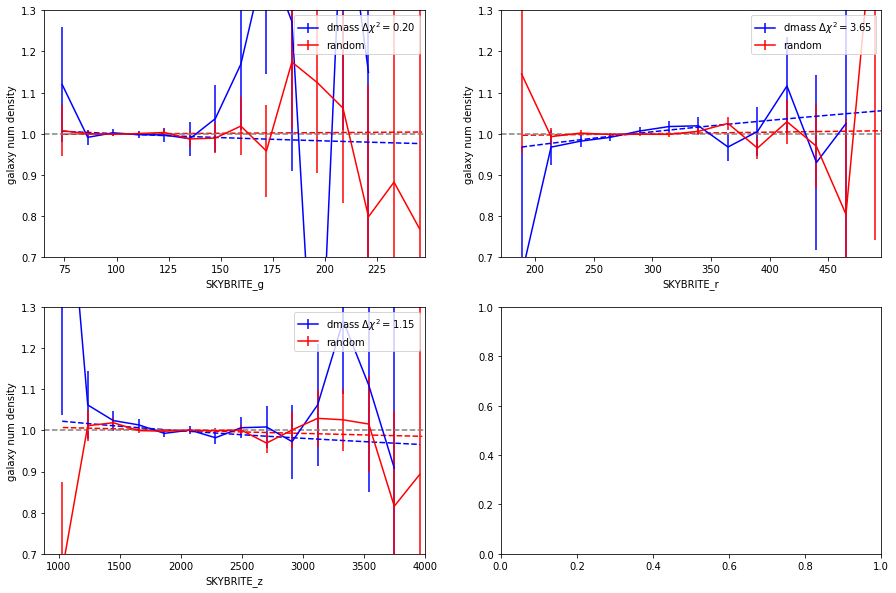

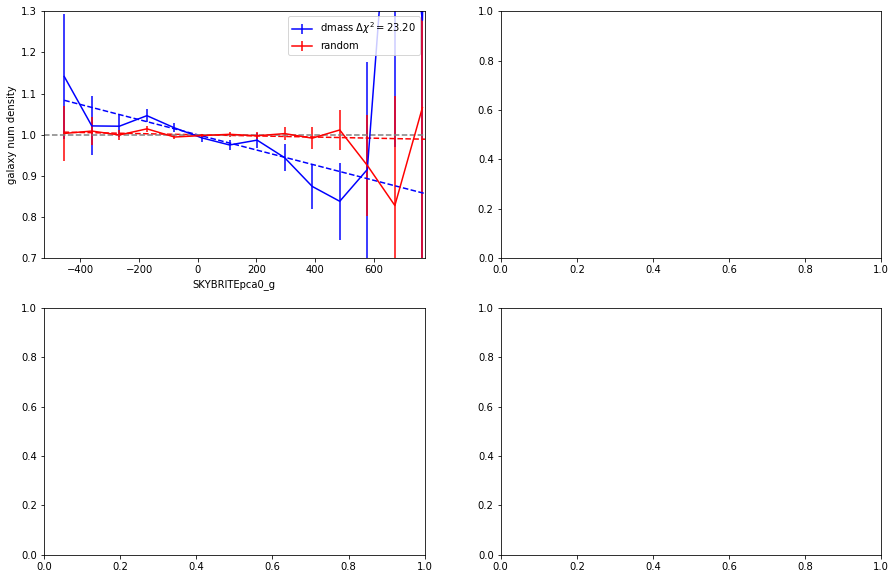

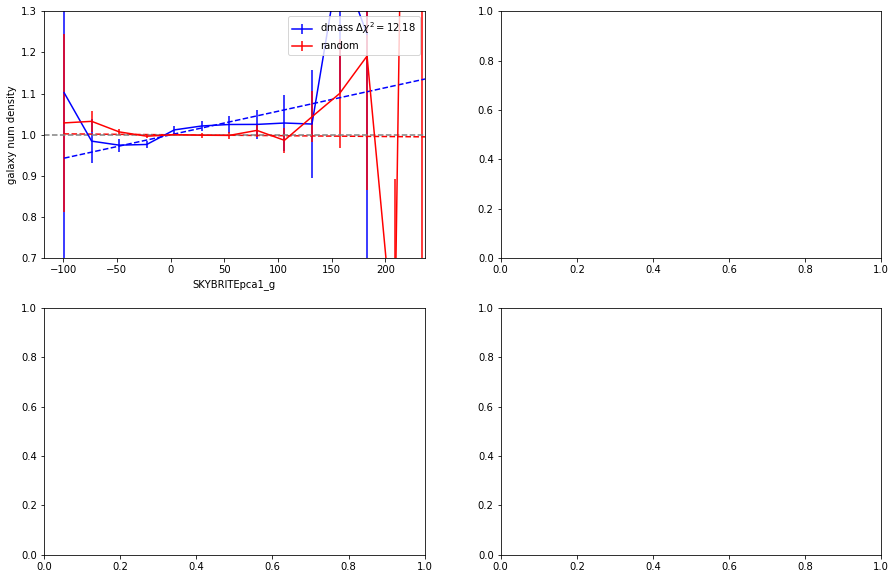

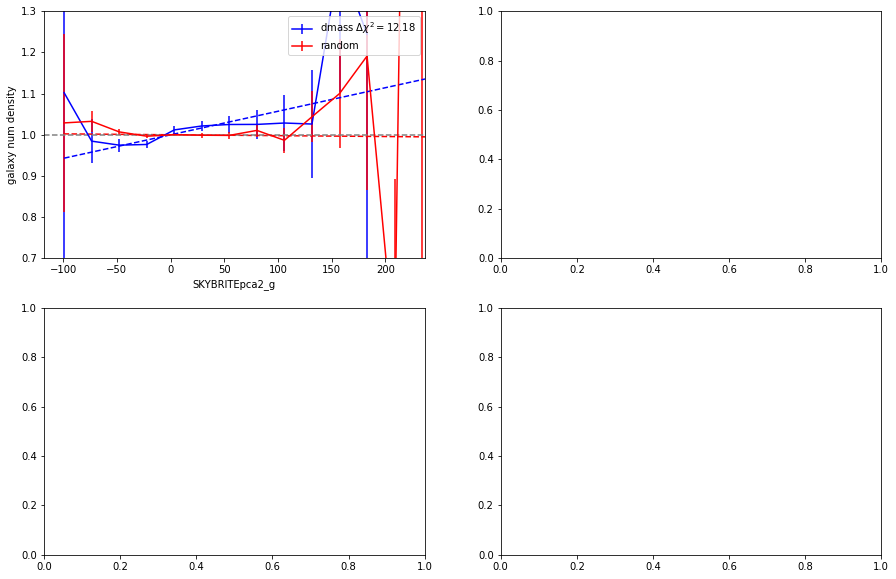

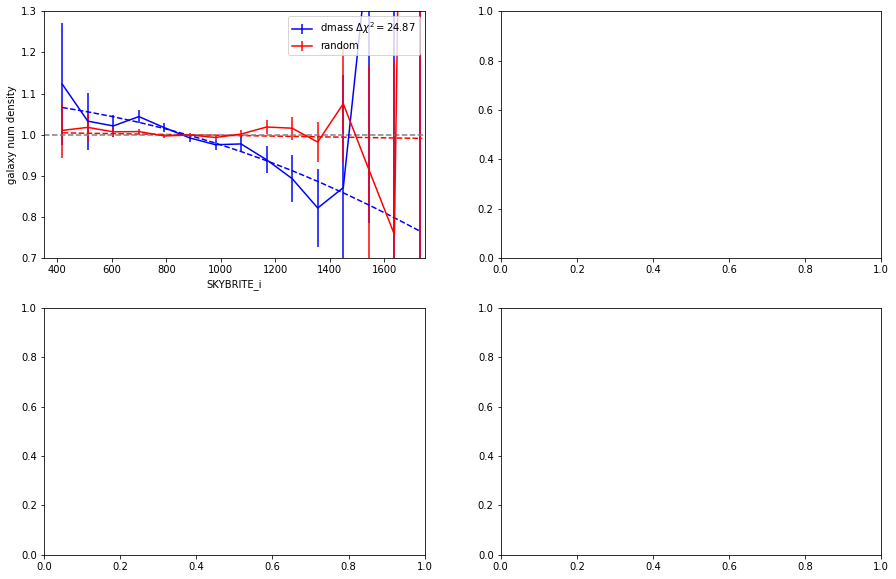

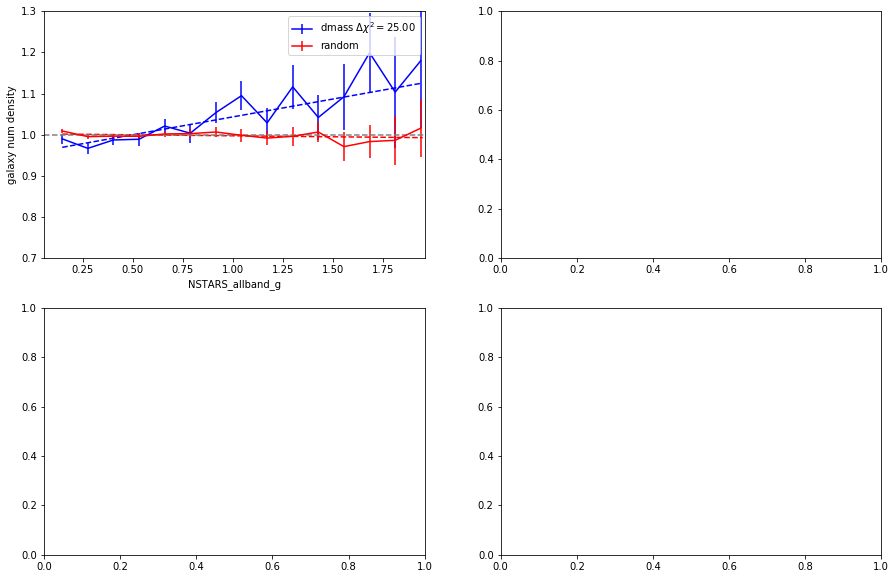

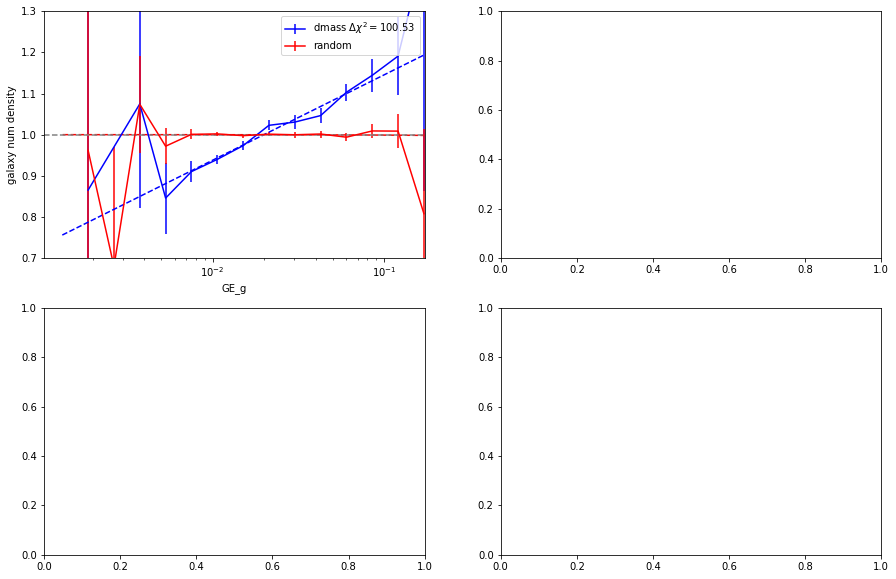

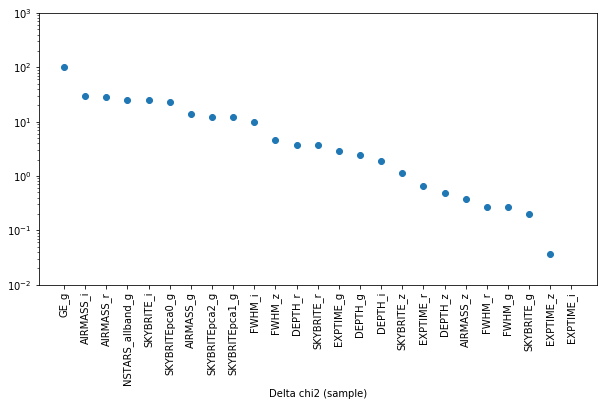

In [171]:
suffix = 'wg_fwhm_r_airmass_z'
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )
fitting_SP( property = ['SKYBRITEpca0','SKYBRITEpca1','SKYBRITEpca2'], filter= ['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)




----------------------------------
initialize function  AIRMASS_i
linear
store weight  AIRMASS_i
save weight to fits ../data_txt/systematics/5th//weights/wg_airmass_i_SPT.fits
suffix =  wg_fwhm_r_airmass_z_airmass_i
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_z_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_EXPTIME_g_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_EXPTIME_r_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_EXPTIME_i_SPT_wg_fwhm_r_airmass_z_airmass_i.txt


../systematics.py:451: RuntimeWarning: divide by zero encountered in divide
  Ngal_avg = Ngal *1./Nrand


saving data to  ../data_txt/systematics/5th/systematic_EXPTIME_z_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_AIRMASS_g_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_AIRMASS_r_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_AIRMASS_i_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_AIRMASS_z_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_SKYBRITE_g_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_SKYBRITE_r_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_SKYBRITE_i_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_SKYBRITE_z_SPT_wg_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/5th/systematic_FWHM_g_SPT_wg_

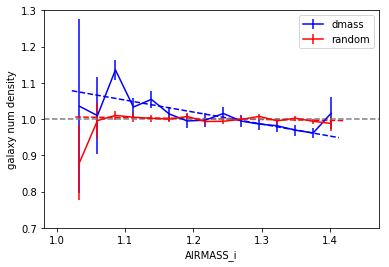

In [172]:
all_weight = weightDic['noweight'] * weightDic['FWHM_r'] * weightDic['AIRMASS_z']
suffix = 'wg_fwhm_r_airmass_z'
nextweight = 'AIRMASS_i'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  5.331384329563718
chi2_mod. =  3.7364994845248107
Delta chi2 (sample) = 1.5948848450389077
output save to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_airmass_i.txt.model

chi2_null =  4.786748984768417
chi2_mod. =  3.1613601414564743
Delta chi2 (sample) = 1.625388843311943
output save to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_airmass_i.txt.model

chi2_null =  3.69934024717991
chi2_mod. =  2.965293694484901
Delta chi2 (sample) = 0.7340465526950091
output save to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z_airmass_i.txt.model

chi2_null =  6.992588498948229
chi2_mod. =  6.939806478951999
Delta chi2 (sample) = 0.05278201999623011
output save to  ../data_txt/systematics/5th/systematic_DEPTH_z_SPT_wg_fwhm_r_airmass_z_airmass_i.txt.model

chi2_null =  5.602040577567945
chi2_mod. =  4.3613156316283535
Delta chi2 (sample) = 1.2407249459395917
output save to  ../data_txt/systematics/5th/systema

(['GE_g',
  'NSTARS_allband_g',
  'SKYBRITE_i',
  'SKYBRITEpca2_g',
  'SKYBRITEpca1_g',
  'SKYBRITEpca0_g',
  'AIRMASS_z',
  'SKYBRITE_r',
  'FWHM_z',
  'FWHM_i',
  'FWHM_g',
  'AIRMASS_r',
  'DEPTH_r',
  'DEPTH_g',
  'EXPTIME_g',
  'SKYBRITE_g',
  'DEPTH_i',
  'EXPTIME_i',
  'AIRMASS_g',
  'EXPTIME_z',
  'SKYBRITE_z',
  'EXPTIME_r',
  'DEPTH_z',
  'FWHM_r',
  'AIRMASS_i'],
 [85.00572594881893,
  11.334762769608174,
  7.643426168253562,
  6.916753134201663,
  6.916753134201663,
  4.650310558395542,
  3.863605162564422,
  3.63997456760217,
  3.1856746532992926,
  2.8659576573871393,
  2.2258237654437316,
  1.67677391013083,
  1.625388843311943,
  1.5948848450389077,
  1.2407249459395917,
  1.211554569302315,
  0.7340465526950091,
  0.33892522894454213,
  0.2708242668694254,
  0.17668786794423763,
  0.16981573042157638,
  0.10890112347905401,
  0.05278201999623011,
  0.05071016570563103,
  0.02394391559166742])

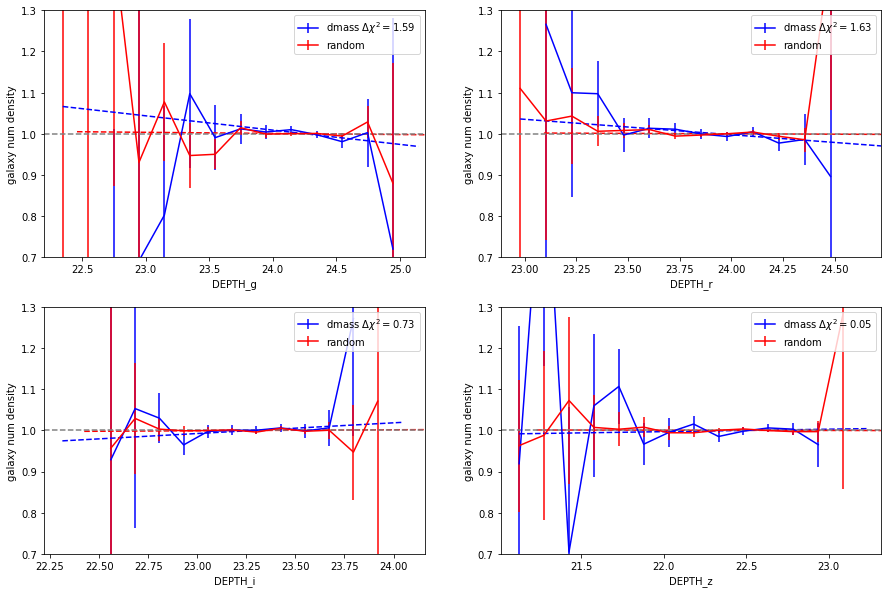

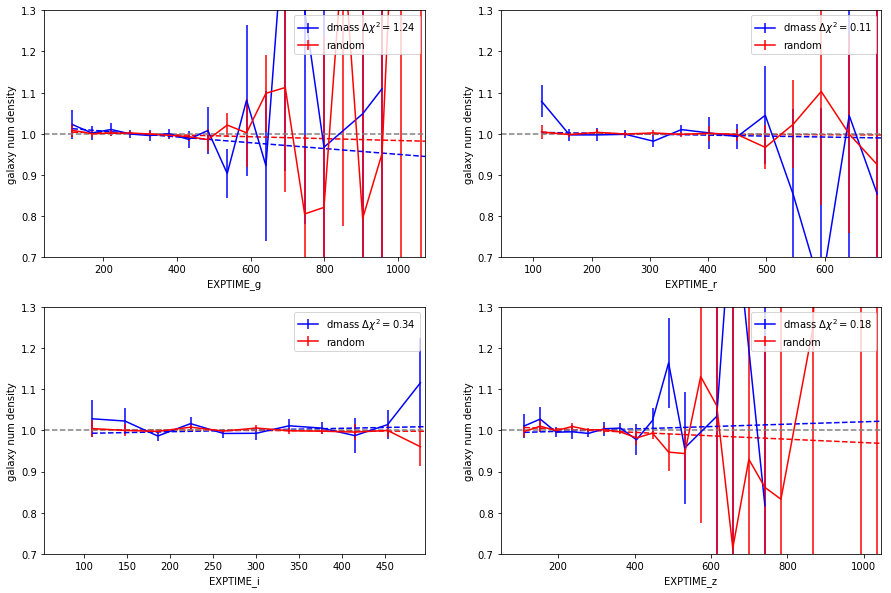

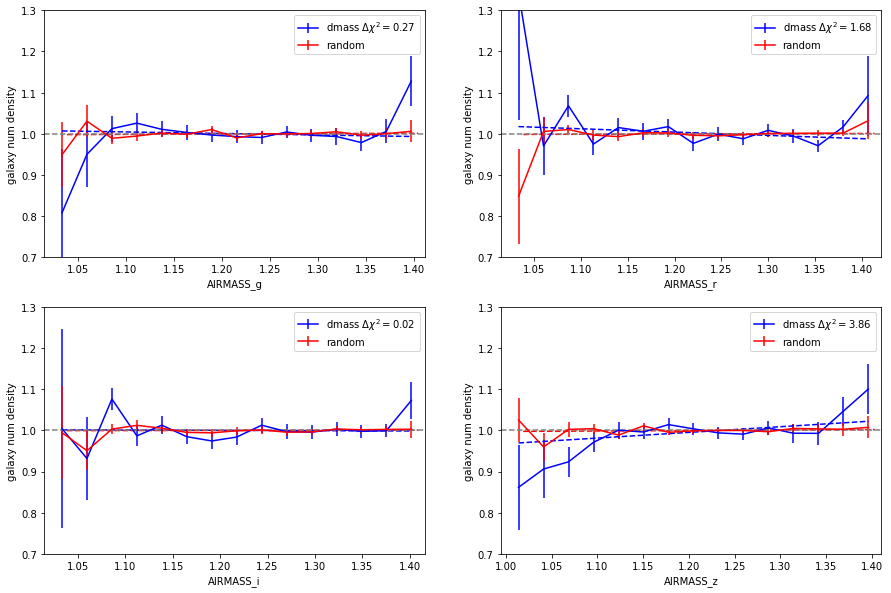

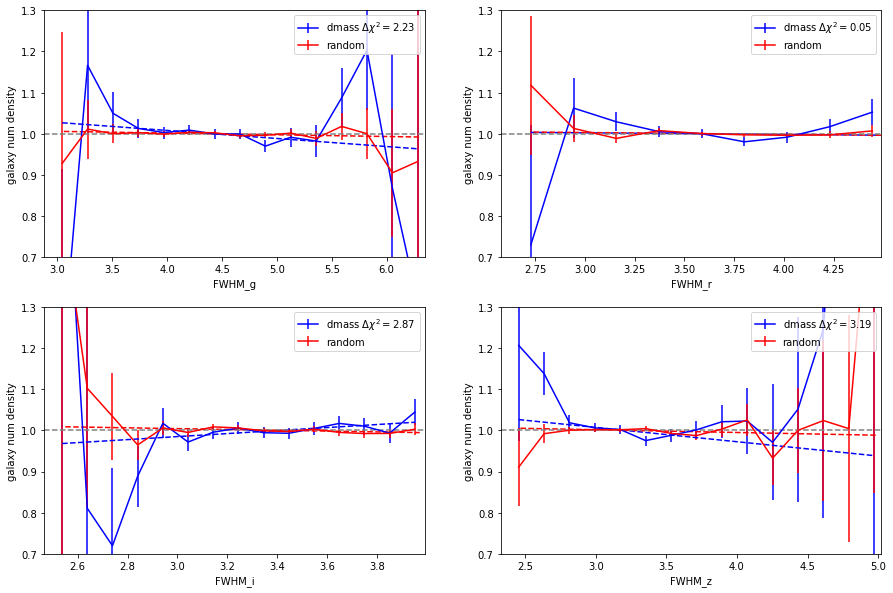

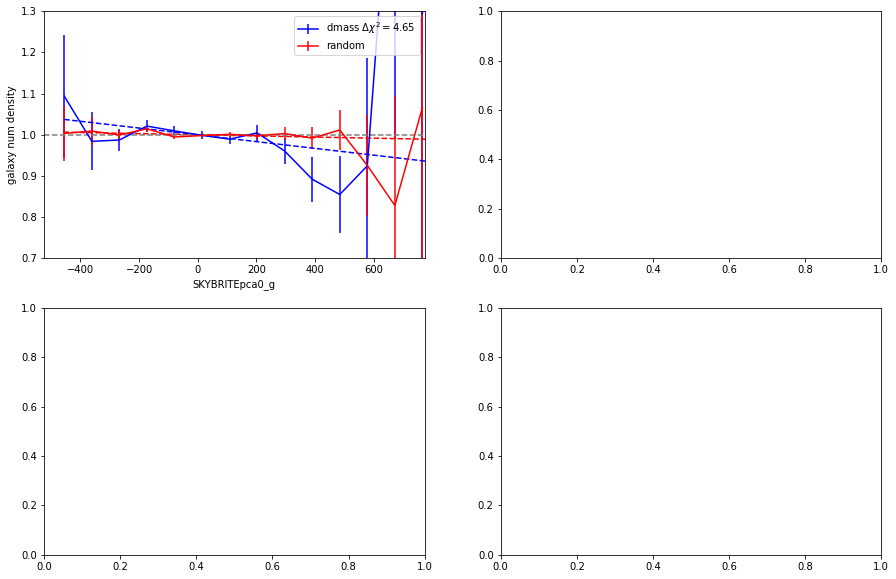

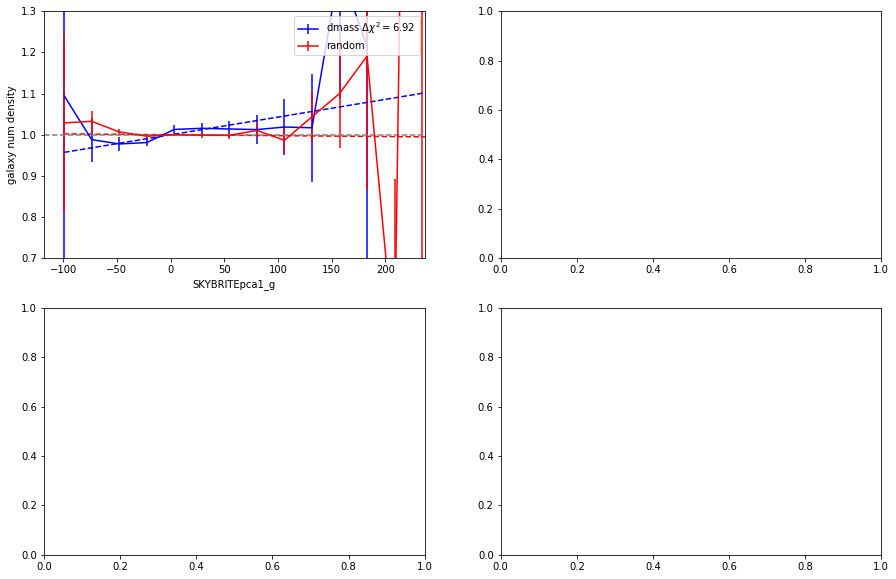

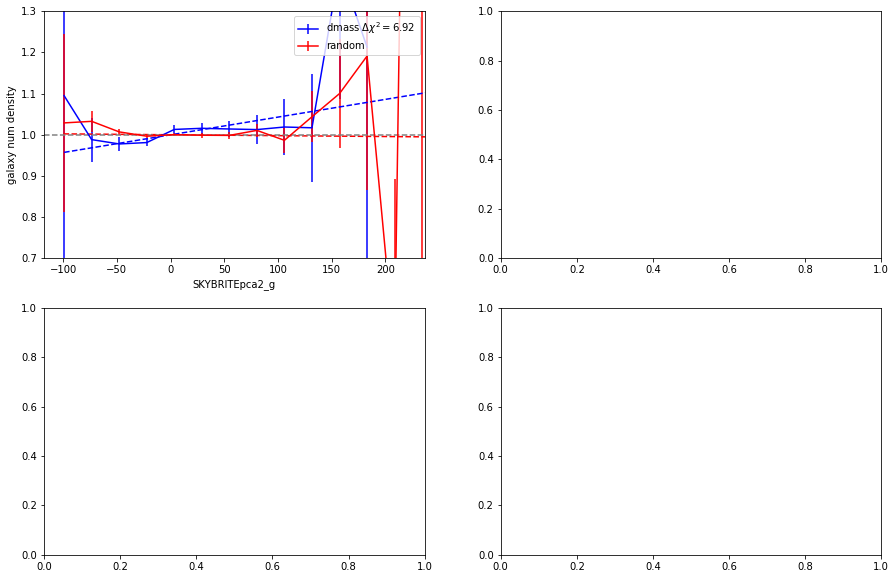

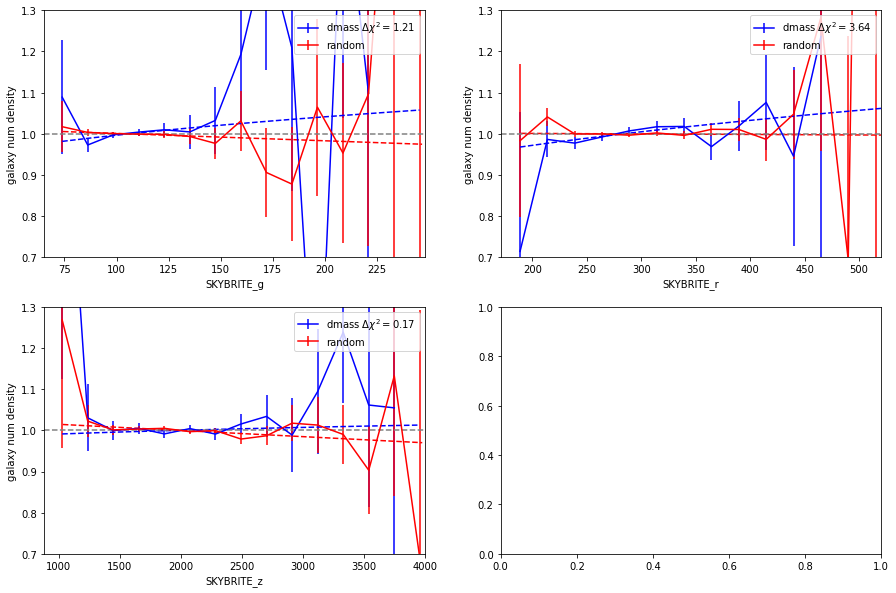

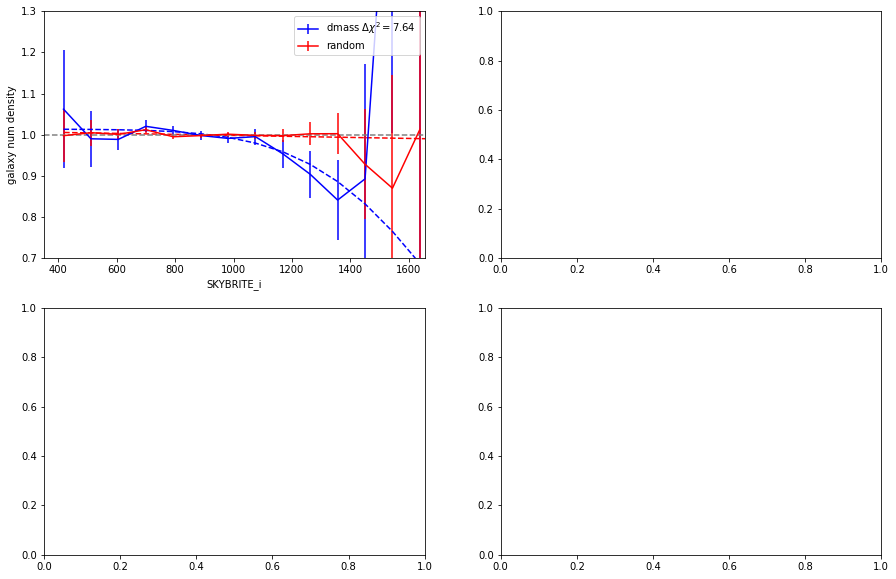

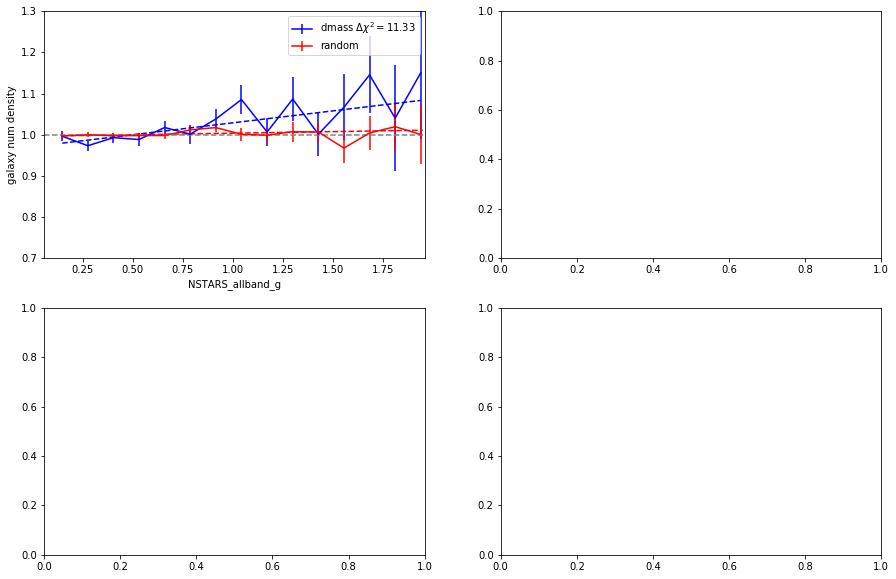

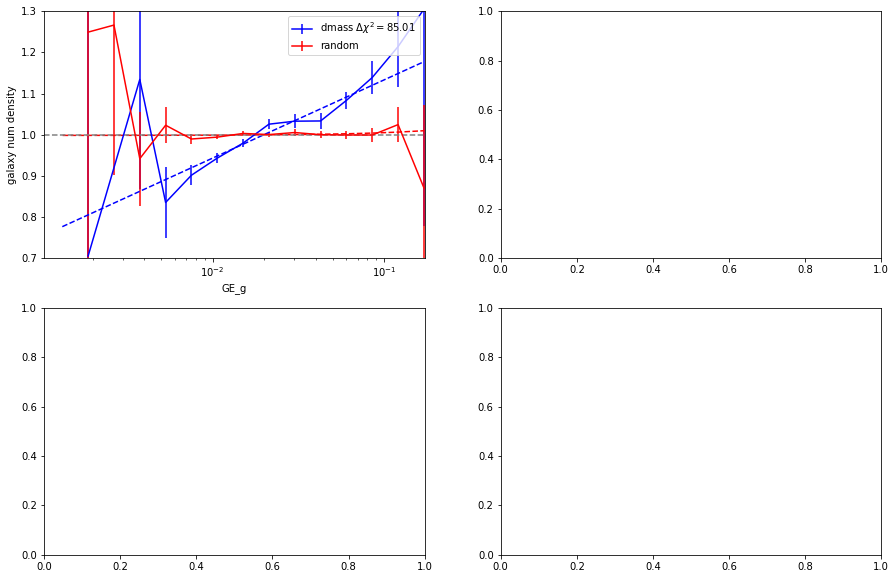

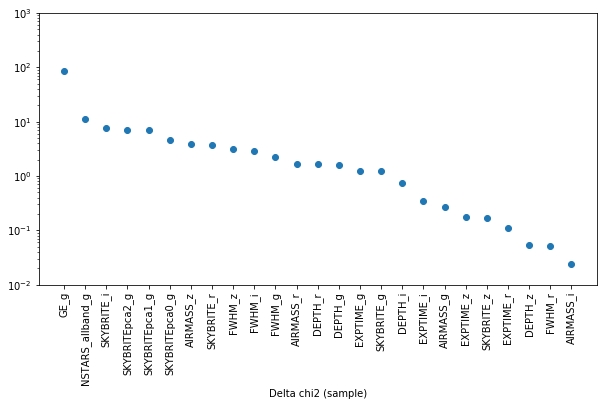

In [175]:
suffix = 'wg_fwhm_r_airmass_z_airmass_i'
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITEpca0','SKYBRITEpca1', 'SKYBRITEpca2'], filter= ['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)






In [176]:
suffix

'wg_fwhm_r_airmass_z_airmass_i'

['noweight', 'AIRMASS_z', 'AIRMASS_i', 'FWHM_r']
noweight
AIRMASS_z
AIRMASS_i
FWHM_r
----------------------------------
initialize function  NSTARS_allband_g
linear
store weight  NSTARS_allband_g
save weight to fits ../data_txt/systematics/5th//weights/wg_nstars_allband_g_SPT.fits
suffix =  wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_z_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g.txt
saving data to  ../data_txt/systematics/5th/systematic_EXPTIME_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g.txt
saving data to  ../data_txt/systematics/5th/systematic_EXPTIME_r_SPT_

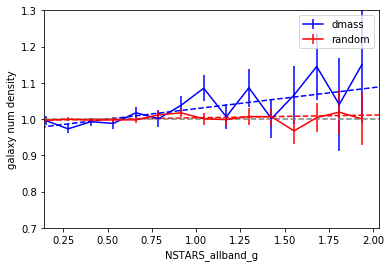

In [177]:
all_weight = weightmultiply( weightDic )
#suffix = 'wg_fwhm_r_airmass_z_skybritepca0_g'
nextweight = 'NSTARS_allband_g'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  4.7177375278077305
chi2_mod. =  4.281532039847529
Delta chi2 (sample) = 0.4362054879602013
output save to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g.txt.model

chi2_null =  4.000351174902468
chi2_mod. =  3.9739929989969394
Delta chi2 (sample) = 0.02635817590552847
output save to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g.txt.model

chi2_null =  10.601408749920838
chi2_mod. =  3.0617426570537862
Delta chi2 (sample) = 7.539666092867051
output save to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g.txt.model

chi2_null =  9.149723654869067
chi2_mod. =  6.629094046944671
Delta chi2 (sample) = 2.5206296079243966
output save to  ../data_txt/systematics/5th/systematic_DEPTH_z_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g.txt.model

chi2_null =  4.64544435695077
chi2_mod. =  4.3249872834642655
Delta chi2 (sample) = 

(['GE_g',
  'SKYBRITE_i',
  'SKYBRITEpca0_g',
  'DEPTH_i',
  'SKYBRITEpca2_g',
  'SKYBRITEpca1_g',
  'EXPTIME_i',
  'FWHM_z',
  'DEPTH_z',
  'AIRMASS_z',
  'FWHM_g',
  'AIRMASS_r',
  'FWHM_i',
  'EXPTIME_z',
  'SKYBRITE_r',
  'DEPTH_g',
  'EXPTIME_r',
  'EXPTIME_g',
  'SKYBRITE_g',
  'SKYBRITE_z',
  'AIRMASS_g',
  'FWHM_r',
  'AIRMASS_i',
  'DEPTH_r',
  'NSTARS_allband_g'],
 [96.36099144673426,
  16.799899100598612,
  10.879428810370095,
  7.539666092867051,
  3.9858892118561853,
  3.9858892118561853,
  3.7441699845990035,
  2.686410850263762,
  2.5206296079243966,
  2.3549822980290536,
  2.2443625132504845,
  2.1303102578478956,
  1.9439836855390418,
  1.922639576315695,
  0.9746477454647815,
  0.4362054879602013,
  0.3923221596037916,
  0.3204570734865042,
  0.2385041264472747,
  0.1624574115497328,
  0.11443312196405664,
  0.04328480436416804,
  0.04205174372733467,
  0.02635817590552847,
  0.003058558514608123])

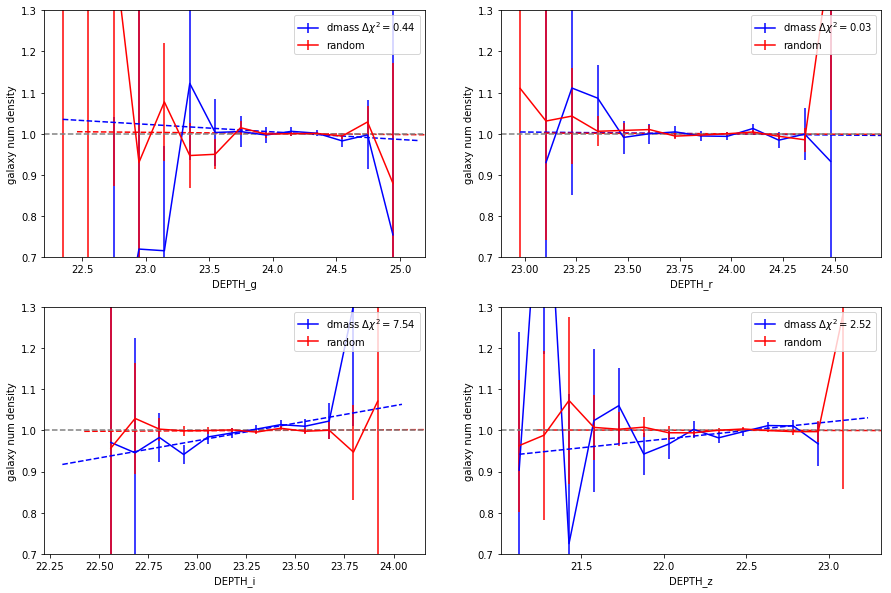

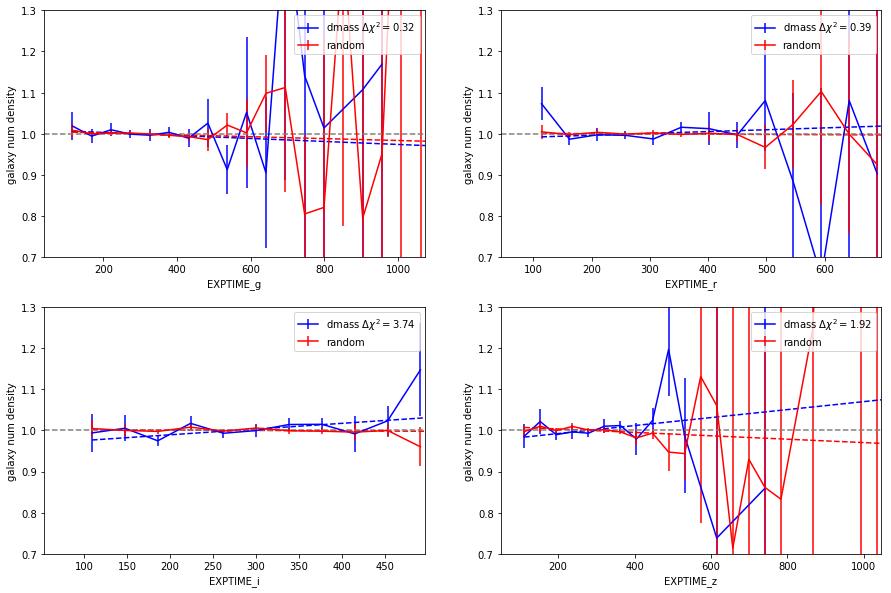

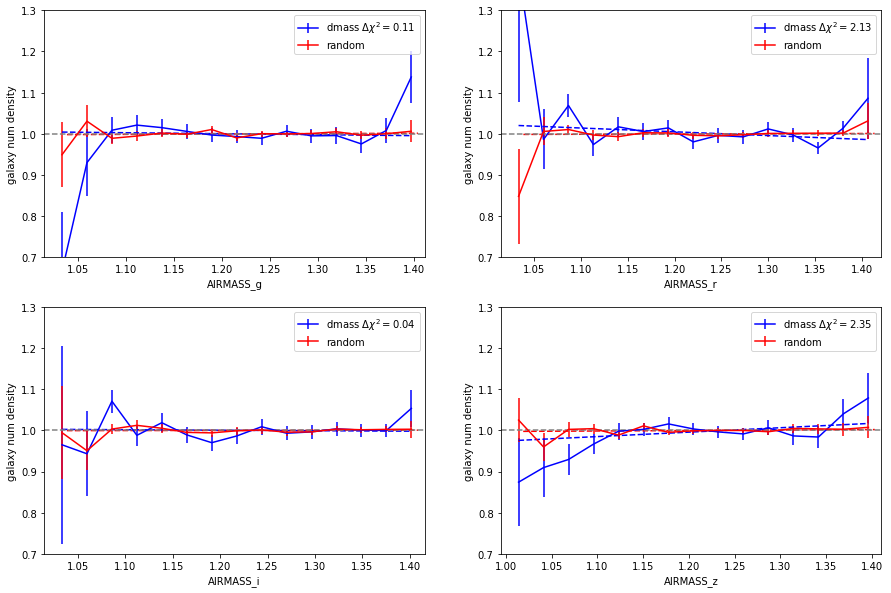

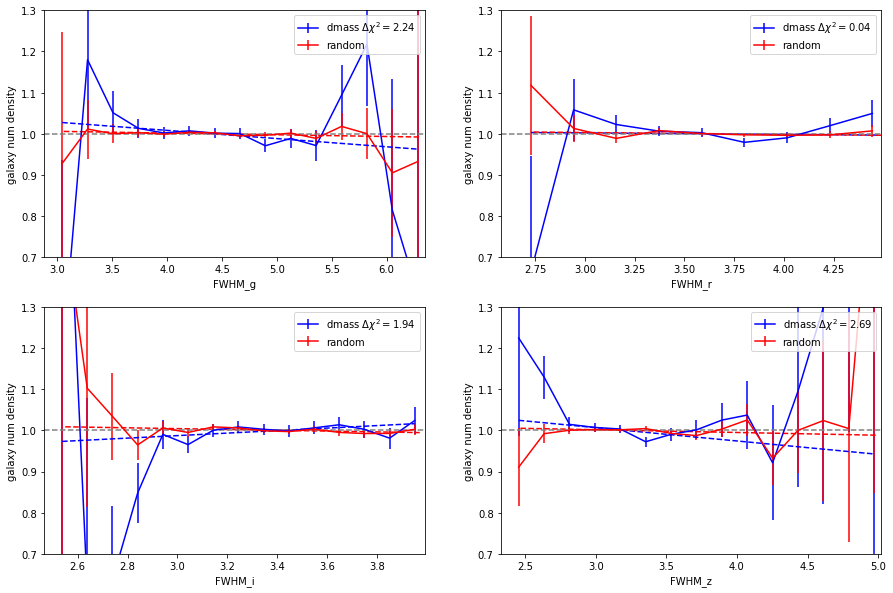

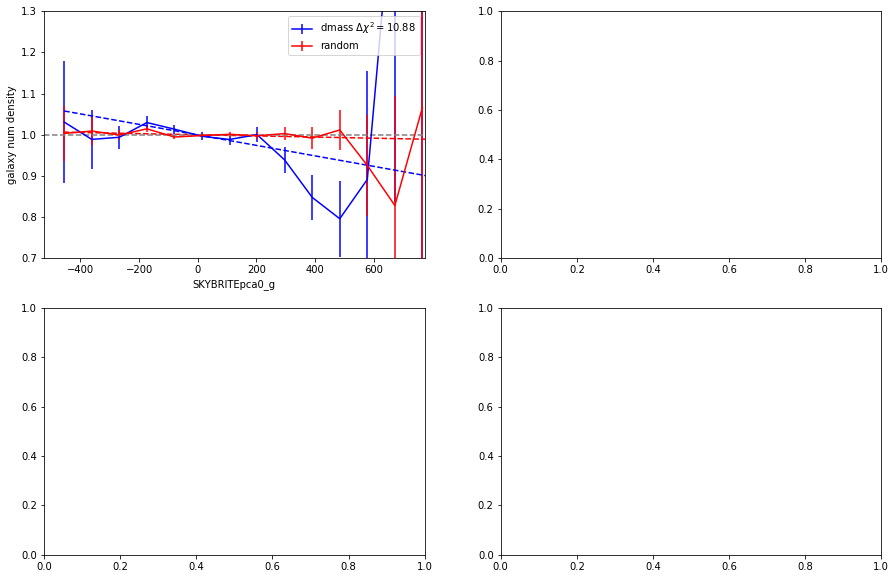

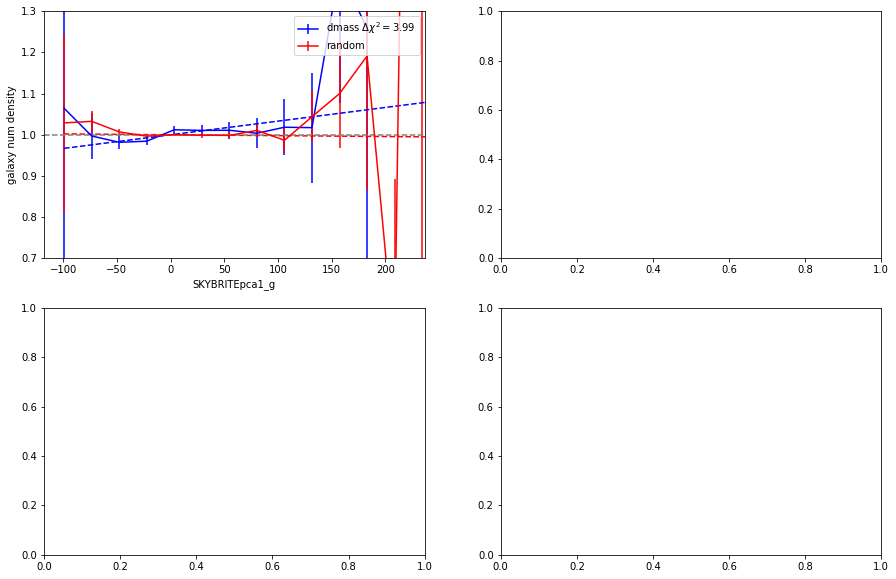

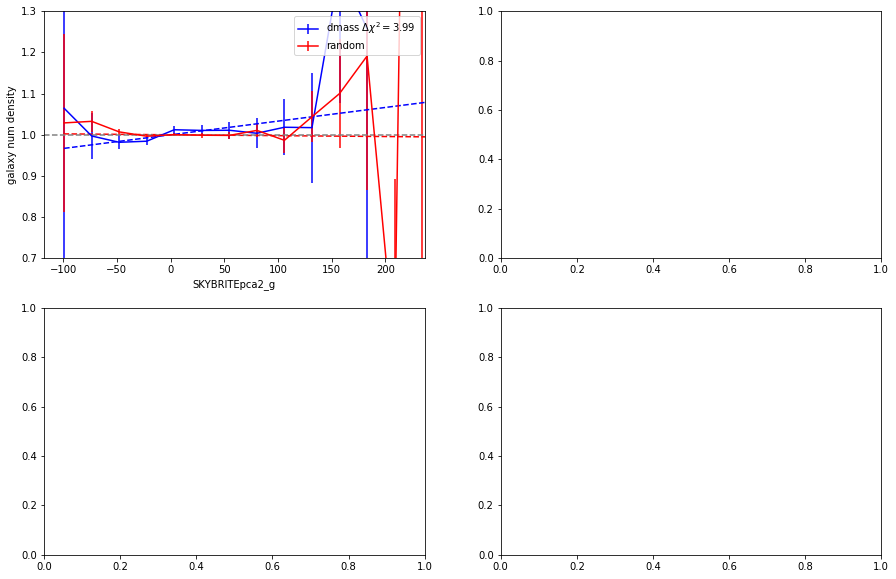

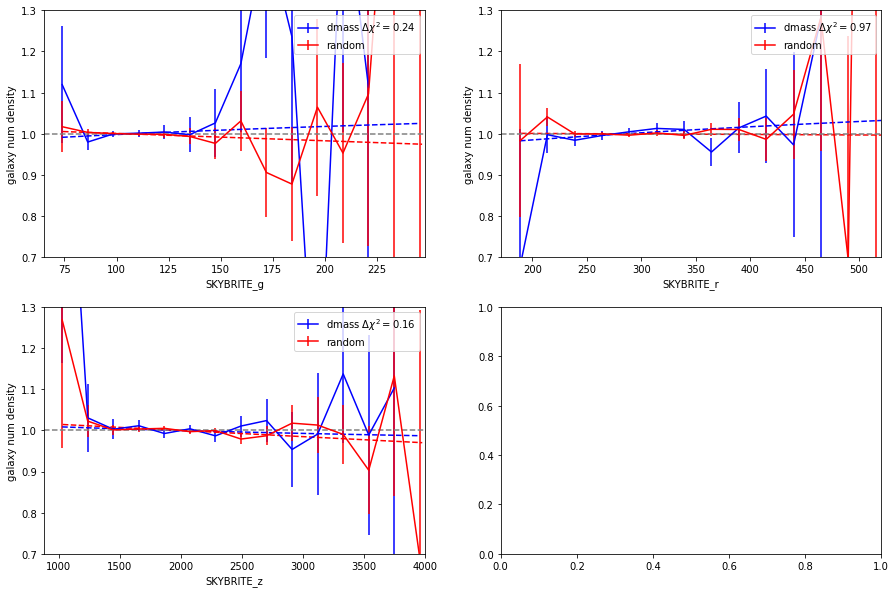

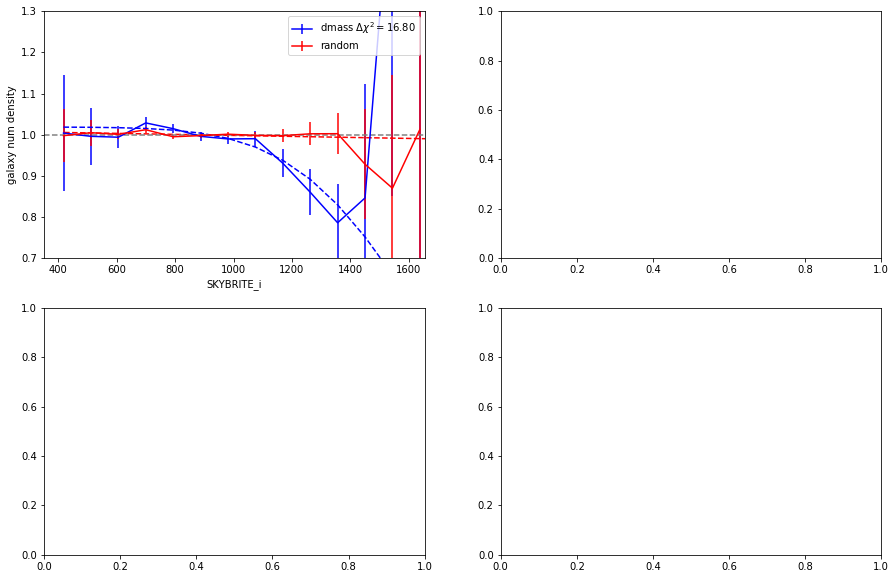

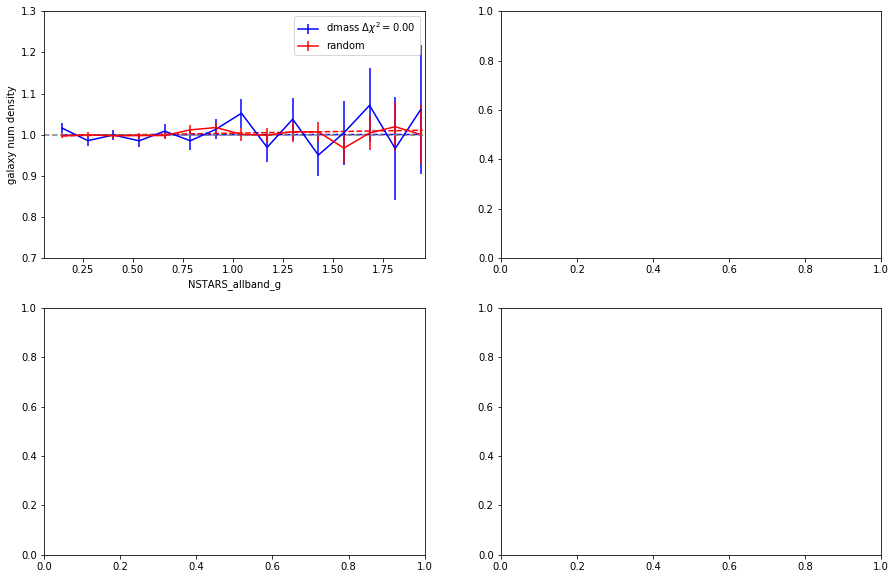

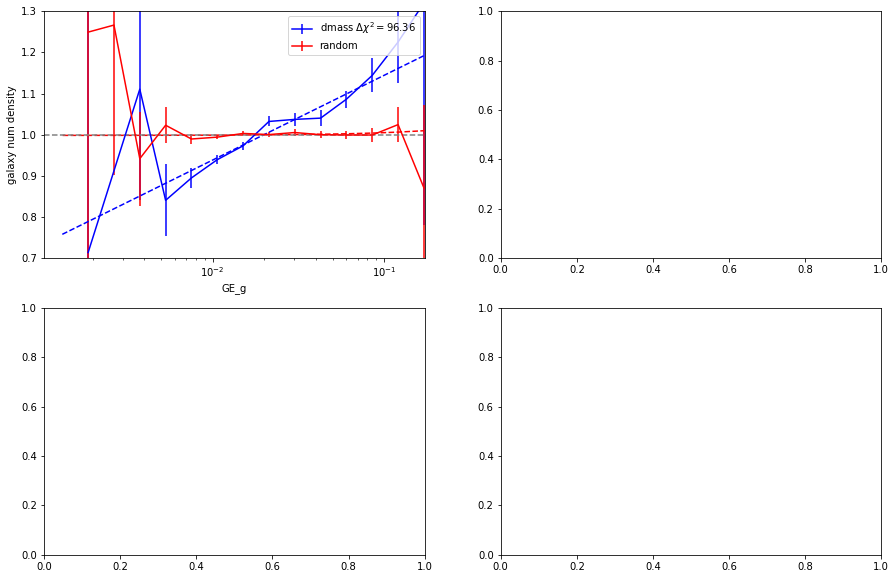

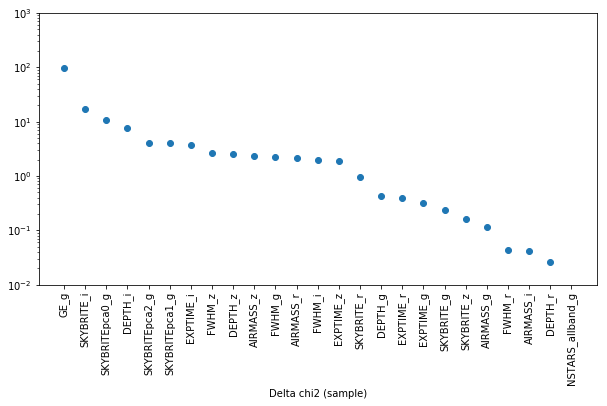

In [178]:
suffix = suffix+'_'+nextweight.lower()
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITEpca0','SKYBRITEpca1', 'SKYBRITEpca2'], filter= ['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)



['FWHM_r', 'AIRMASS_z', 'noweight', 'AIRMASS_i', 'NSTARS_allband_g']
FWHM_r
AIRMASS_z
noweight
AIRMASS_i
NSTARS_allband_g
----------------------------------
initialize function  SKYBRITEpca0_g
linear
store weight  SKYBRITEpca0_g
save weight to fits ../data_txt/systematics/5th//weights/wg_skybritepca0_g_SPT.fits
suffix =  wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_z_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g.txt
saving data to  ../data_txt/systematics/5th/systematic_EXPTIME_g_SPT_wg_fwhm_r_airm

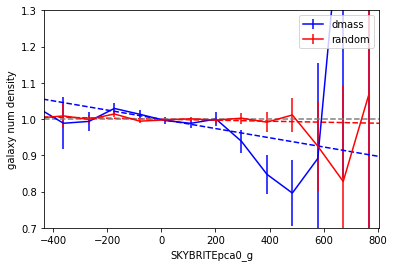

In [183]:
all_weight = weightmultiply( weightDic )
nextweight = 'SKYBRITEpca0_g'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

In [187]:
suffix='wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g'

chi2_null =  4.490967002894503
chi2_mod. =  4.225297302306356
Delta chi2 (sample) = 0.26566970058814654
output save to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g.txt.model

chi2_null =  4.069406404678038
chi2_mod. =  4.0416682934276515
Delta chi2 (sample) = 0.027738111250386055
output save to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g.txt.model

chi2_null =  5.4396009578256
chi2_mod. =  3.088676576040764
Delta chi2 (sample) = 2.3509243817848358
output save to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g.txt.model

chi2_null =  8.318031917373842
chi2_mod. =  6.478278740534417
Delta chi2 (sample) = 1.8397531768394249
output save to  ../data_txt/systematics/5th/systematic_DEPTH_z_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g.txt.model

chi2_null =  4.39041013643

(['GE_g',
  'EXPTIME_i',
  'SKYBRITEpca2_g',
  'SKYBRITEpca1_g',
  'FWHM_g',
  'AIRMASS_z',
  'SKYBRITE_r',
  'SKYBRITE_i',
  'EXPTIME_z',
  'DEPTH_i',
  'SKYBRITE_g',
  'AIRMASS_i',
  'FWHM_z',
  'DEPTH_z',
  'EXPTIME_r',
  'FWHM_i',
  'NSTARS_allband_g',
  'AIRMASS_g',
  'FWHM_r',
  'DEPTH_g',
  'SKYBRITE_z',
  'EXPTIME_g',
  'DEPTH_r',
  'SKYBRITEpca0_g',
  'AIRMASS_r'],
 [89.67063883392738,
  4.4297446191461765,
  3.778371317562268,
  3.778371317562268,
  3.6591172908008875,
  3.4206845895389115,
  3.230615273304015,
  3.1613335800880797,
  2.389524687991803,
  2.3509243817848358,
  2.142227682648315,
  1.8825384911041994,
  1.851405800419883,
  1.8397531768394249,
  0.6668416549879321,
  0.5591152678247937,
  0.536792876414923,
  0.42423200777601267,
  0.34375085494786717,
  0.26566970058814654,
  0.2284809361800786,
  0.06462811719463346,
  0.027738111250386055,
  0.021061261731608383,
  0.01480717038627688])

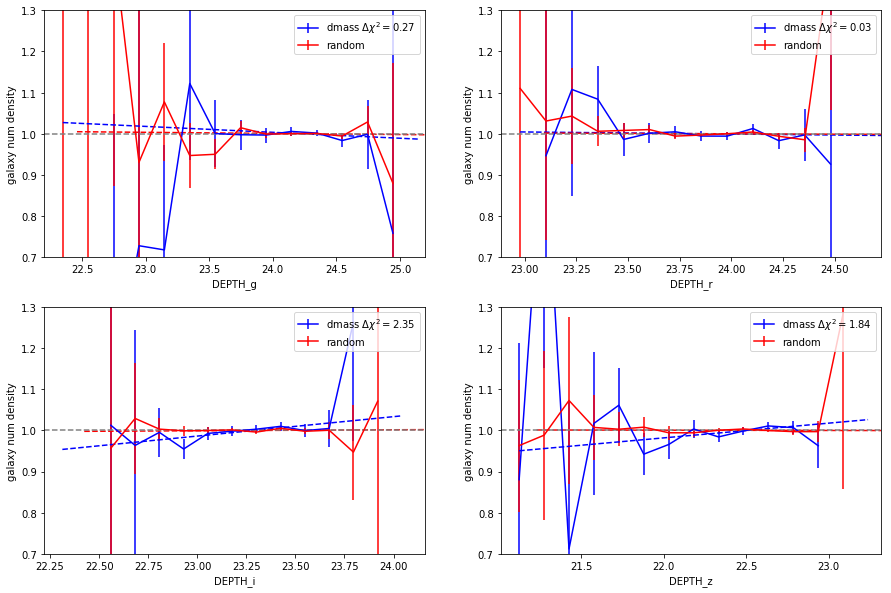

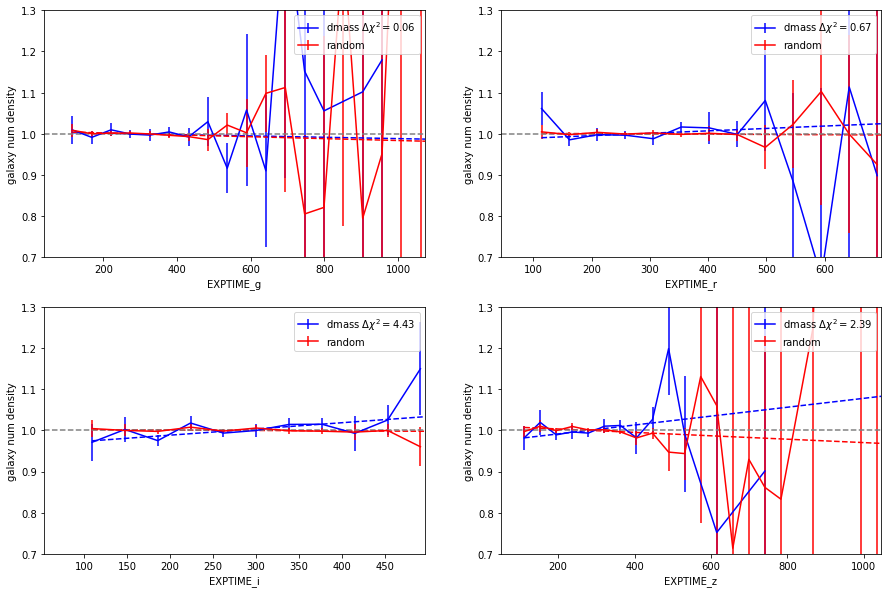

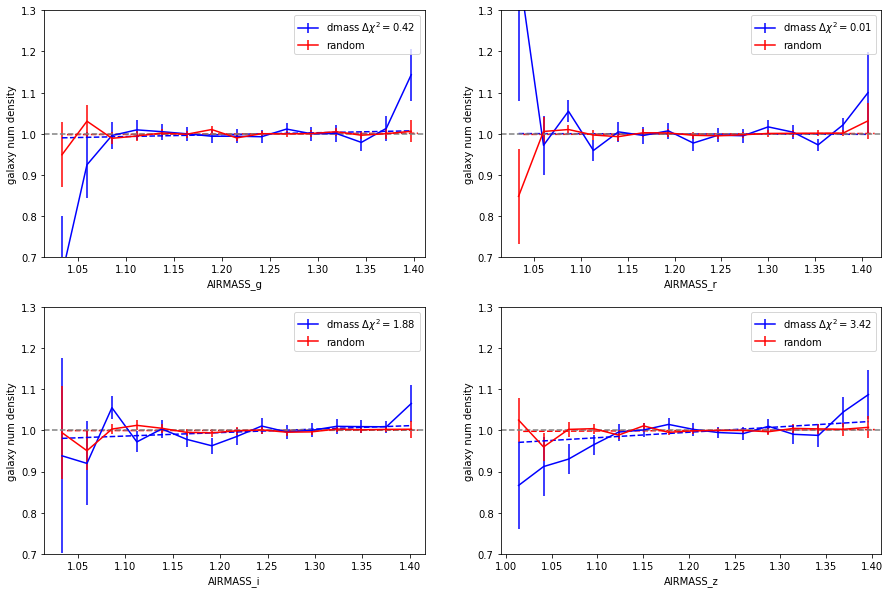

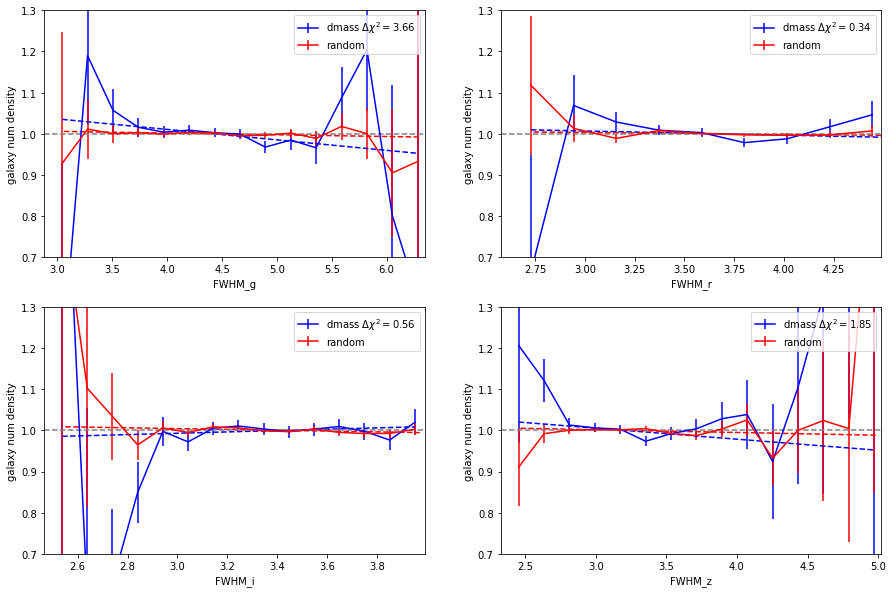

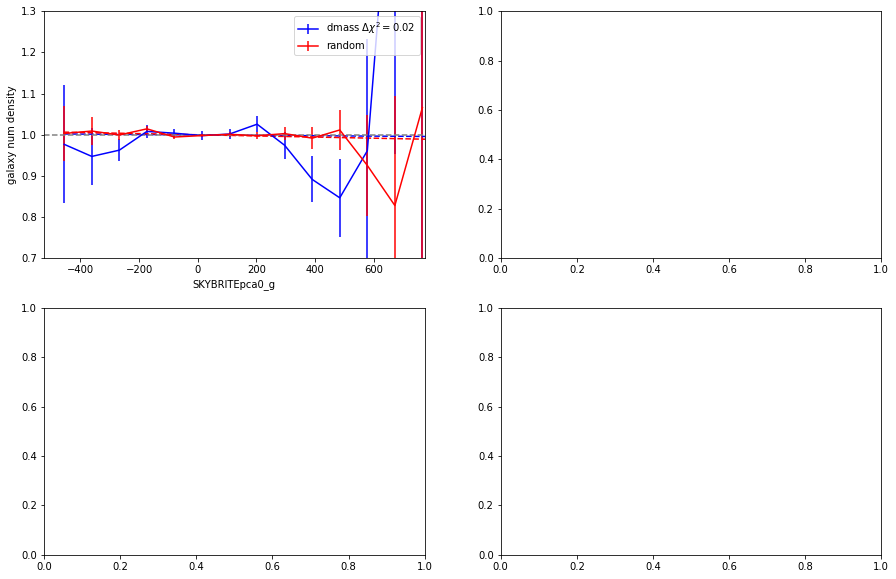

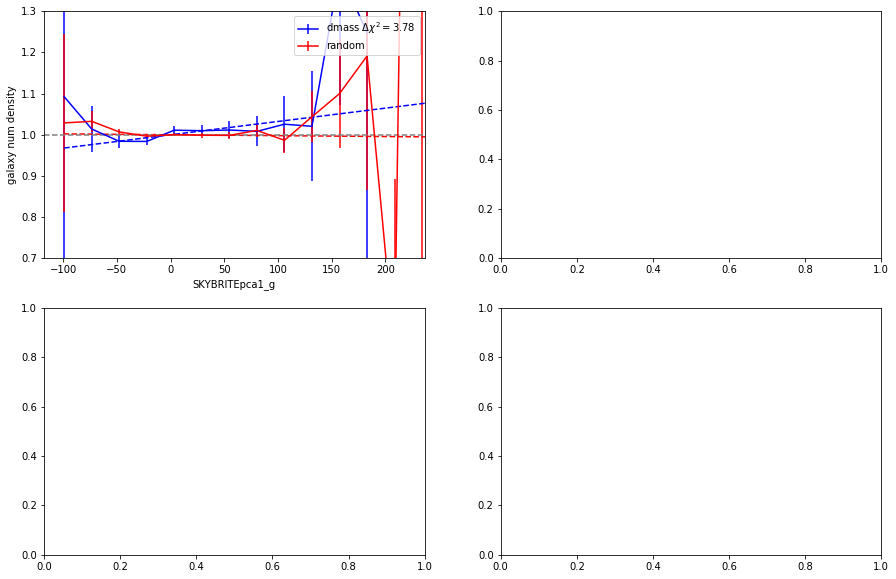

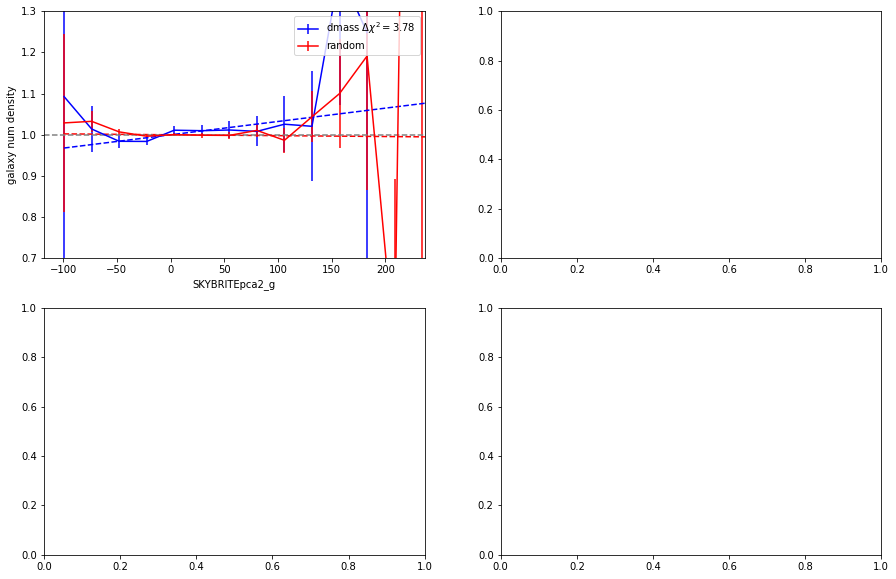

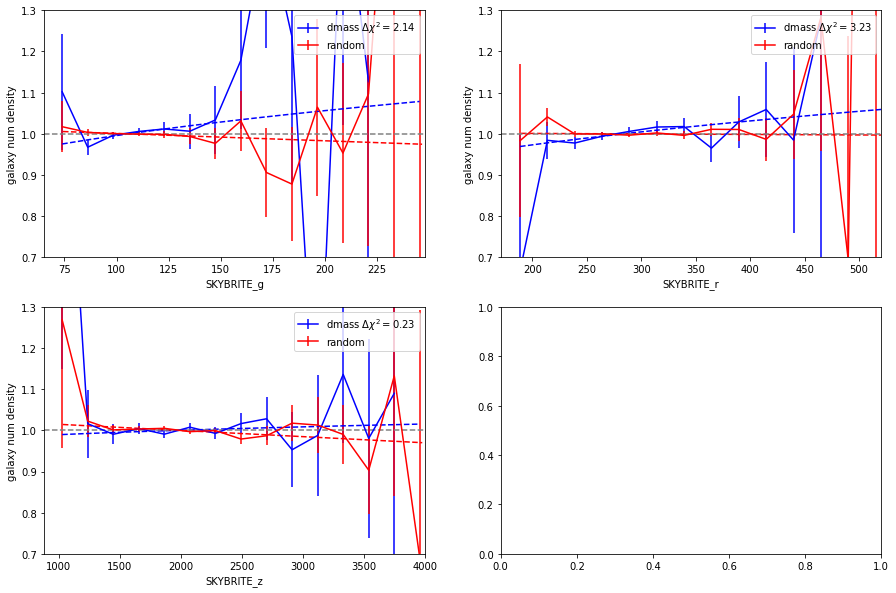

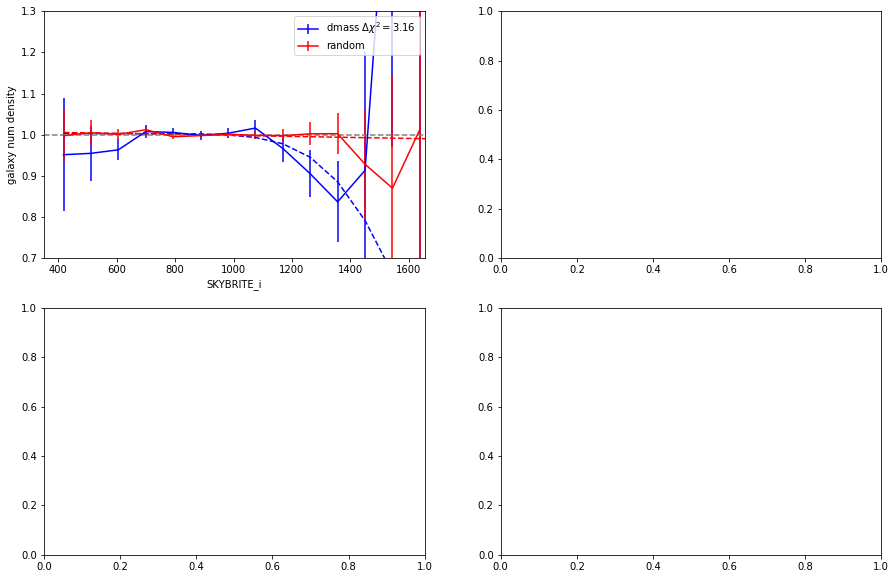

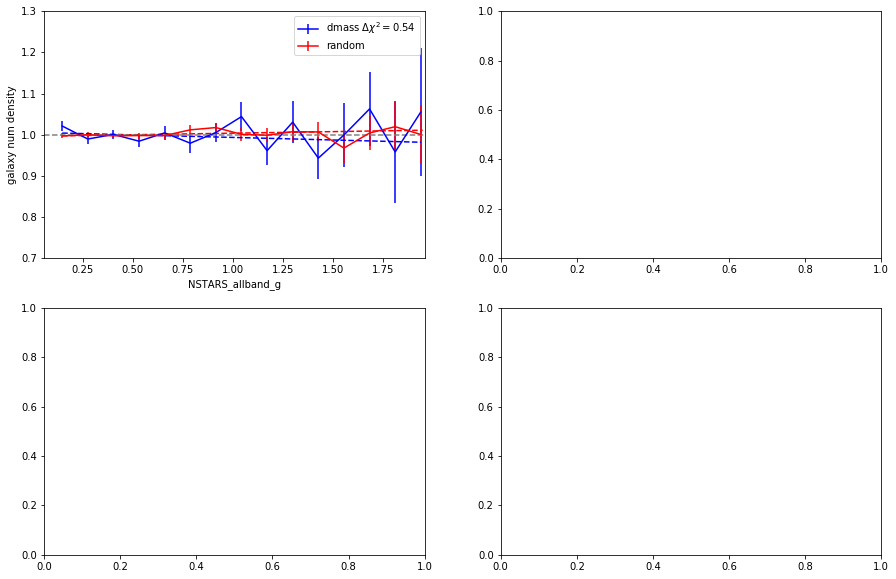

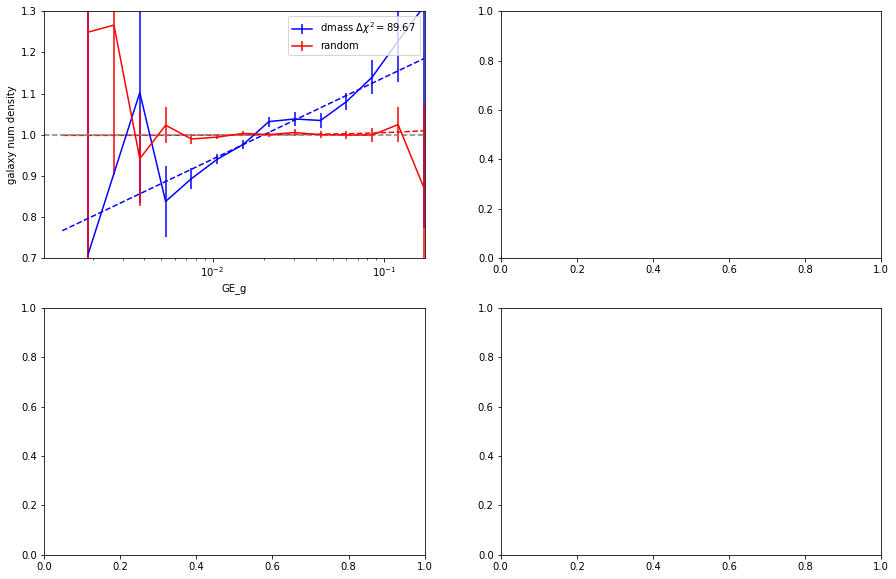

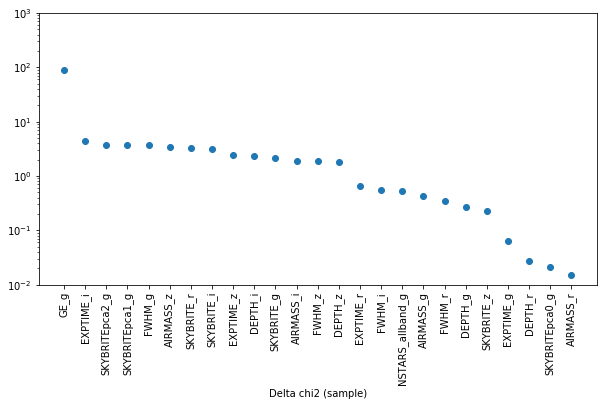

In [188]:
suffix = suffix+'_'+nextweight.lower()
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITEpca0','SKYBRITEpca1', 'SKYBRITEpca2'], filter= ['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['FWHM_r', 'AIRMASS_z', 'noweight', 'SKYBRITEpca0_g', 'AIRMASS_i', 'NSTARS_allband_g']
FWHM_r
AIRMASS_z
noweight
SKYBRITEpca0_g
AIRMASS_i
NSTARS_allband_g
----------------------------------
initialize function  EXPTIME_i
linear
store weight  EXPTIME_i
save weight to fits ../data_txt/systematics/5th//weights/wg_exptime_i_SPT.fits
suffix =  wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_z_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i.txt
saving data to 

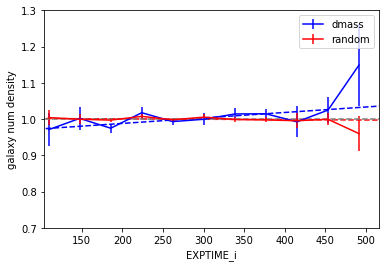

In [189]:
all_weight = weightmultiply( weightDic )
nextweight = 'EXPTIME_i'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  8.226610229761967
chi2_mod. =  5.041361301983181
Delta chi2 (sample) = 3.185248927778786
output save to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i.txt.model

chi2_null =  6.61488061186546
chi2_mod. =  3.7417842511544235
Delta chi2 (sample) = 2.8730963607110365
output save to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i.txt.model

chi2_null =  3.4773141000766565
chi2_mod. =  3.4510177162473212
Delta chi2 (sample) = 0.0262963838293353
output save to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i.txt.model

chi2_null =  6.724113017580281
chi2_mod. =  6.712344718236549
Delta chi2 (sample) = 0.011768299343732025
output save to  ../data_txt/systematics/5th/systematic_DEPTH_z_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptim

(['GE_g',
  'SKYBRITEpca2_g',
  'SKYBRITEpca1_g',
  'SKYBRITE_r',
  'DEPTH_g',
  'AIRMASS_z',
  'EXPTIME_g',
  'FWHM_g',
  'DEPTH_r',
  'SKYBRITE_i',
  'SKYBRITE_g',
  'FWHM_z',
  'AIRMASS_i',
  'NSTARS_allband_g',
  'EXPTIME_r',
  'FWHM_i',
  'FWHM_r',
  'SKYBRITE_z',
  'AIRMASS_g',
  'AIRMASS_r',
  'SKYBRITEpca0_g',
  'DEPTH_i',
  'DEPTH_z',
  'EXPTIME_i',
  'EXPTIME_z'],
 [85.74616217257385,
  5.1179095115001685,
  5.1179095115001685,
  4.24851809059807,
  3.185248927778786,
  3.075050287871223,
  3.073265589523297,
  3.014546914494467,
  2.8730963607110365,
  2.71094463923618,
  2.188810030980804,
  1.9713315345387397,
  1.406798781165831,
  0.8048686456748975,
  0.7844059831251329,
  0.49584793919563097,
  0.40171177950599635,
  0.3551323895756324,
  0.17996416309950902,
  0.0773596429160861,
  0.0655631513429622,
  0.0262963838293353,
  0.011768299343732025,
  0.0056291141551945145,
  0.0013747339690715066])

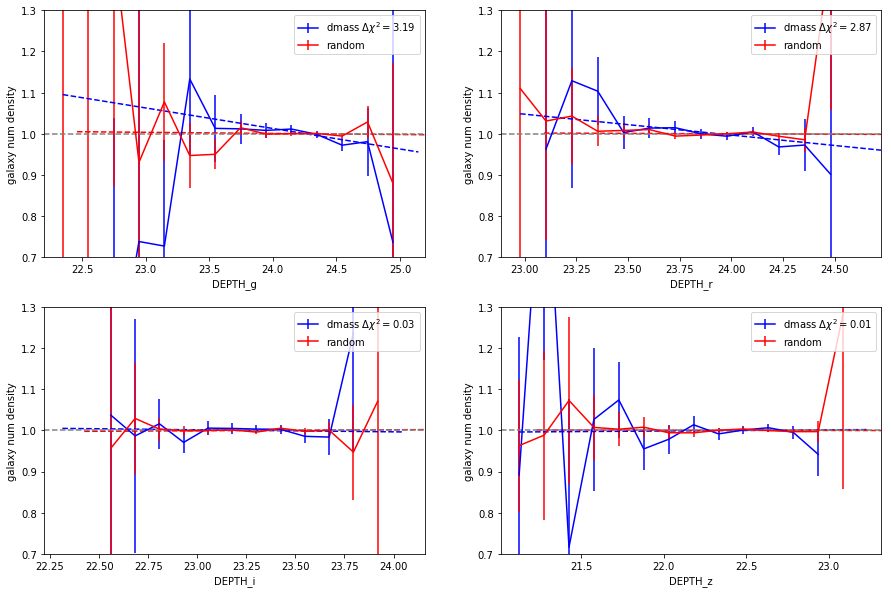

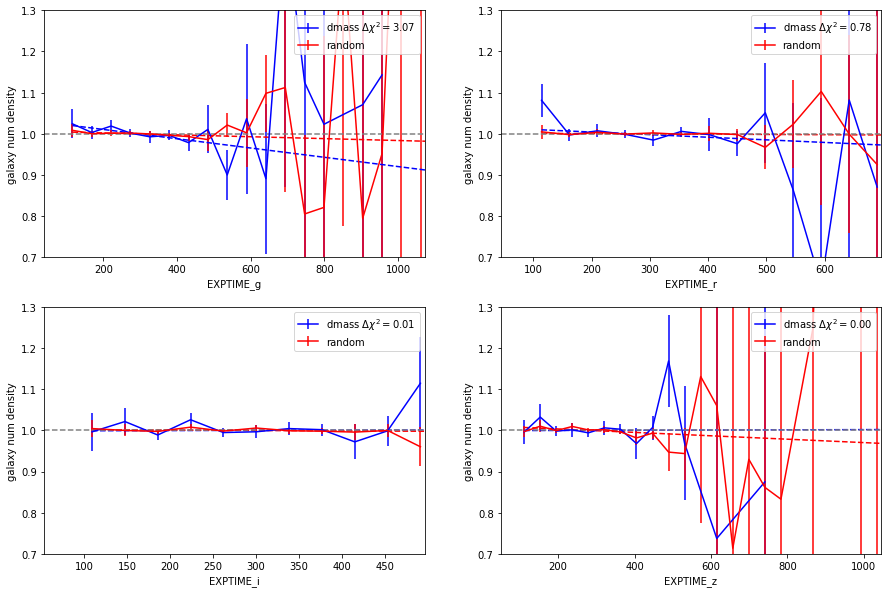

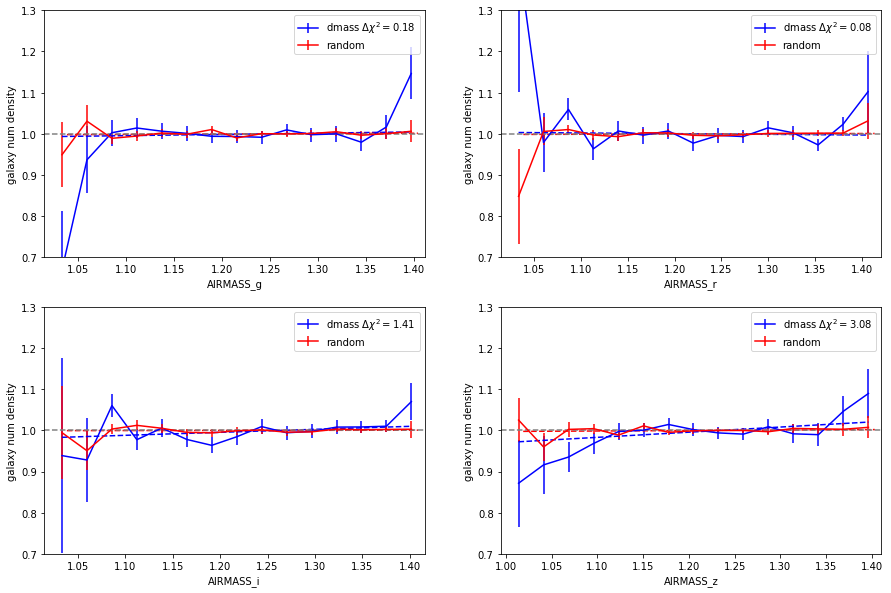

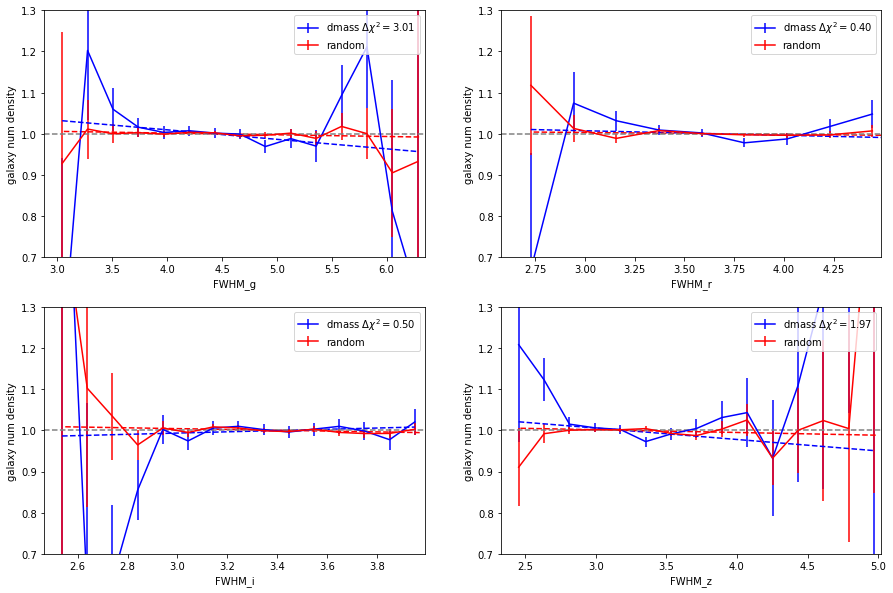

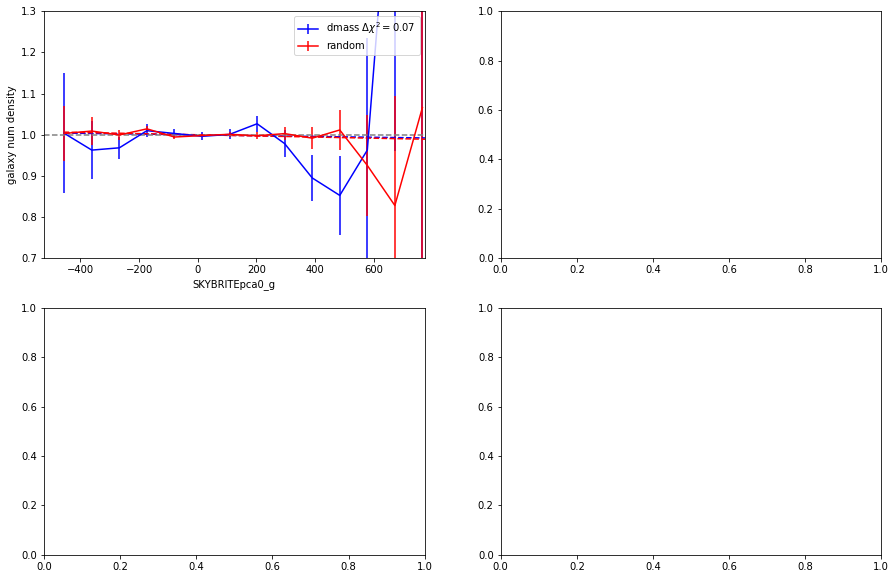

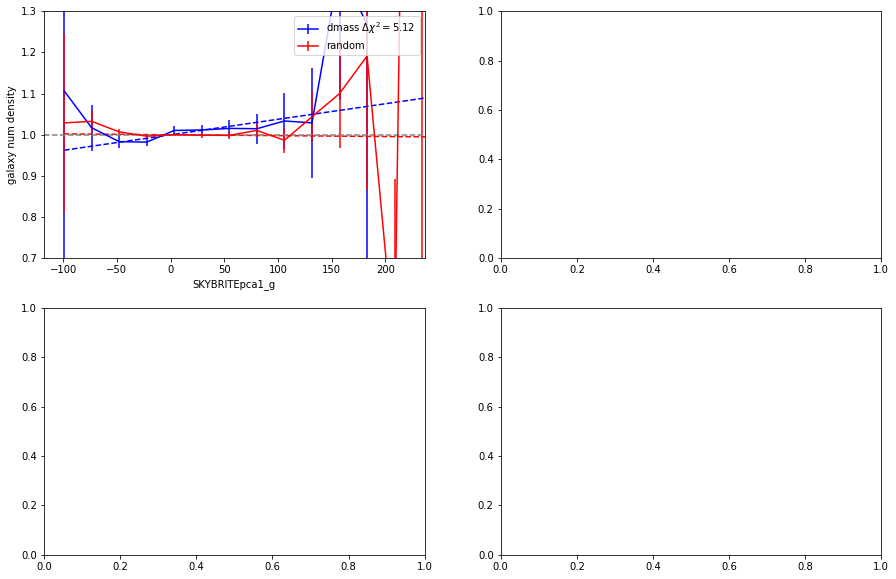

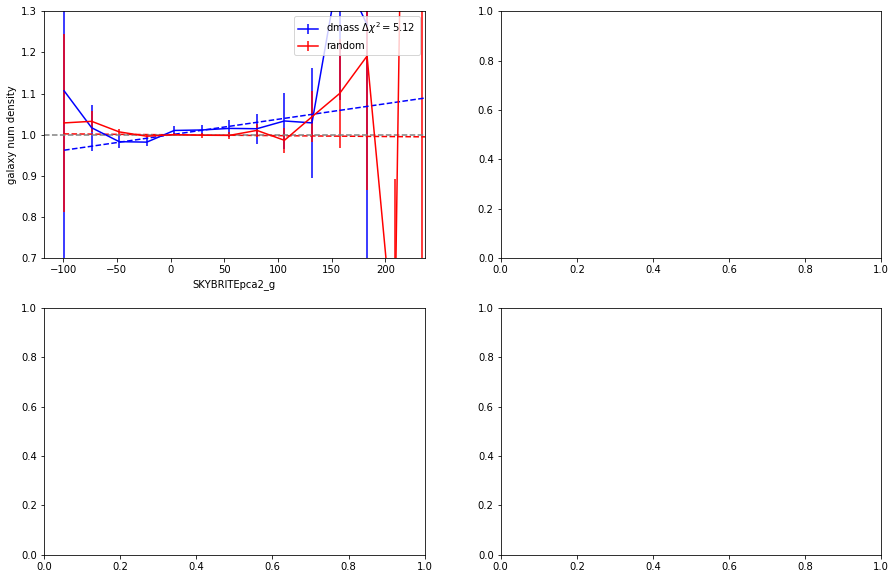

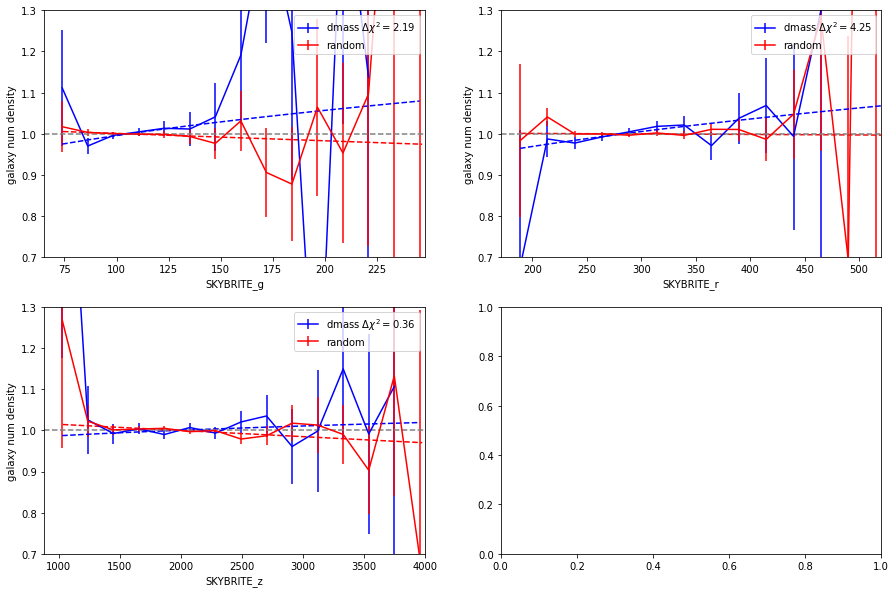

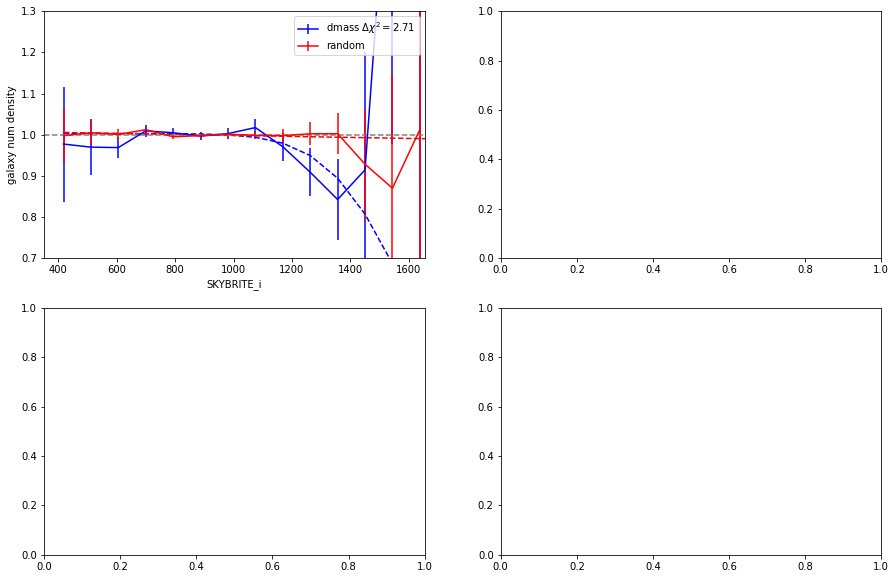

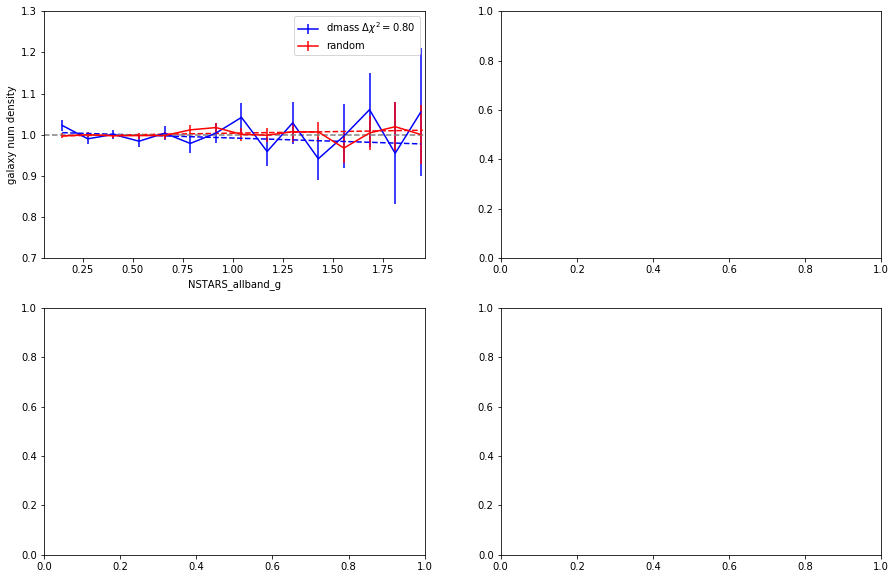

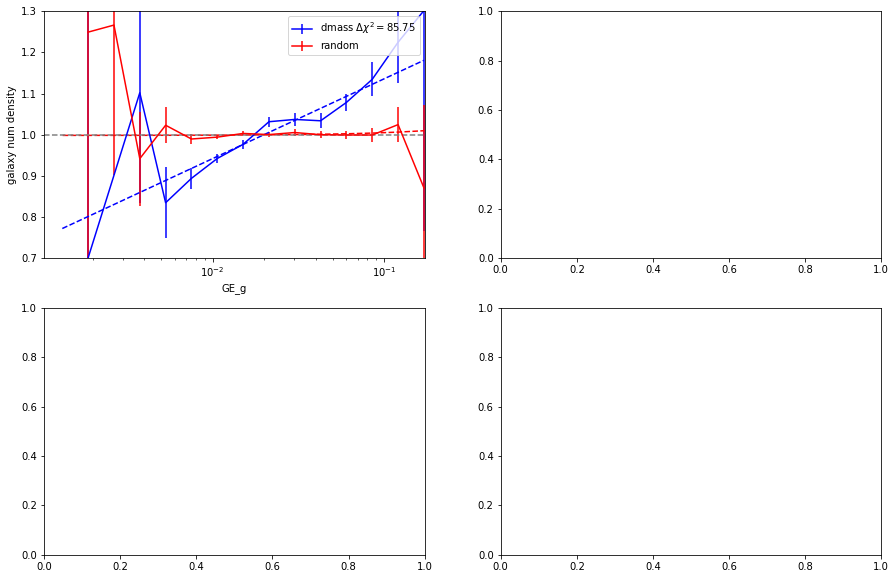

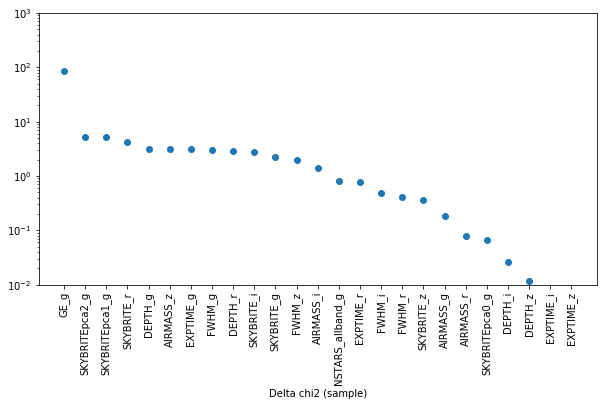

In [190]:
suffix = suffix+'_'+nextweight.lower()
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITEpca0','SKYBRITEpca1', 'SKYBRITEpca2'], filter= ['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['FWHM_r', 'AIRMASS_z', 'noweight', 'EXPTIME_i', 'SKYBRITEpca0_g', 'AIRMASS_i', 'NSTARS_allband_g']
FWHM_r
AIRMASS_z
noweight
EXPTIME_i
SKYBRITEpca0_g
AIRMASS_i
NSTARS_allband_g
----------------------------------
initialize function  SKYBRITEpca2_g
linear
store weight  SKYBRITEpca2_g
save weight to fits ../data_txt/systematics/5th//weights/wg_skybritepca2_g_SPT.fits
suffix =  wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH

chi2_null =  11.577821691676725
chi2_mod. =  11.530272209769867
Delta chi2 (sample) = 0.047549481906857594
output save to  ../data_txt/systematics/5th/systematic_SKYBRITEpca0_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g.txt.model

chi2_null =  4.109799633536459
chi2_mod. =  4.09473513415683
Delta chi2 (sample) = 0.015064499379628948
output save to  ../data_txt/systematics/5th/systematic_SKYBRITEpca1_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g.txt.model

chi2_null =  4.109799633536459
chi2_mod. =  4.09473513415683
Delta chi2 (sample) = 0.015064499379628948
output save to  ../data_txt/systematics/5th/systematic_SKYBRITEpca2_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g.txt.model

chi2_null =  22.813541203404796
chi2_mod. =  21.85933957701486
Delta chi2 (sample) = 0.9542016263899349
output save to  ../data_txt/systematics/5th/systematic_SKYBRITE_g

(['GE_g',
  'FWHM_g',
  'AIRMASS_z',
  'SKYBRITE_i',
  'AIRMASS_i',
  'FWHM_z',
  'EXPTIME_g',
  'DEPTH_g',
  'NSTARS_allband_g',
  'SKYBRITE_g',
  'DEPTH_r',
  'AIRMASS_g',
  'EXPTIME_r',
  'FWHM_i',
  'EXPTIME_i',
  'SKYBRITE_z',
  'DEPTH_z',
  'FWHM_r',
  'EXPTIME_z',
  'SKYBRITEpca0_g',
  'AIRMASS_r',
  'DEPTH_i',
  'SKYBRITEpca1_g',
  'SKYBRITEpca2_g',
  'SKYBRITE_r'],
 [83.21378531164196,
  4.289380647218856,
  3.5576047451701367,
  2.4216947636004917,
  2.363637776461637,
  2.2476727965807957,
  2.2271867791014124,
  1.773557345994731,
  1.1777907291479988,
  0.9542016263899349,
  0.5288597139997129,
  0.4937341558361954,
  0.3372941429100056,
  0.2759952861760784,
  0.16762128757800276,
  0.15891311517034268,
  0.14866360164178527,
  0.14616496314526017,
  0.08152124098526947,
  0.047549481906857594,
  0.034852777807760305,
  0.028880667045459774,
  0.015064499379628948,
  0.015064499379628948,
  0.0005587053622431171])

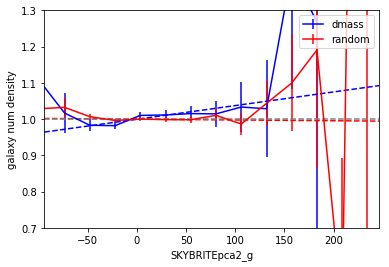

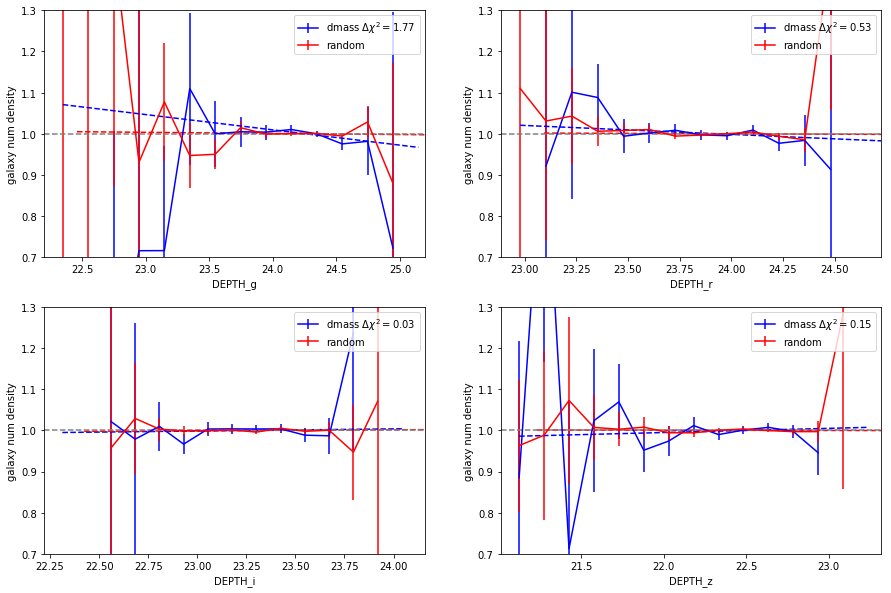

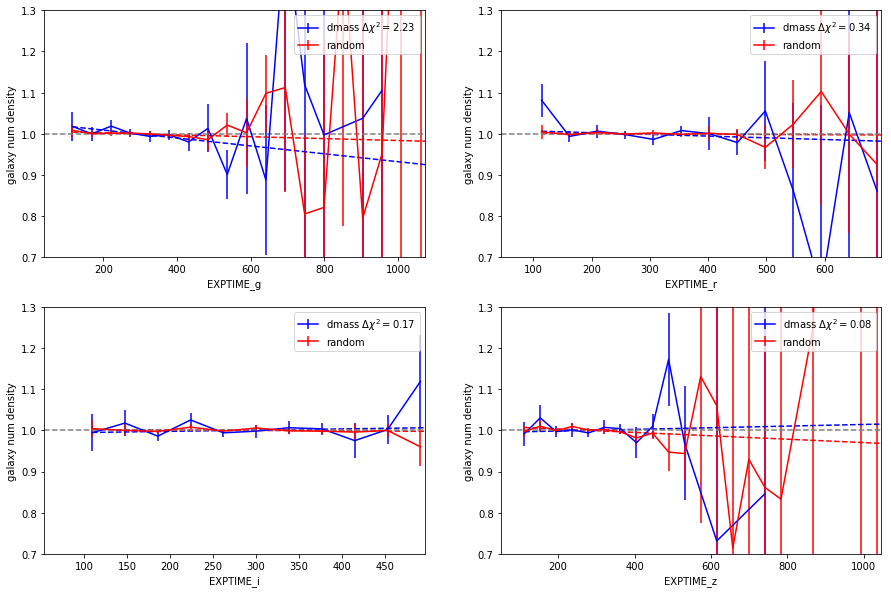

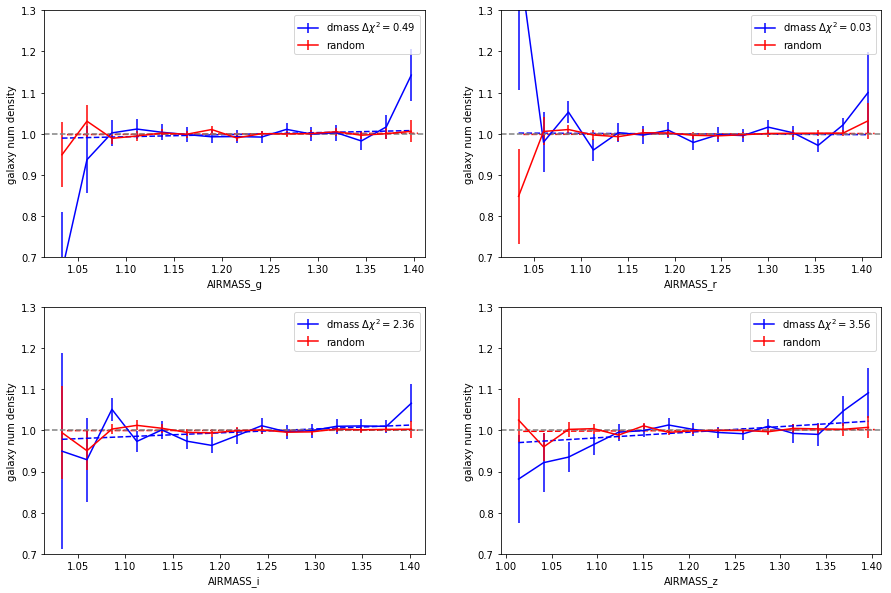

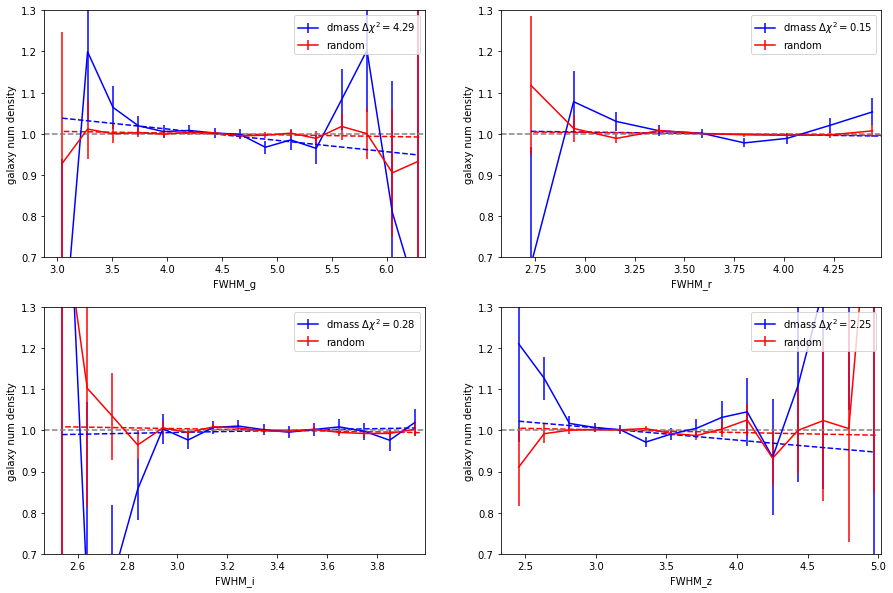

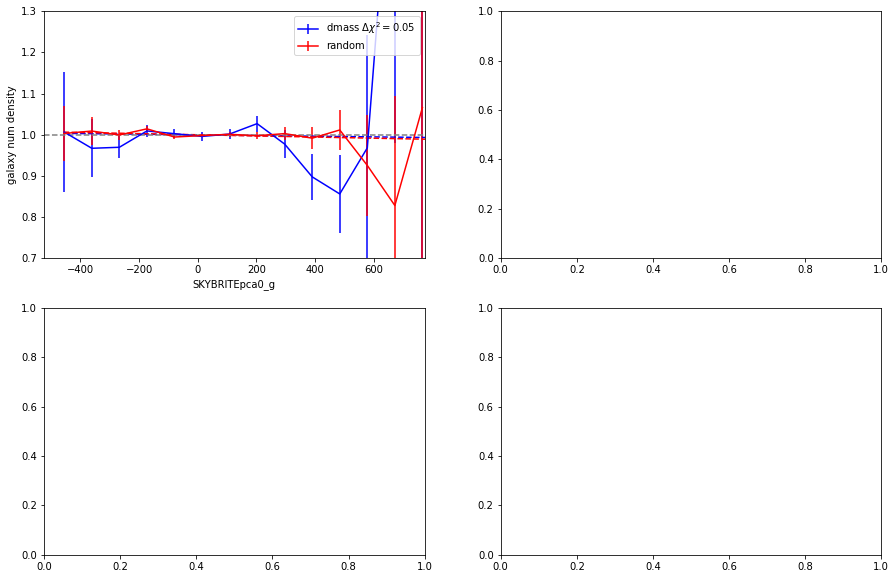

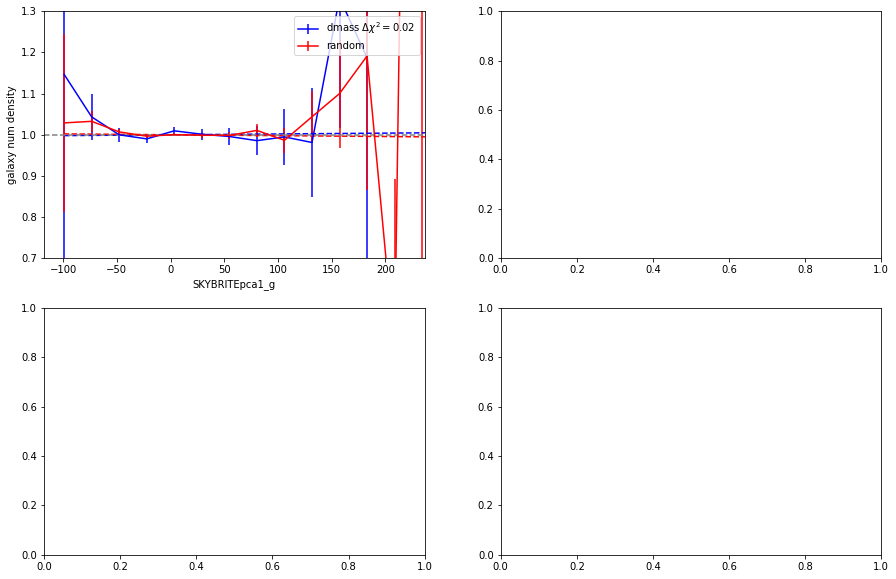

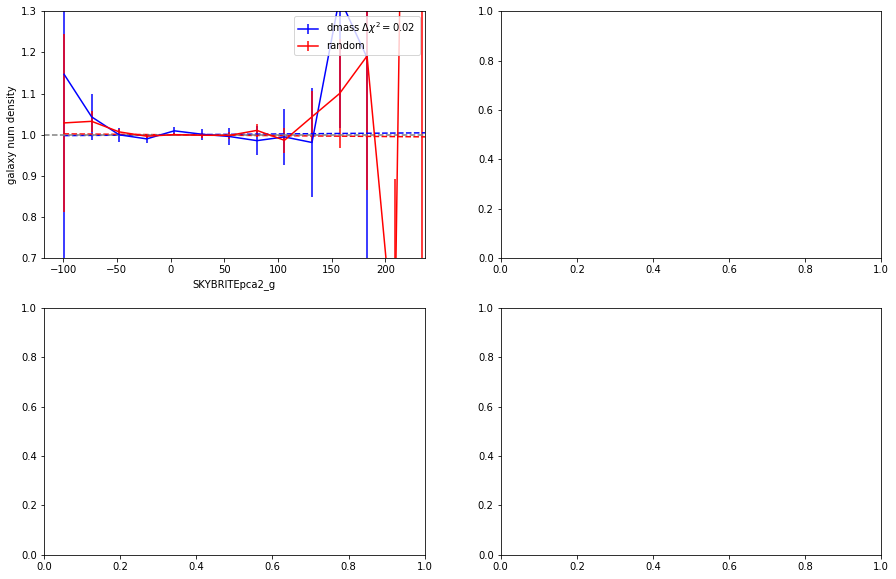

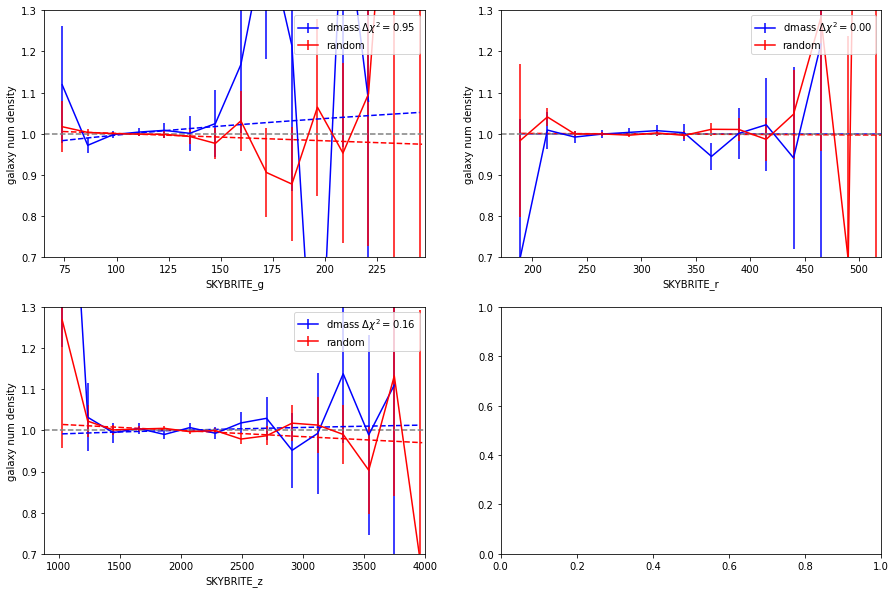

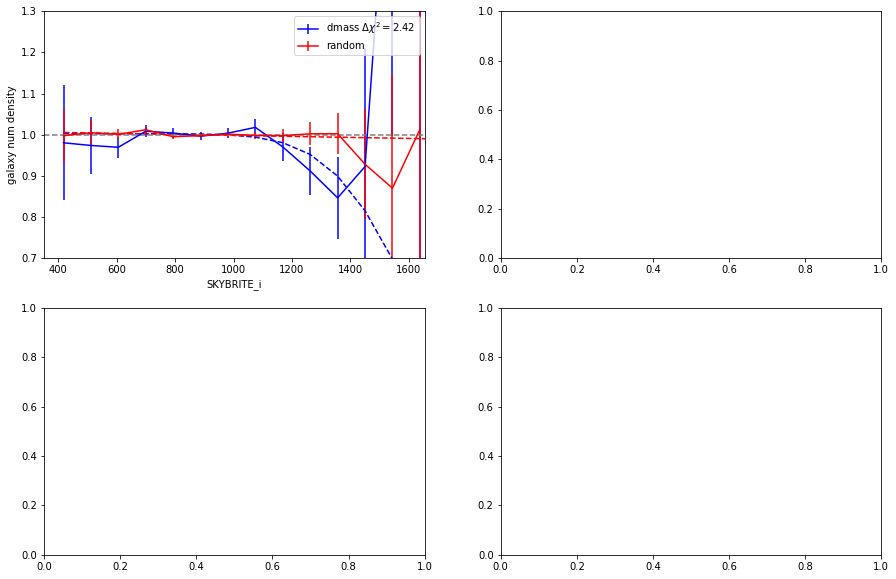

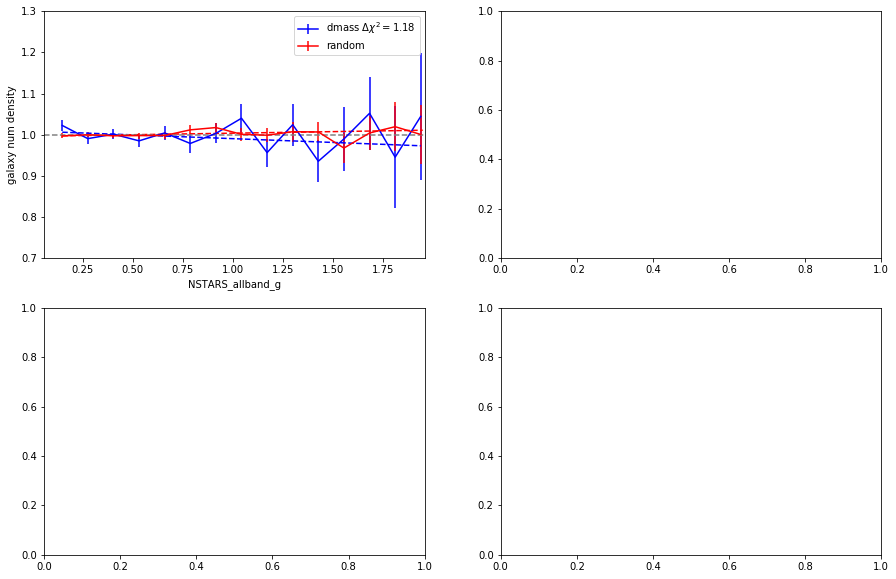

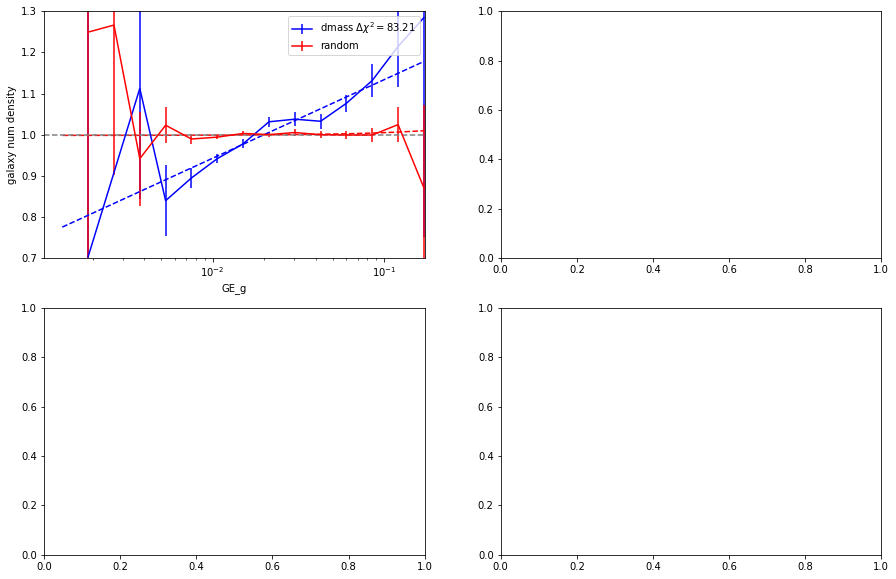

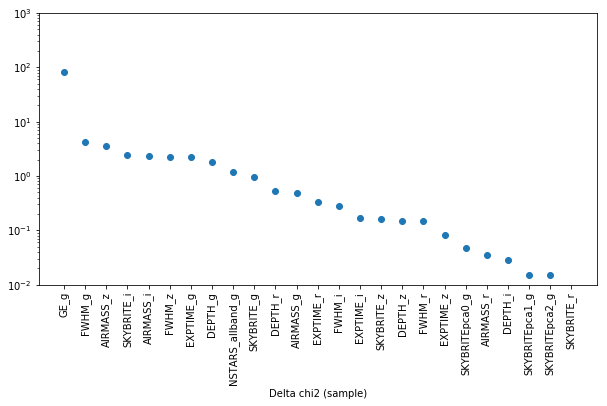

In [191]:
all_weight = weightmultiply( weightDic )
nextweight = 'SKYBRITEpca2_g'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITEpca0','SKYBRITEpca1', 'SKYBRITEpca2'], filter= ['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )

plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

['SKYBRITEpca2_g', 'FWHM_r', 'AIRMASS_z', 'noweight', 'EXPTIME_i', 'SKYBRITEpca0_g', 'AIRMASS_i', 'NSTARS_allband_g']
SKYBRITEpca2_g
FWHM_r
AIRMASS_z
noweight
EXPTIME_i
SKYBRITEpca0_g
AIRMASS_i
NSTARS_allband_g
----------------------------------
initialize function  FWHM_g
linear
store weight  FWHM_g
save weight to fits ../data_txt/systematics/5th//weights/wg_fwhm_g_SPT.fits
suffix =  wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g_fwhm_g
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g_fwhm_g.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_r_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g_fwhm_g.txt
saving data to  ../data_txt/systematics/5th/systematic_DEPTH_i_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g_fwhm_g.txt
saving data to  ../data

chi2_null =  11.5881924210875
chi2_mod. =  11.348421657470862
Delta chi2 (sample) = 0.2397707636166384
output save to  ../data_txt/systematics/5th/systematic_SKYBRITEpca0_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g_fwhm_g.txt.model

chi2_null =  4.5283121781234215
chi2_mod. =  4.341834817493694
Delta chi2 (sample) = 0.18647736062972786
output save to  ../data_txt/systematics/5th/systematic_SKYBRITEpca1_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g_fwhm_g.txt.model

chi2_null =  4.5283121781234215
chi2_mod. =  4.341834817493694
Delta chi2 (sample) = 0.18647736062972786
output save to  ../data_txt/systematics/5th/systematic_SKYBRITEpca2_g_SPT_wg_fwhm_r_airmass_z_airmass_i_nstars_allband_g_skybritepca0_g_exptime_i_skybritepca2_g_fwhm_g.txt.model

chi2_null =  22.26406900657176
chi2_mod. =  21.681988035501664
Delta chi2 (sample) = 0.5820809710700949
output save to  ../data_txt/systematics/5th/sy

(['GE_g',
  'AIRMASS_z',
  'SKYBRITE_i',
  'FWHM_z',
  'EXPTIME_g',
  'DEPTH_g',
  'AIRMASS_i',
  'NSTARS_allband_g',
  'DEPTH_r',
  'SKYBRITE_g',
  'FWHM_i',
  'EXPTIME_r',
  'AIRMASS_r',
  'SKYBRITEpca0_g',
  'SKYBRITEpca1_g',
  'SKYBRITEpca2_g',
  'DEPTH_z',
  'SKYBRITE_z',
  'EXPTIME_i',
  'SKYBRITE_r',
  'AIRMASS_g',
  'EXPTIME_z',
  'FWHM_r',
  'DEPTH_i',
  'FWHM_g'],
 [82.68990156724333,
  3.1125546674250515,
  2.7954759731973944,
  2.567659304202275,
  1.7281271897325379,
  1.4820847667135464,
  1.3981923631737487,
  1.0882932625911312,
  0.910952505951605,
  0.5820809710700949,
  0.5288163421415,
  0.4855569435148235,
  0.2538158970733697,
  0.2397707636166384,
  0.18647736062972786,
  0.18647736062972786,
  0.14551959915526513,
  0.10189738498389556,
  0.05691871062945708,
  0.05106083133053385,
  0.03962235478413767,
  0.03614181970257402,
  0.01426251662101663,
  0.00793036738823405,
  0.006686693832435253])

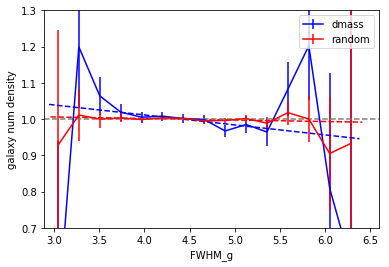

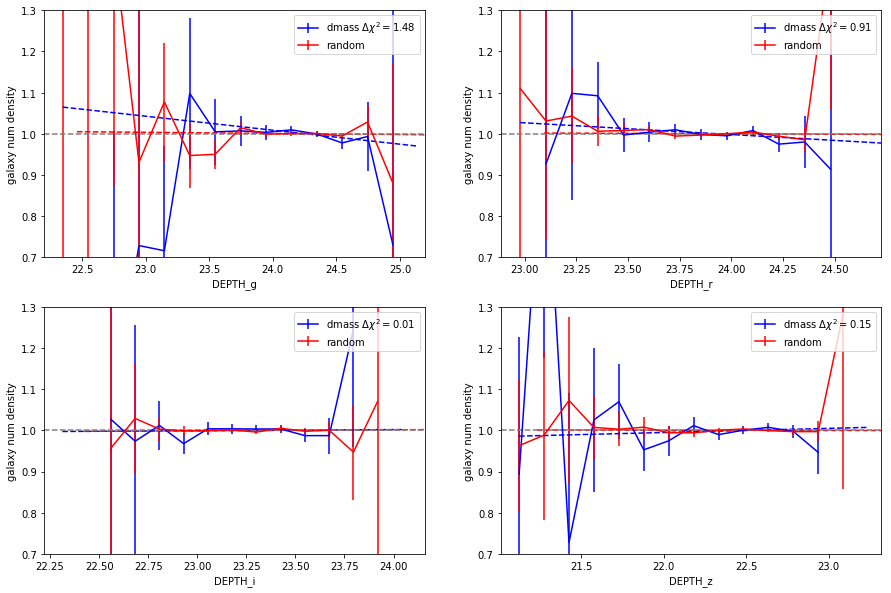

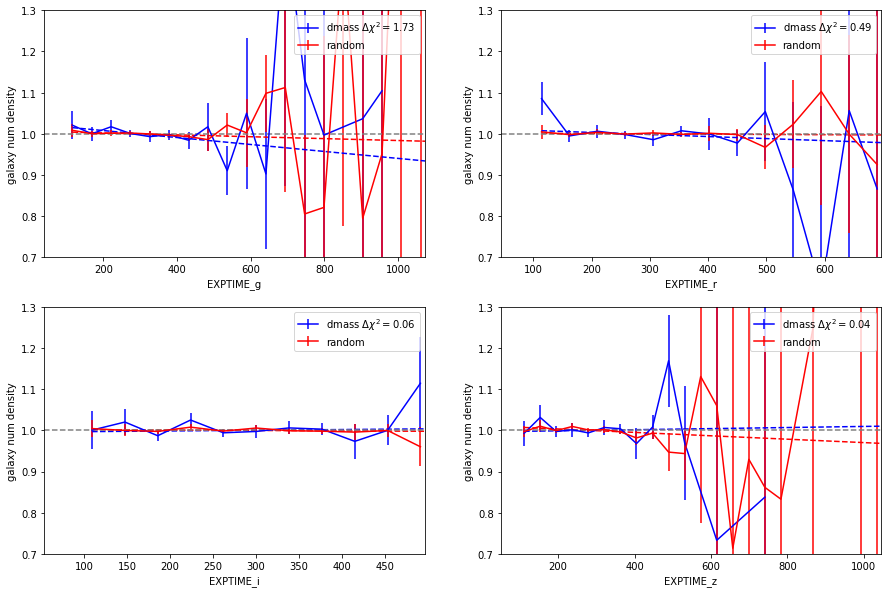

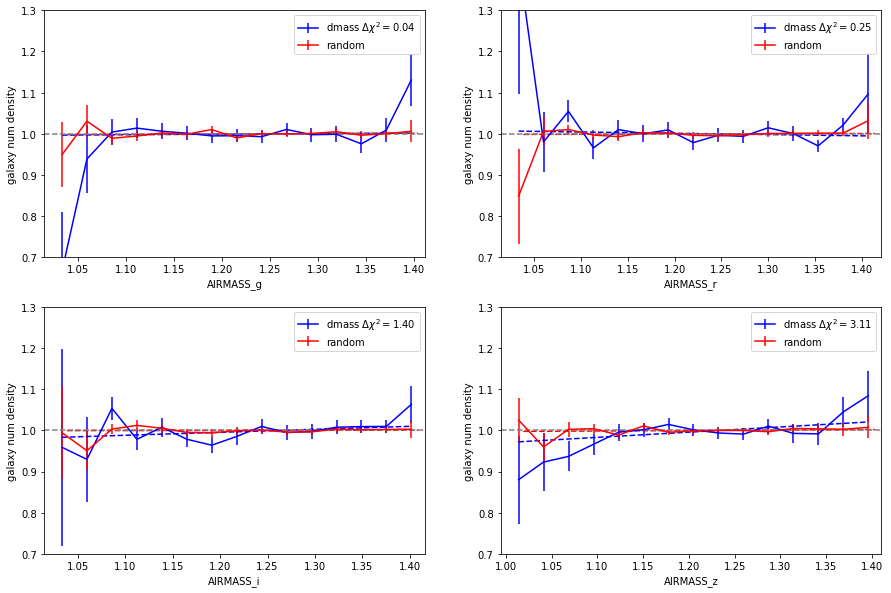

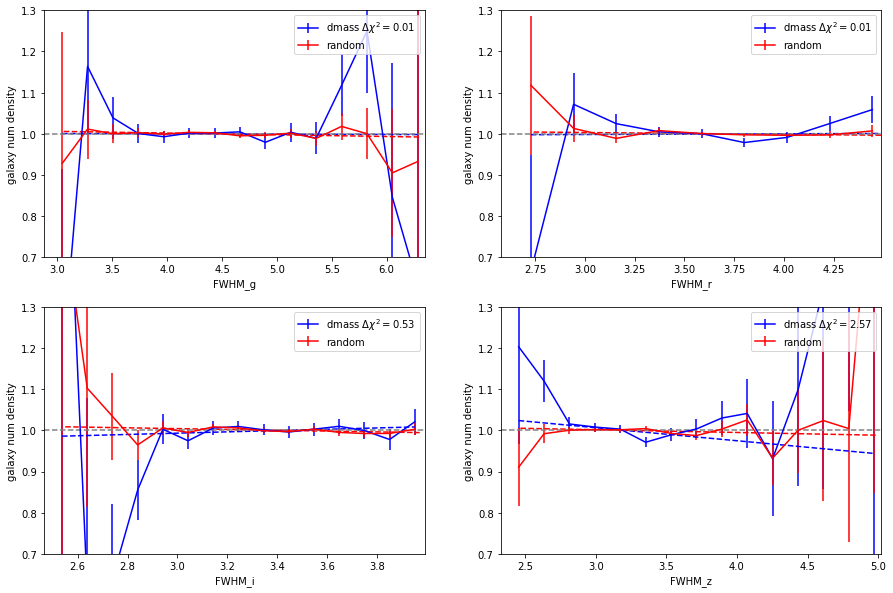

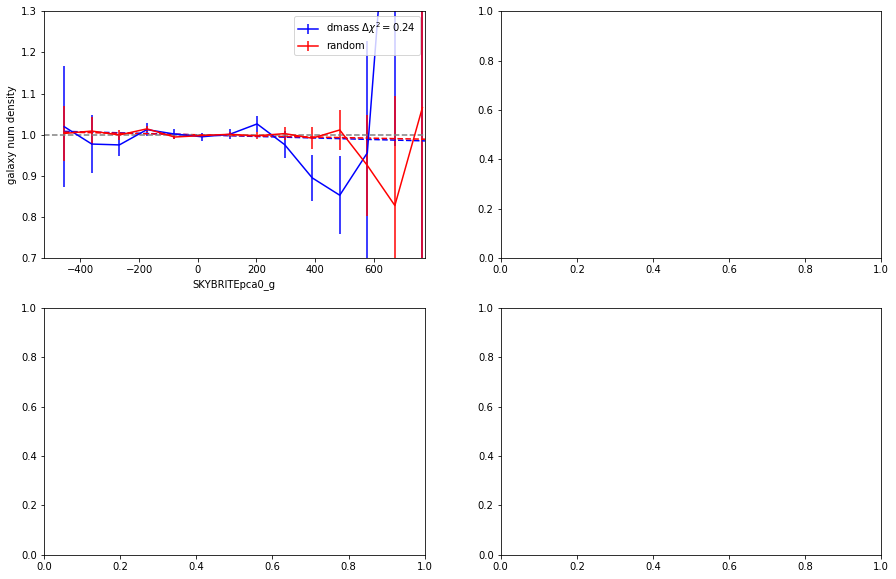

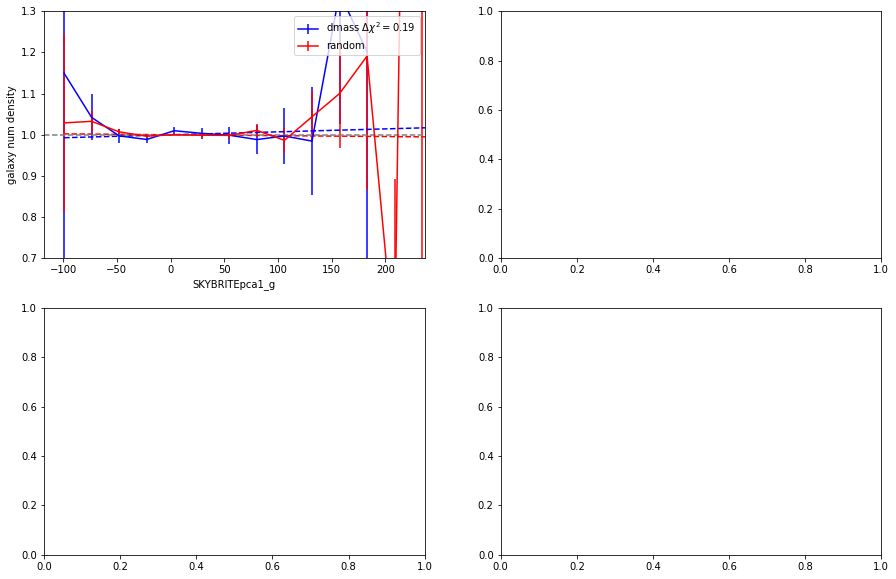

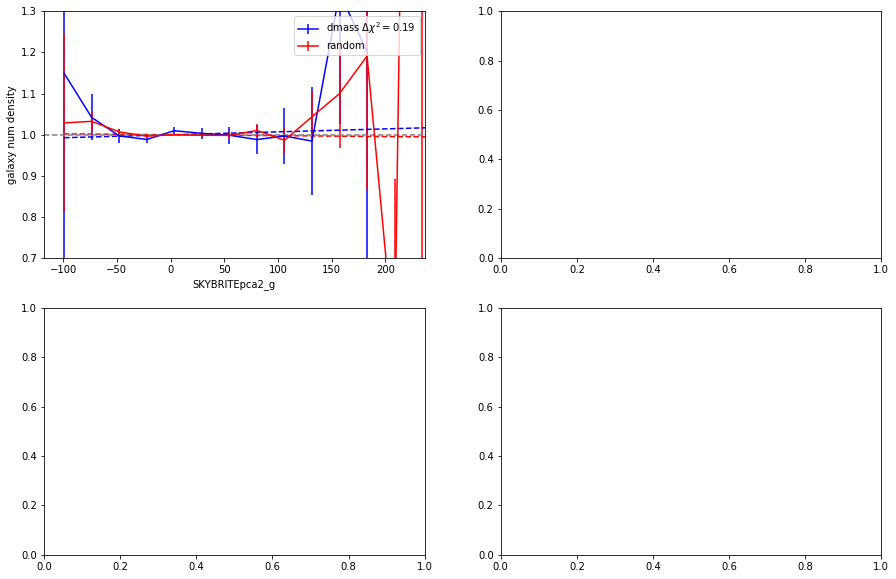

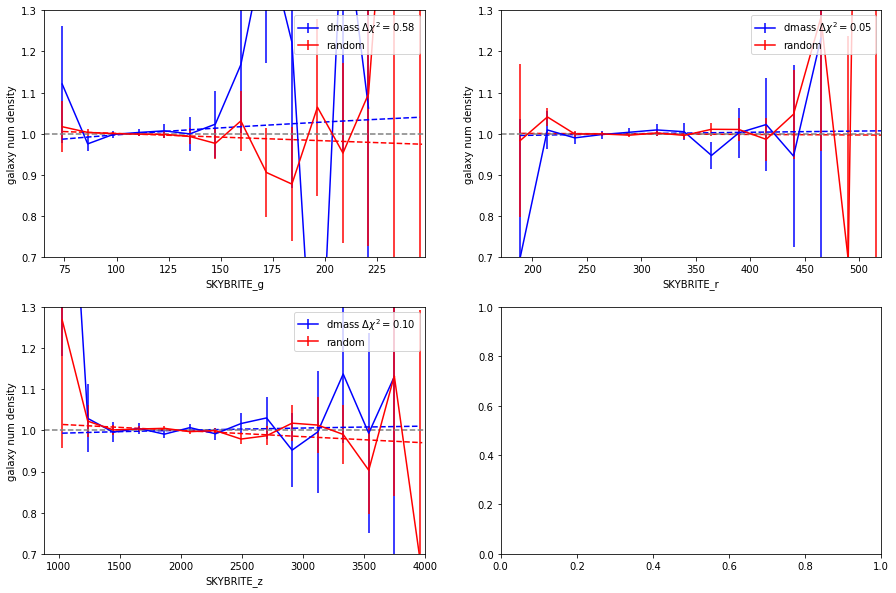

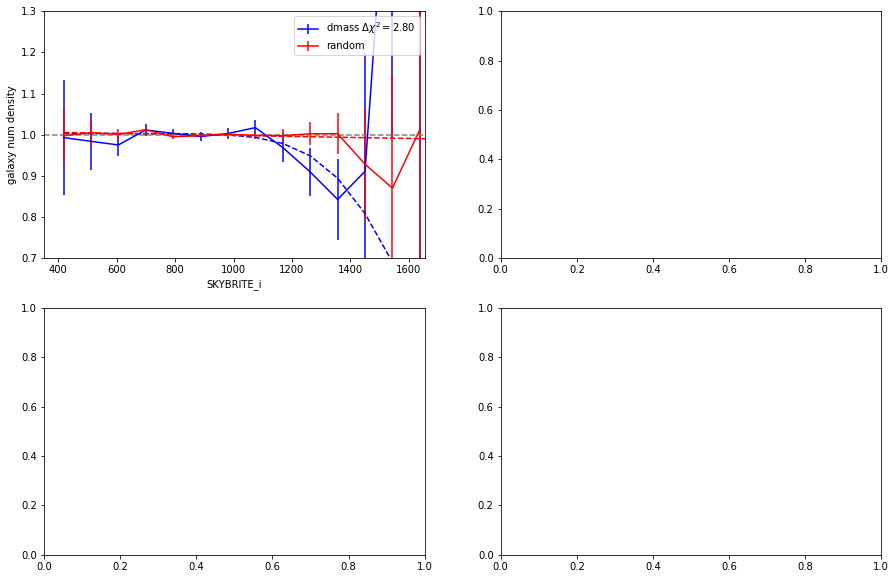

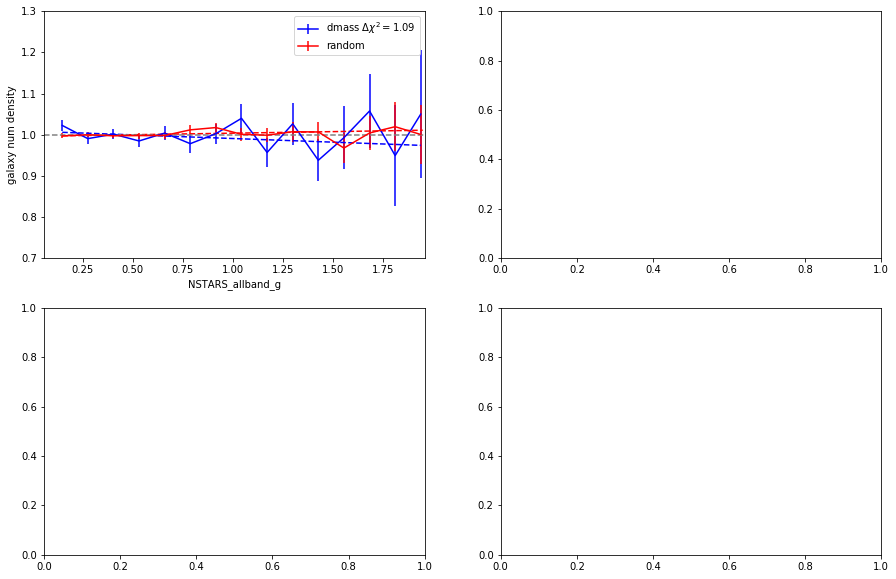

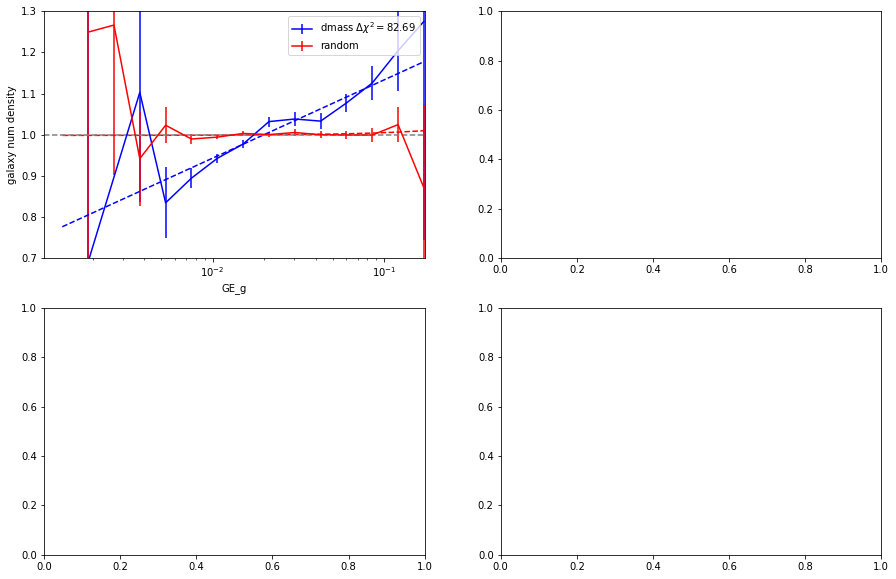

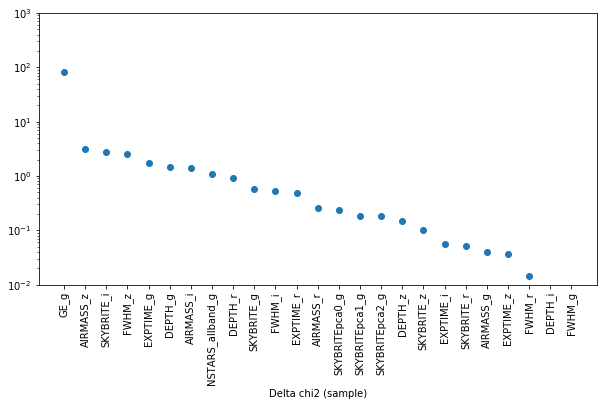

In [192]:
all_weight = weightmultiply( weightDic )
nextweight = 'FWHM_g'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITEpca0','SKYBRITEpca1', 'SKYBRITEpca2'], filter= ['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )

plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

In [ ]:
all_weight = weightmultiply( weightDic )
nextweight = 'AIRMASS_z'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

suffix = suffix+'_'+nextweight.lower()
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITEpca0','SKYBRITEpca1', 'SKYBRITEpca2'], filter= ['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )

plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

In [ ]:
suffix

In [ ]:
all_weight = weightmultiply( weightDic )
suffix = 'wg_fwhm_r_airmass_z_skybritepca0_g_fwhm_i'
nextweight = 'DEPTH_i'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

In [ ]:
suffix = suffix+'_'+nextweight.lower()
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITEpca0','SKYBRITEpca1'], filter= ['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)

[79.83735512899429, 53.49617865476577, 28.509744706065348, 26.760437131711505, 18.367289560103742, 17.471874037287286, 13.953920005412595, 11.590416835281749, 7.180282678905282, 5.015956513125536, 3.9620365550386714, 1.8176606759773017, 1.042187768236305, 0.8288005497627875, 0.6149681116305241, 0.45263595633948484, 0.2764250508388004, 0.13316766113053813, 0.12007363708290963, 0.11243766010556655, 0.010894676698766759, 0.005140852971523557]
[76.63304645210606, 6.674241379779318, 4.6723353200222775, 3.7235289503912483, 1.8977425723413361, 1.7972944565671236, 1.1103846671482311, 0.8033134075871002, 0.7835517094931435, 0.28870964024891066, 0.22489307770364242, 0.08849568785302608, 0.07545819320633207, 0.06489724132092078, 0.06453543204467493, 0.04091568185483041, 0.036387017783725994, 0.022924366120430584, 0.02259164803386149, 0.011270323144374927, 0.0033770948246107935, 0.002529356153690543]


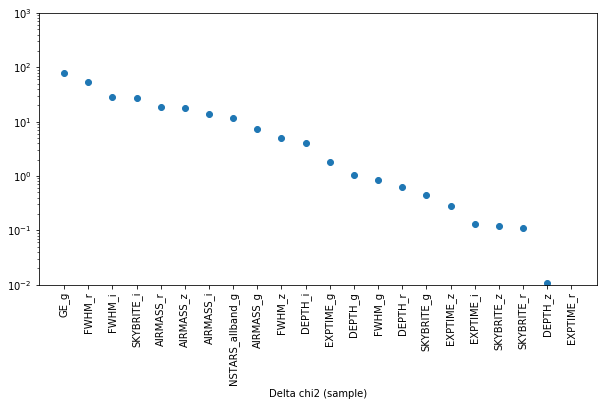

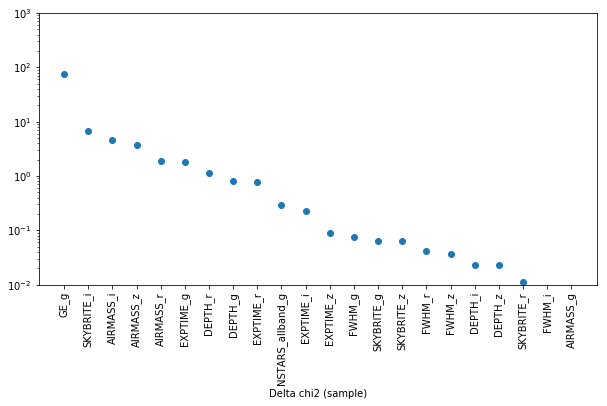

In [120]:
label_no_weight, values_no_weight = plotting_significance( property = properties, filter=filters, kind = kind, suffix='no_weight', 
                    path = inputdir, deltachi2=True)
label_full_weight, values_full_weight = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suffix, 
                    path = inputdir, deltachi2=True)
#_ = plotting_significance( property = properties, filter=filters, kind = kind, suffix='1', 
#                    path = path, deltachi2=False)

0

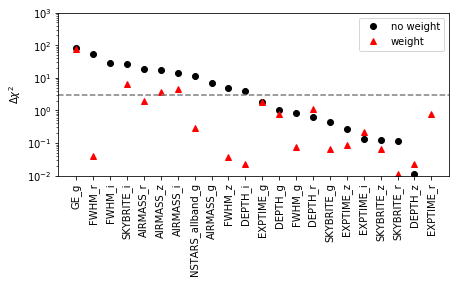

In [121]:

values_full_weight_reorder = []
for la in label_no_weight:
    for j in range(len(label_full_weight)):
        if la == label_full_weight[j]: 
            values_full_weight_reorder.append(values_full_weight[j])
            break

values_full_weight_reorder = np.array(values_full_weight_reorder)

fig, ax = plt.subplots(figsize = (7,3))

ax.plot( np.arange( len(values_no_weight) ), values_no_weight,  'ko' , label='no weight'  )
ax.plot( np.arange( len(values_no_weight) ), values_full_weight_reorder, 'r^', label='weight'  )


#ax.plot( values_no_weight, np.arange( len(values_no_weight) ),  'ko'  )
#ax.plot( values_full_weight_reorder, np.arange( len(values_no_weight) ),  'ro'  )
#ax.axhline(y = 1, ls = '--', color='grey')
ax.axhline(y = 3, ls = '--', color='grey')
ax.set_ylim(0.01,1000)
ax.set_ylabel(r'$\Delta \chi^2$')
ax.set_xticks( np.arange(len(values_no_weight)))
ax.set_xticklabels(label_no_weight, rotation = 90)
ax.set_yscale('log')
ax.legend(loc='best')
0

saving fig to  ../data_txt/systematics/4th/figure/comparison_systematic_GE_SPT_wg_fwhm_r_airmass_z_airmass_i_skybrite_i_skybrite_r_airmass_r_airmass_g_nstars_allband_g_depth_i_exptime_g_fwhm_g_fwhm_z_exptime_z_depth_r_fwhm_i_exptime_i_depth_g.png


0

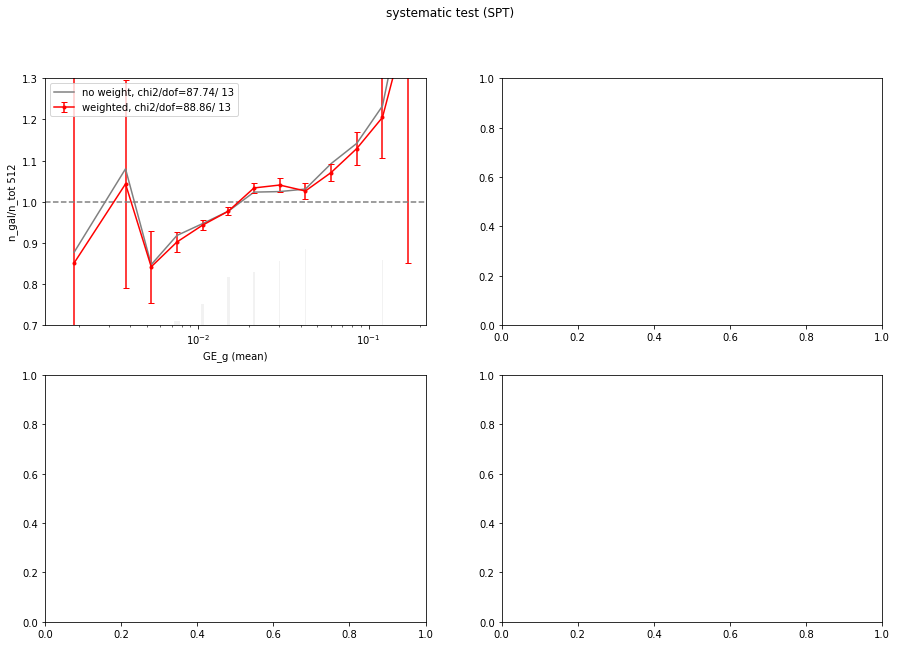

In [129]:
from systematics_module.contCorrection import plot_sysweight
plot_sysweight(property = 'GE', nside = 1024, kind = 'SPT', 
           suffix1='no_weight', suffix2=suffix, inputdir1 = inputdir, inputdir2 = inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/4th/figure/comparison_systematic_DEPTH_SPT_wg_fwhm_r_airmass_z_airmass_i_skybrite_i_skybrite_r_airmass_r_airmass_g_nstars_allband_g_depth_i_exptime_g_fwhm_g_fwhm_z_exptime_z_depth_r_fwhm_i_exptime_i_depth_g.png
saving fig to  ../data_txt/systematics/4th/figure/comparison_systematic_EXPTIME_SPT_wg_fwhm_r_airmass_z_airmass_i_skybrite_i_skybrite_r_airmass_r_airmass_g_nstars_allband_g_depth_i_exptime_g_fwhm_g_fwhm_z_exptime_z_depth_r_fwhm_i_exptime_i_depth_g.png
saving fig to  ../data_txt/systematics/4th/figure/comparison_systematic_AIRMASS_SPT_wg_fwhm_r_airmass_z_airmass_i_skybrite_i_skybrite_r_airmass_r_airmass_g_nstars_allband_g_depth_i_exptime_g_fwhm_g_fwhm_z_exptime_z_depth_r_fwhm_i_exptime_i_depth_g.png
saving fig to  ../data_txt/systematics/4th/figure/comparison_systematic_SKYBRITE_SPT_wg_fwhm_r_airmass_z_airmass_i_skybrite_i_skybrite_r_airmass_r_airmass_g_nstars_allband_g_depth_i_exptime_g_fwhm_g_fwhm_z_exptime_z_depth_r_fwhm_i_exptime_i_depth

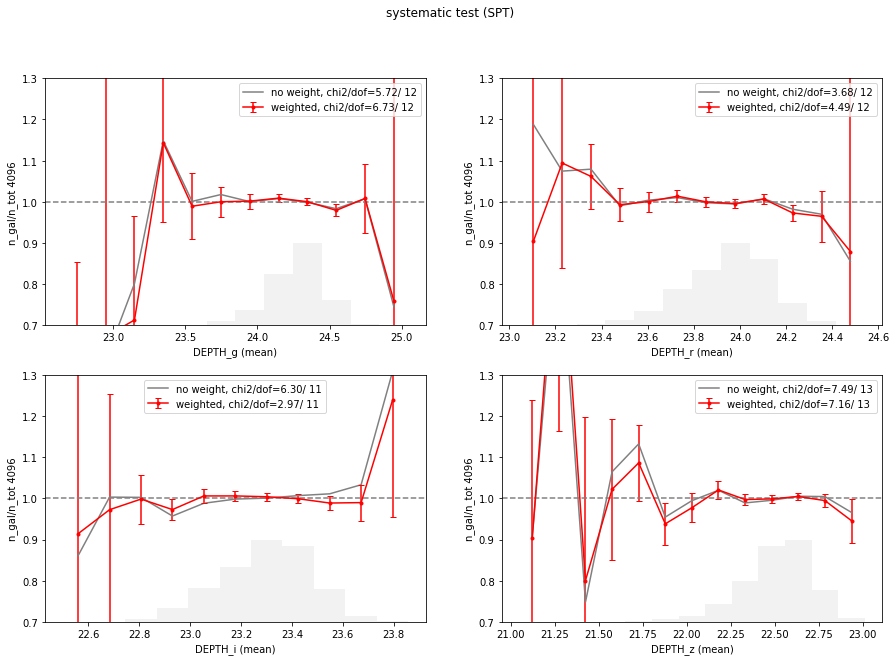

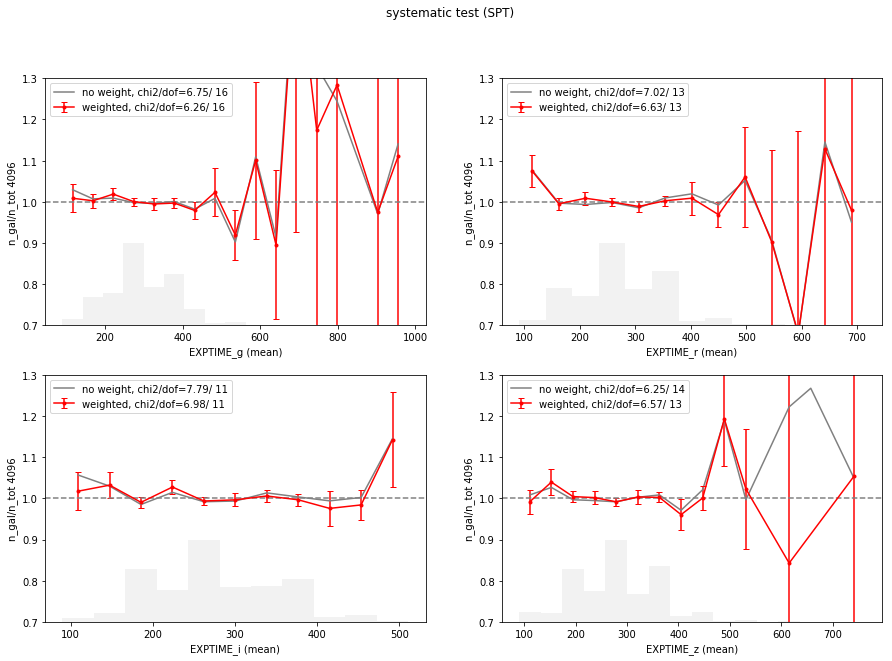

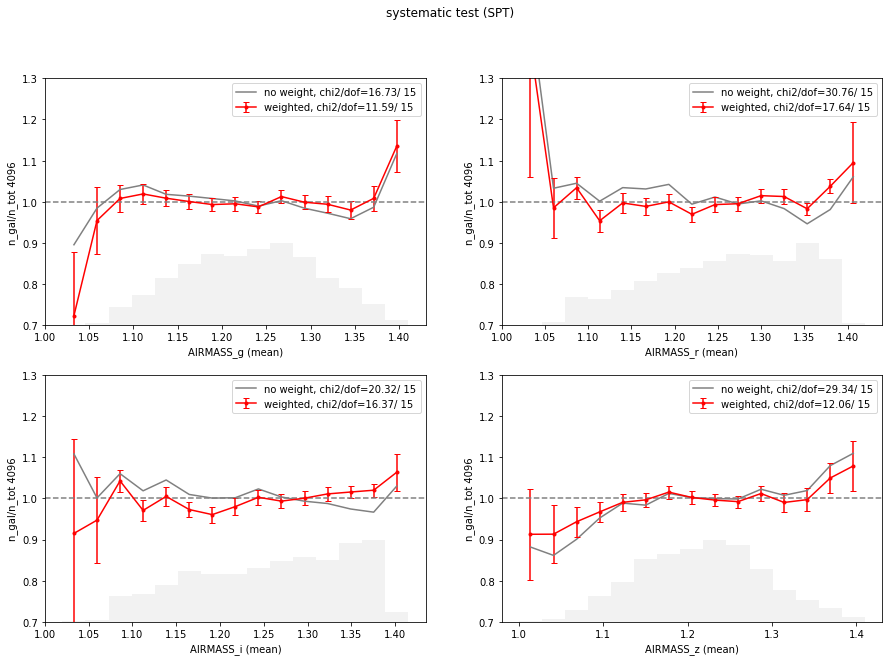

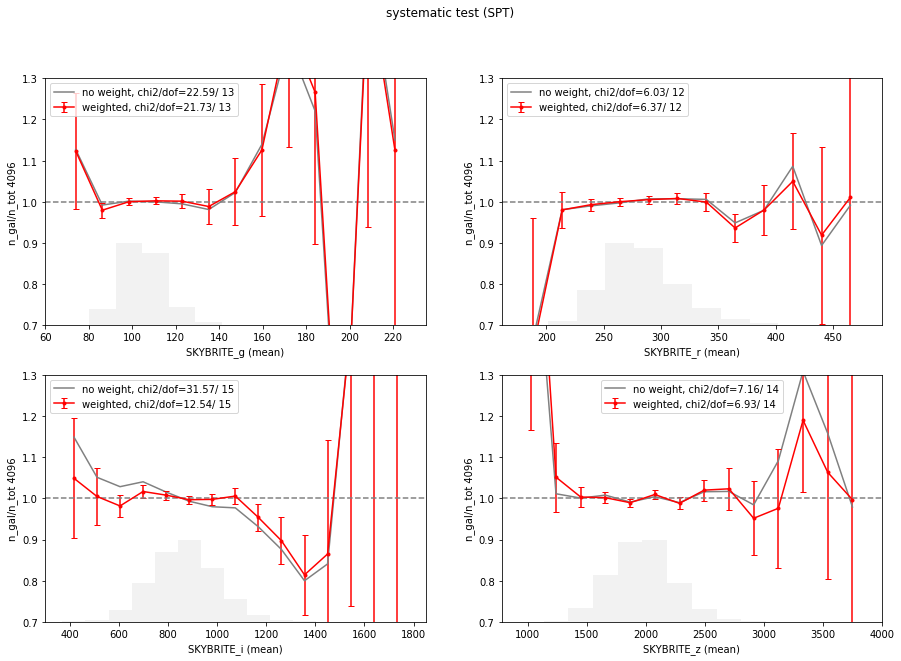

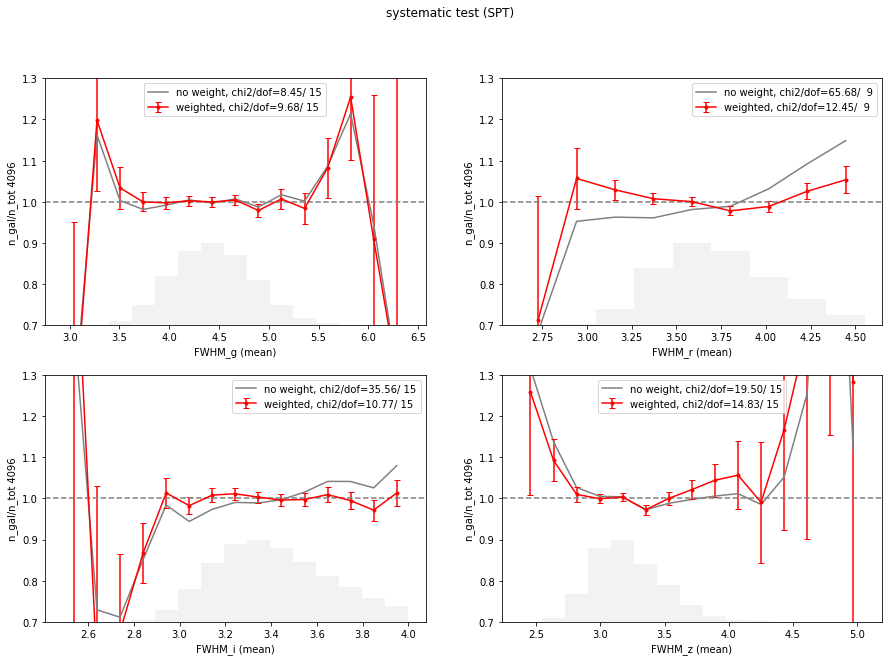

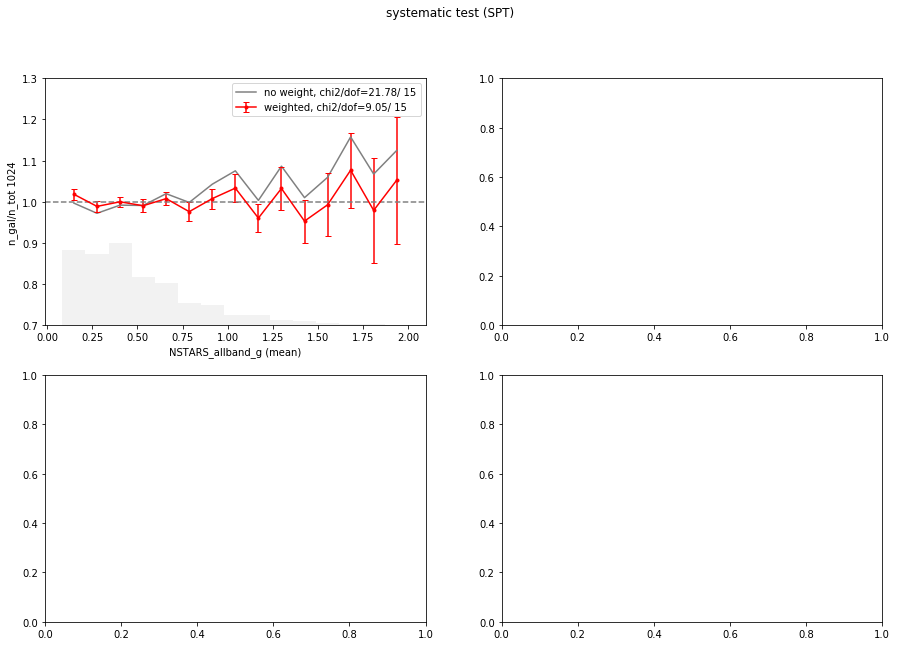

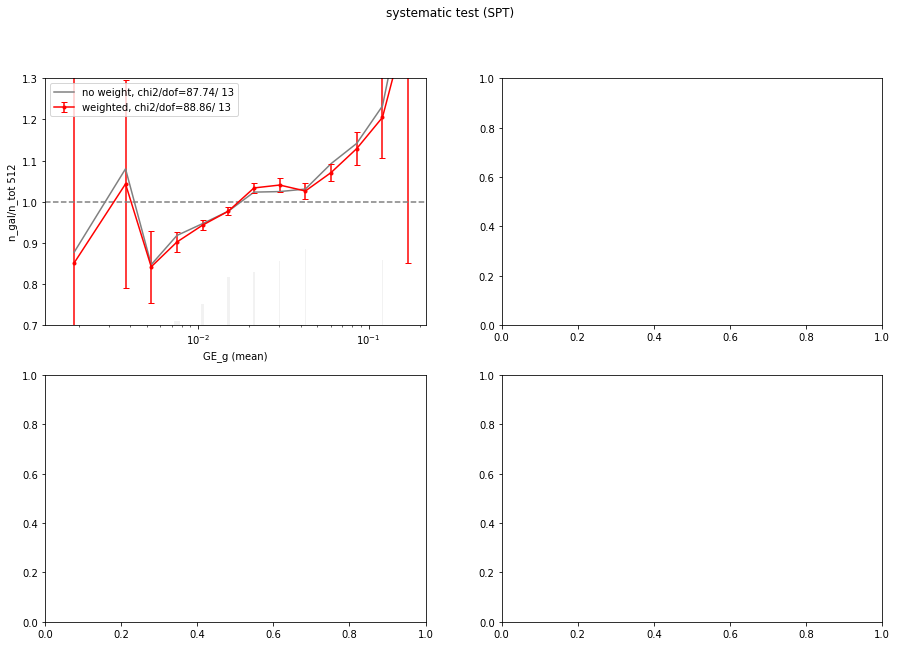

In [130]:
from systematics_module.contCorrection import plot_sysweight
for pr in properties:
    plot_sysweight(property = pr, nside = 4096, kind = 'SPT', 
               suffix1='no_weight', suffix2=suffix, inputdir1 = inputdir, inputdir2 = inputdir, outdir=figoutdir)

